<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Finland/Neste/Neste_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "NES1VFIEUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-26 14:58:29,935 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-26 14:58:29,937 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for NES1VFIEUR
2019-08-26 14:59:43,732 - findatapy.market.datavendorweb - WARNING - Problem downloading.. HTTPConnectionPool(host='datafeed.dukascopy.com', port=80): Read timed out. (read timeout=10)
2019-08-26 15:02:05,032 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-26 15:07:58,489 - findatapy.market.datavendorweb - WARNING - Problem downloading.. HTTPConnectionPool(host='datafeed.dukascopy.com', port=80): Read timed out. (read timeout=10)
2019-08-26 15:09:02,353 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-26 15:12:29,081 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-26 15:15:50,213 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-26 15:19:16,

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.53148  0.53348  0.52798  0.52815  0.520331
2018-01-02 09:00:00  0.52847  0.52848  0.52497  0.52697  0.536695
2018-01-02 10:00:00  0.52697  0.52898  0.52637  0.52638  0.831912
2018-01-02 11:00:00  0.52698  0.52898  0.52537  0.52897  0.713550
2018-01-02 12:00:00  0.52948  0.53048  0.52848  0.52898  0.431290
...                      ...      ...      ...      ...       ...
2018-12-28 12:00:00  0.66978  0.67378  0.66667  0.67378  3.960000
2018-12-28 13:00:00  0.67397  0.67397  0.67057  0.67348  2.490000
2018-12-28 14:00:00  0.67337  0.67358  0.67108  0.67217  2.860000
2018-12-28 15:00:00  0.67218  0.67218  0.66888  0.67127  4.280000
2018-12-28 16:00:00  0.67157  0.67278  0.67018  0.67148  1.660000

[2244 rows x 5 columns]

Open         High          Low        Close       Volume
count  2244.000000  2244.000000  2244.000000  2244.000000  2244.000000
mean      0.657857     0.660369     0.655451     0.657939     4.182285
std       0.067664     0.067824     0.067480     0.067620     2.221247
min       0.522780     0.524580     0.520980     0.522770     0.329428
25%       0.584580     0.586577     0.582878     0.584723     2.487500
50%       0.674320     0.676575     0.671735     0.674225     3.790000
75%       0.713712     0.716290     0.710972     0.713680     5.460000
max       0.764280     0.765280     0.762180     0.764180    16.850000

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2018-01-09 13:00:00  0.54358  0.54458  0.54317  0.54457  0.979827    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.541350  0.530746 -0.546452  0.545184  0.542608  0.542838    0.542875    0.540370  0.536357  0.543453  0.544742  0.542939  0.543494  0.543453  0.544177  0.537014                0.547526                 0.543453                0.539379                0.549563                 0.543453                0.537342                0.551600                 0.543453                0.535305                0.553637                 0.543453                0.533268  0.542608  0.544043  0.537861                0.546682                 0.542608                0.538534                0.548719                 0.542608                0.536497                0.550756                 0.542608                0.534460                0.552793                 0.542608                0.532423   
2018-01-09 14:00:00  0.54457  0.54657  0.54037  0.54038  1.880003    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.540865  0.533275  0.533170  0.543732  0.542113  0.542760    0.542875    0.540370  0.537254  0.542978  0.542643  0.543029  0.542811  0.542978  0.542475  0.537787                0.547466                 0.542978                0.538489                0.549711                 0.542978                0.536244                0.551955                 0.542978                0.534000                0.554200                 0.542978                0.531755  0.542113  0.541677  0.538626                0.546602                 0.542113                0.537624                0.548846                 0.542113                0.535380                0.551091                 0.542113                0.533135                0.553335                 0.542113                0.530891   
2018-01-09 15:00:00  0.5

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000    2194.000000  2194.000000   2194.000000     2194.000000       2194.000000  2194.000000  2194.000000  2194.000000  2194.000000   2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000  2194.000000  2194.000000  2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000   
mean      0.660689     0.663213     0.658270     0.660765     4.240233    16.002735     2.010939   184.404740      30.418870    11.380128      0.032361        0.024157          0.004102     6.563355     2.526892    26.913400     2.010939      1.993163    26.913400     0.660552     0.660177     0.010028     0.660769     0.660559     0.660376     0.660481     0.660429     0.659950     0.660560     0.660764     0.660560     0.660629     0.660560     0.660717     0.660136                0.667924                 0.660560                0.653197                0.671605                 0.660560                0.649515                0.675287                 0.660560                0.645833                0.678969                 0.660560                0.642151     0.660559     0.660723     0.660202                0.667923                 0.660559                0.653196                0.671605                 0.660559                0.649514                0.675286   
std       0.065741     0.065886     0.065571     0.065704     2.209906     8.576205     1.409650   101.517669       0.857907     2.623769      0.176997        0.153571          0.063931     3.341601     1.103184    14.501373     1.409650      1.408219    14.501373     0.065595     0.065433     0.663096     0.065800     0.065591     0.065413     0.065616     0.065708     0.066291     0.065688     0.065754     0.065728     0.065662     0.065688     0.065695     0.065686                0.066527                 0.065688                0.065470                0.067173                 0.065688                0.065597                0.067965                 0.065688                0.065880                0.068897                 0.065688                0.066317     0.065591     0.065669     0.065684                0.066464                 0.065591                0.065339                0.067127                 0.065591                0.065449                0.067936   
min       0.524280     0.537770     0.523180     0.536170     0.400000     1.000000     0.000000     9.000

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.080417  0.029933  0.083640  0.036841  0.035248    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.003348  0.000000  0.143700  0.035224  0.009688  0.002950    0.019046    0.019929  0.054427  0.019424  0.038009  0.015858  0.018223  0.019424  0.029630  0.000000                0.024558                 0.019424                0.149368                0.025157                 0.019424                0.234872                0.024842                 0.019424                0.305778                0.024586                 0.019424                0.364211  0.009688  0.028160  0.000000                0.014102                 0.009688                0.113902                0.015188                 0.009688                0.203402                0.015831                 0.009688                0.279911                0.016873                 0.009688   
2018-01-09 14:00:00  0.084542  0.038680  0.071925  0.018464  0.089970    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.001140  0.011203  0.852665  0.028808  0.007438  0.002593    0.019046    0.019929  0.058133  0.017286  0.028800  0.016263  0.015147  0.017286  0.022075  0.003500                0.024293                 0.017286                0.145911                0.025758                 0.017286                0.231048                0.026140                 0.017286                0.301670                0.026452                 0.017286                0.359869  0.007438  0.017665  0.003468                0.013744                 0.007438                0.110224                0.015700                 0.007438                0.199359                0.017037                 0.007438                0.275595                0.018638                 0.007438   
2018-01-09 15:00:00  0.067083  0.019823  0.068996  0.020218  0.093963    9          1          9         

139983

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         1 hour 53 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_mwpjp2
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_155021_mod...  0.558036  0.693965              0.467097  0.500198  0.250198
1              DeepLearning_1_AutoML_20190826_155021  0.548115  0.711614              0.500000  0.507714  0.257774
2  DeepLearning_grid_1_AutoML_20190826_155021_mod...  0.539269  0.692752              0.500000  0.499802  0.249802
3  DeepLearning_grid_1_AutoML_20190826_155021_mod...  0.533896  0.707956              0.495370  0.506208  0.256247
4  DeepLearning_grid_1_AutoML_20190826_155021_mod...  0.516534  1.715508              0.481316  0.631603  0.398922
5  DeepLearning_grid_1_AutoML_20190826_155021_mod...  0.513352  0.694590              0.500000  0.500721  0.250721
6  DeepLearning_grid_1_AutoML_20190826_155021_mod...  0.512070  0.693501              0.495370  0.500176  0.250176
7  DeepLearning_grid_1_AutoML_20190826_155021_mod...  0.507730  0.692660              0.485946  0.499759  0.249759
8  DeepLearning_grid_1_AutoML_20190826_155021_mod...  0.491733  0.719223              0.500000  0.508697  0.258773
9  DeepLearning_grid_1_AutoML_20190826_155021_mod...  0.490906  0.947298              0.495370  0.576763  0.332655

variable  relative_importance  scaled_importance  percentage
0           CDLDARKCLOUDCOVER             1.000000           1.000000    0.002839
1                 CDLPIERCING             0.984372           0.984372    0.002794
2             CDLSHOOTINGSTAR             0.940624           0.940624    0.002670
3                CDLTHRUSTING             0.934651           0.934651    0.002653
4             CDLADVANCEBLOCK             0.928028           0.928028    0.002634
...                       ...                  ...                ...         ...
1033                   T3_8_1             0.271891           0.271891    0.000772
1034              CDLMARUBOZU             0.271561           0.271561    0.000771
1035  BBANDS_upperband_12_0_3             0.270975           0.270975    0.000769
1036  BBANDS_lowerband_20_7_2             0.269087           0.269087    0.000764
1037      CDLRISEFALL3METHODS             0.252236           0.252236    0.000716

[1038 rows x 4 columns]

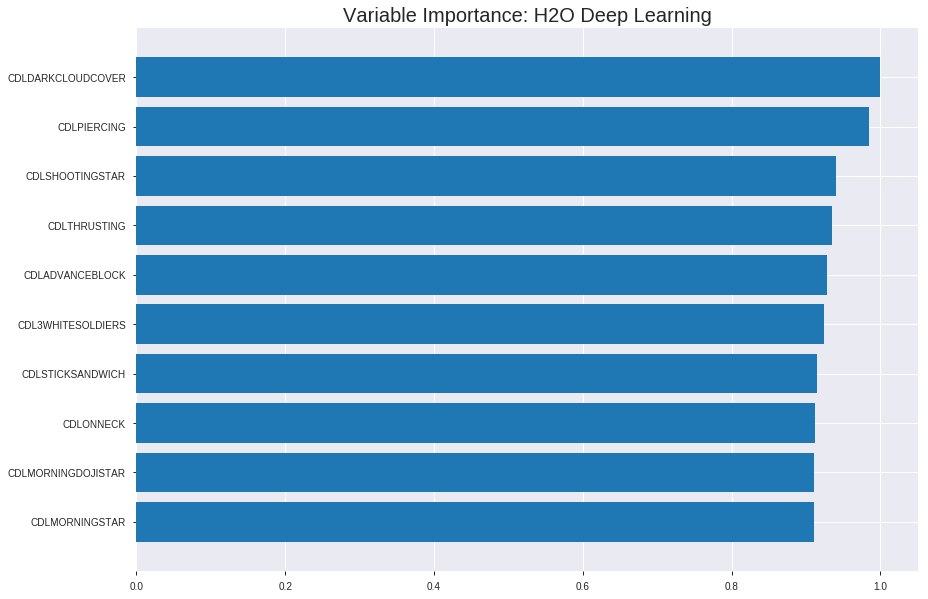

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_155021_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24209274109636936
RMSE: 0.4920292075643166
LogLoss: 0.6769472211478074
Mean Per-Class Error: 0.42658822450912814
AUC: 0.5973620415106254
pr_auc: 0.5886110056955801
Gini: 0.19472408302125088
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38159045242376455: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      87   679   0.8864   (679.0/766.0)
1      32   737   0.0416   (32.0/769.0)
Total  119  1416  0.4632   (711.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.38159      0.6746    338
max f2                       0.288148     0.834604  382
max f0point5                 0.47815      0.582406  249
max accuracy                 0.543147     0.57329   172
max precision                0.845915     1         0
max recall                   0.162257     1         399
max specificity              0.845915     1         0
max absolute_mcc             0.497377     0.148684  227
max min_per_class_accuracy   0.525911     0.569571  191
max mean_per_class_accuracy  0.543147     0.573412  172

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 51.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.725048           1.49707   1.49707            0.75             0.743015  0.75                        0.743015            0.0156047       0.0156047                  49.7074   49.7074
    2        0.0201954                   0.703223           1.59688   1.54537            0.8              0.712353  0.774194                    0.728178            0.0156047       0.0312094                  59.6879   54.5367
    3        0.0306189                   0.687908           1.37232   1.48646            0.6875           0.69585   0.744681                    0.717173            0.0143043       0.0455137                  37.2318   48.6457
    4        0.0403909                   0.677065           1.46381   1.48098            0.733333         0.680534  0.741935                    0.708309            0.0143043       0.0598179                  46.3806   48.0977
    5        0.0501629                   0.668005           1.59688   1.50355            0.8              0.672911  0.753247                    0.701413            0.0156047       0.0754226                  59.6879   50.3555
    6        0.100326                    0.635826           1.01101   1.25728            0.506494         0.652059  0.62987                     0.676736            0.0507152       0.126138                   1.10111   25.7283
    7        0.150489                    0.615451           1.14063   1.2184             0.571429         0.625537  0.61039                     0.65967             0.0572172       0.183355                   14.0628   21.8398
    8        0.2                         0.599505           1.10311   1.18986            0.552632         0.607823  0.596091                    0.646835            0.0546164       0.237971                   10.3107   18.9857
    9        0.300326                    0.572229           1.07582   1.15176            0.538961         0.584797  0.577007                    0.626111            0.107932        0.345904                   7.58195   15.1762
    10       0.4                         0.550872           1.21331   1.1671             0.607843         0.56241   0.584691                    0.610237            0.120936        0.46684                    21.3315   16.71
    11       0.500326                    0.525497           1.03693   1.141              0.519481         0.538402  0.571615                    0.595833            0.104031        0.570871                   3.69345   14.0999
    12       0.6                         0.500684           0.97848   1.114              0.490196         0.512397  0.558089                    0.581972            0.0975293       0.668401                   -2.15202  11.4001
    13       0.699674                    0.473742           0.913248  1.0854             0.457516         0.486882  0.543762                    0.568426            0.0910273       0.759428                   -8.67522  8.5402
    14       0.8                         0.441776           0.894356  1.06144            0.448052         0.458722  0.531759                    0.554668            0.0897269       0.849155                   -10.5644  6.14434
    15       0.899674                    0.393131           0.913248  1.04502            0.457516         0.422082  0.523534                    0.539979            0.0910273       0.940182                   -8.67522  4.50249
    16       1                           0.162257           0.596237  1                  0.298701         0.339361  0.500977                    0.519852            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2630747653018249
RMSE: 0.512908145092106
LogLoss: 0.7207272210028177
Mean Per-Class Error: 0.48
AUC: 0.47191444966092855
pr_auc: 0.4618726456925671
Gini: -0.056171100678142905
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.406938047471495: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    216  0.96     (216.0/225.0)
1      0    213  0        (0.0/213.0)
Total  9    429  0.4932   (216.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406938     0.663551  390
max f2                       0.406938     0.831382  390
max f0point5                 0.406938     0.5521    390
max accuracy                 0.776842     0.515982  0
max precision                0.776842     1         0
max recall                   0.406938     1         390
max specificity              0.776842     1         0
max absolute_mcc             0.406938     0.140926  390
max min_per_class_accuracy   0.553103     0.457778  201
max mean_per_class_accuracy  0.406938     0.52      390

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 55.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.742022           0.822535  0.822535           0.4              0.755271  0.4                         0.755271            0.00938967      0.00938967                 -17.7465  -17.7465
    2        0.0205479                   0.722294           0.514085  0.685446           0.25             0.733706  0.333333                    0.745687            0.00469484      0.0140845                  -48.5915  -31.4554
    3        0.0319635                   0.715931           1.2338    0.881288           0.6              0.717607  0.428571                    0.735658            0.0140845       0.028169                   23.3803   -11.8712
    4        0.0410959                   0.704481           1.02817   0.913928           0.5              0.710074  0.444444                    0.729973            0.00938967      0.0375587                  2.8169    -8.6072
    5        0.0502283                   0.694614           0.514085  0.841229           0.25             0.69894   0.409091                    0.724331            0.00469484      0.0422535                  -48.5915  -15.8771
    6        0.100457                    0.663809           0.841229  0.841229           0.409091         0.67718   0.409091                    0.700756            0.0422535       0.084507                   -15.8771  -15.8771
    7        0.150685                    0.636312           1.12164   0.934699           0.545455         0.648313  0.454545                    0.683275            0.056338        0.140845                   12.1639   -6.53009
    8        0.200913                    0.616799           1.12164   0.981434           0.545455         0.626013  0.477273                    0.668959            0.056338        0.197183                   12.1639   -1.85659
    9        0.30137                     0.588801           0.981434  0.981434           0.477273         0.60252   0.477273                    0.646813            0.0985915       0.295775                   -1.85659  -1.85659
    10       0.399543                    0.569611           0.812971  0.94004            0.395349         0.580292  0.457143                    0.630468            0.0798122       0.375587                   -18.7029  -5.99598
    11       0.5                         0.553379           0.794494  0.910798           0.386364         0.560479  0.442922                    0.616406            0.0798122       0.455399                   -20.5506  -8.92019
    12       0.600457                    0.525976           1.02817   0.930434           0.5              0.538471  0.452471                    0.603368            0.103286        0.558685                   2.8169    -6.95657
    13       0.69863                     0.508165           1.29119   0.981129           0.627907         0.51629   0.477124                    0.591131            0.126761        0.685446                   29.1189   -1.88714
    14       0.799087                    0.488611           1.02817   0.987042           0.5              0.500902  0.48                        0.579788            0.103286        0.788732                   2.8169    -1.29577
    15       0.899543                    0.455031           1.21511   1.01251            0.590909         0.473616  0.492386                    0.567931            0.122066        0.910798                   21.5109   1.25116
    16       1                           0.345432           0.887964  1                  0.431818         0.424776  0.486301                    0.55


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 15:52:48  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 15:52:50  2 min 27.540 sec  471 obs/sec       0.467101  1             717        0.636573         1.90998             -0.620905      0.534665        0.521362           1.24756          0.499023                         0.637911           1.84091               -0.628945        0.563537          0.519719             0.411268           0.458904
    2019-08-26 15:53:00  2 min 37.073 sec  526 obs/sec       3.49837   8             5370       0.631341         3.62783             -0.594372      0.550364        0.558231           1.62183          0.499023                         0.615768           1.48243               -0.51782         0.512092          0.485924             1.2338             0.497717
    2019-08-26 15:53:10  2 min 47.100 sec  523 obs/sec       6.59609   15            10125      0.626765         2.22645             -0.571345      0.539844        0.449536           1.49707          0.499023                         0.645445           2.07358               -0.667647        0.493563          0.472239             1.2338             0.513699
    2019-08-26 15:53:19  2 min 56.696 sec  530 obs/sec       9.69642   22            14884      0.610974         1.541               -0.493163      0.570435        0.559667           1.62183          0.487296                         0.658992           1.76307               -0.738387        0.462713          0.451211             0.411268           0.502283
    2019-08-26 15:53:29  3 min  6.132 sec  535 obs/sec       12.7941   29            19639      0.557796         0.93139             -0.244549      0.578978        0.567972           1.24756          0.478827                         0.565494           0.924124              -0.280093        0.499906          0.472169             0.411268           0.484018
    2019-08-26 15:53:38  3 min 15.541 sec  539 obs/sec       15.8997   36            24406      0.530114         0.784314            -0.124088      0.570909        0.570944           1.62183          0.497068                         0.558087           0.872916              -0.246782        0.474533          0.45484              0.822535           0.513699
    2019-08-26 15:53:47  3 min 24.789 sec  543 obs/sec       18.9655   43            29112      0.603072         1.10401             -0.454789      0.555962        0.553509           1.12281          0.489251                         0.640775           1.33498               -0.643604        0.488638          0.478335             0.822535           0.5
    2019-08-26 15:53:56  3 min 33.928 sec  547 obs/sec       22.0736   50            33883      0.51917          0.740358            -0.0781539     0.555615        0.548317           1.24756          0.496417                         0.565064           0.862105              -0.27815         0.415357          0.427116             1.2338             0.513699
    2019-08-26 15:54:05  3 m

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLDARKCLOUDCOVER        1.0                    1.0                  0.0028386143290803816
CDLPIERCING              0.9843723773956299     0.9843723773956299   0.0027942535356261563
CDLSHOOTINGSTAR          0.9406241774559021     0.9406241774559021   0.0026700692684057713
CDLTHRUSTING             0.9346511363983154     0.9346511363983154   0.0026531141084715206
CDLADVANCEBLOCK          0.9280282855033875     0.9280282855033875   0.002634314389021815
---                      ---                    ---                  ---
T3_8_1                   0.2718912661075592     0.2718912661075592   0.0007717944439247247
CDLMARUBOZU              0.2715606689453125     0.2715606689453125   0.0007708560060828178
BBANDS_upperband_12_0_3  0.2709745466709137     0.2709745466709137   0.0007691922309961163
BBANDS_lowerband_20_7_2  0.2690865397453308     0.2690865397453308   0.0007638329074837537
CDLRISEFALL3METHODS      0.25223565101623535    0.25223565101623535  0.0007159997332796042


See the whole table with table.as_data_frame()


('accuracy', 0.5636363636363636)

('F1', 0.6833855799373041)

('auc', 0.5580357142857143)

('logloss', 0.6939654170439065)

('mean_per_class_error', 0.4371693121693122)

('rmse', 0.5001981501351933)

('mse', 0.2501981893986694)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


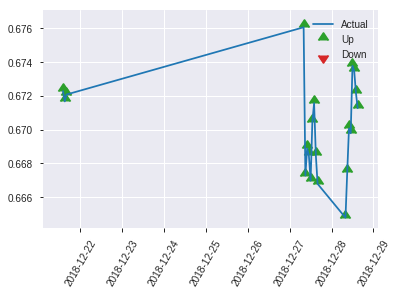


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2501981893986694
RMSE: 0.5001981501351933
LogLoss: 0.6939654170439065
Mean Per-Class Error: 0.4371693121693122
AUC: 0.5580357142857143
pr_auc: 0.5438476964320776
Gini: 0.1160714285714286
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42524859292328276: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   98   0.9074   (98.0/108.0)
1      3    109  0.0268   (3.0/112.0)
Total  13   207  0.4591   (101.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425249     0.683386  206
max f2                       0.344784     0.838323  219
max f0point5                 0.475601     0.584112  185
max accuracy                 0.558259     0.563636  119
max precision                0.73067      1         0
max recall                   0.344784     1         219
max specificity              0.73067      1         0
max absolute_mcc             0.425249     0.13952   206
max min_per_class_accuracy   0.56506      0.537037  110
max mean_per_class_accuracy  0.558259     0.562831  119

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 55.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.72238            1.30952   1.30952            0.666667         0.727944  0.666667                    0.727944            0.0178571       0.0178571                  30.9524   30.9524
    2        0.0227273                   0.706231           0.982143  1.17857            0.5              0.712457  0.6                         0.72175             0.00892857      0.0267857                  -1.78571  17.8571
    3        0.0318182                   0.689913           0         0.841837           0                0.695239  0.428571                    0.714175            0               0.0267857                  -100      -15.8163
    4        0.0409091                   0.682989           0.982143  0.873016           0.5              0.686993  0.444444                    0.708135            0.00892857      0.0357143                  -1.78571  -12.6984
    5        0.05                        0.671951           1.96429   1.07143            1                0.679029  0.545455                    0.702843            0.0178571       0.0535714                  96.4286   7.14286
    6        0.1                         0.649923           1.25      1.16071            0.636364         0.664182  0.590909                    0.683512            0.0625          0.116071                   25        16.0714
    7        0.15                        0.624853           0.535714  0.952381           0.272727         0.638734  0.484848                    0.668586            0.0267857       0.142857                   -46.4286  -4.7619
    8        0.2                         0.610124           1.42857   1.07143            0.727273         0.619832  0.545455                    0.656398            0.0714286       0.214286                   42.8571   7.14286
    9        0.3                         0.59367            1.16071   1.10119            0.590909         0.602512  0.560606                    0.638436            0.116071        0.330357                   16.0714   10.119
    10       0.4                         0.577883           1.07143   1.09375            0.545455         0.587452  0.556818                    0.62569             0.107143        0.4375                     7.14286   9.375
    11       0.5                         0.565397           0.982143  1.07143            0.5              0.573095  0.545455                    0.615171            0.0982143       0.535714                   -1.78571  7.14286
    12       0.6                         0.545563           1.07143   1.07143            0.545455         0.556186  0.545455                    0.60534             0.107143        0.642857                   7.14286   7.14286
    13       0.7                         0.526548           0.803571  1.03316            0.409091         0.536593  0.525974                    0.595519            0.0803571       0.723214                   -19.6429  3.31633
    14       0.8                         0.501465           1.25      1.06027            0.636364         0.513531  0.539773                    0.585271            0.125           0.848214                   25        6.02679
    15       0.9                         0.447372           0.803571  1.03175            0.409091         0.474104  0.525253                    0.572919            0.0803571       0.928571                   -19.6429  3.1746
    16       1                           0.344784           0.714286  1                  0.363636         0.414348  0.509091                    0.557062           

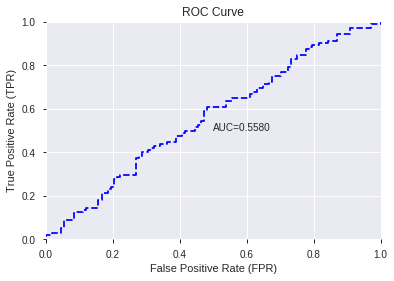

This function is available for GLM models only


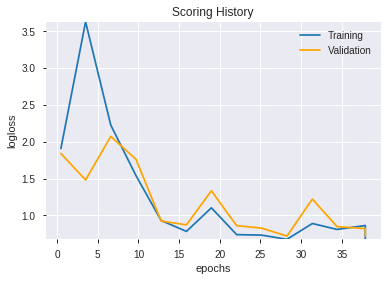

--2019-08-26 16:18:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_155021_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_155021_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_161819_model_2  0.521329  0.822701              0.500000  0.533895  0.285044
1  DeepLearning_grid_1_AutoML_20190826_161819_model_1  0.519511  1.111167              0.500000  0.556799  0.310025
2  DeepLearning_grid_1_AutoML_20190826_161819_model_8  0.511078  0.694349              0.495370  0.500600  0.250601
3  DeepLearning_grid_1_AutoML_20190826_161819_model_3  0.506366  0.820101              0.495370  0.526075  0.276755
4  DeepLearning_grid_1_AutoML_20190826_161819_model_9  0.471892  0.693982              0.490575  0.500417  0.250417
5  DeepLearning_grid_1_AutoML_20190826_161819_model_7  0.462384  0.881077              0.485780  0.556639  0.309847
6  DeepLearning_grid_1_AutoML_20190826_161819_model_5  0.451306  0.712076              0.490741  0.509036  0.259117
7               DeepLearning_1_AutoML_20190826_161819  0.450562  0.727755              0.490741  0.516526  0.266799
8  DeepLearning_grid_1_AutoML_20190826_161819_model_6  0.436012  0.716146              0.495370  0.511084  0.261207
9  DeepLearning_grid_1_AutoML_20190826_161819_model_4  0.425843  0.898980              0.495370  0.568192  0.322842

variable  relative_importance  scaled_importance  percentage
0             CDL2CROWS             1.000000           1.000000    0.028934
1      CDLSTICKSANDWICH             0.926499           0.926499    0.026807
2    CDLEVENINGDOJISTAR             0.879333           0.879333    0.025443
3             CDLONNECK             0.873856           0.873856    0.025284
4             CDLINNECK             0.872153           0.872153    0.025235
5       CDLLADDERBOTTOM             0.863139           0.863139    0.024974
6    CDLMORNINGDOJISTAR             0.862078           0.862078    0.024943
7                  hour             0.860814           0.860814    0.024907
8          HT_TRENDMODE             0.856736           0.856736    0.024789
9        CDLMORNINGSTAR             0.835121           0.835121    0.024164
10    CDLSTALLEDPATTERN             0.830073           0.830073    0.024017
11        days_in_month             0.818248           0.818248    0.023675
12            CORREL_14             0.813278           0.813278    0.023531
13                  BOP             0.797159           0.797159    0.023065
14                  OBV             0.795874           0.795874    0.023028
15               SAREXT             0.792853           0.792853    0.022941
16       is_month_start             0.790818           0.790818    0.022882
17       CDLEVENINGSTAR             0.783589           0.783589    0.022672
18         aroondown_20             0.779041           0.779041    0.022541
19               VAR_30             0.771596           0.771596    0.022325
20            CORREL_12             0.758987           0.758987    0.021961
21    CDLDARKCLOUDCOVER             0.742438           0.742438    0.021482
22         weekday_name             0.741045           0.741045    0.021442
23          HT_DCPERIOD             0.726049           0.726049    0.021008
24          CDLPIERCING             0.701978           0.701978    0.020311
25         CDLTASUKIGAP             0.679182           0.679182    0.019652
26               VAR_24             0.674073           0.674073    0.019504
27               VAR_14             0.655144           0.655144    0.018956
28               VAR_20             0.650287           0.650287    0.018815
29  CDLGAPSIDESIDEWHITE             0.638557           0.638557    0.018476
30   CDLSEPARATINGLINES             0.637237           0.637237    0.018438
31         CDLTHRUSTING             0.625766           0.625766    0.018106
32    CDL3WHITESOLDIERS             0.607334           0.607334    0.017573
33               VAR_12             0.600750           0.600750    0.017382
34       CDL3LINESTRIKE             0.598976           0.598976    0.017331
35            CORREL_20             0.590820           0.590820    0.017095
36       CDLRICKSHAWMAN             0.585295           0.585295    0.016935
37              CDLDOJI             0.575758           0.575758    0.016659
38            CORREL_24             0.568205           0.568205    0.016441
39            CDLHAMMER             0.566698           0.566698    0.016397
40    CDLLONGLEGGEDDOJI             0.566509           0.566509    0.016391
41         is_month_end             0.529687           0.529687    0.015326
42    CDLGRAVESTONEDOJI             0.519486           0.519486    0.015031
43     CDLDRAGONFLYDOJI             0.484838           0.484838    0.014028
44        CDLHANGINGMAN             0.477856           0.477856    0.013826
45    CDLINVERTEDHAMMER             0.476649           0.476649    0.013791
46      CDLADVANCEBLOCK             0.476294           0.476294    0.013781
47            CDLTAKURI             0.474619           0.474619    0.013733
48      CDLSHOOTINGSTAR             0.436220           0.436220    0.012622
49       CDLMATCHINGLOW             0.392233           0.392233    0.011349

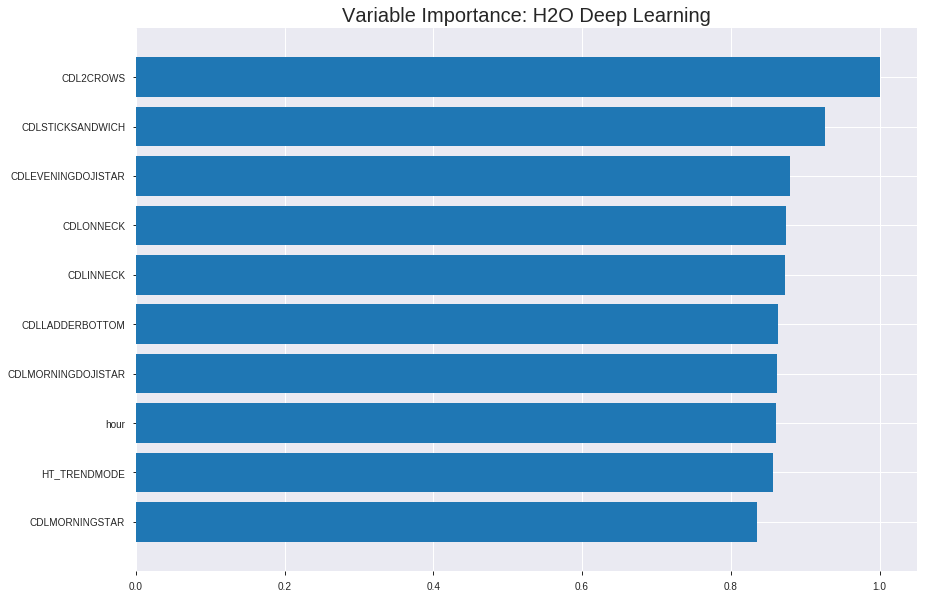

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_161819_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25820391116536956
RMSE: 0.5081376891801764
LogLoss: 0.7511621562834148
Mean Per-Class Error: 0.41982059369769154
AUC: 0.6032638773355244
pr_auc: 0.5888805020844359
Gini: 0.2065277546710489
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14549944958943306: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      47   719   0.9386   (719.0/766.0)
1      16   753   0.0208   (16.0/769.0)
Total  63   1472  0.4788   (735.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.145499     0.672021  368
max f2                       0.00227712   0.834237  398
max f0point5                 0.443841     0.589637  249
max accuracy                 0.475262     0.580456  233
max precision                0.995091     0.846154  2
max recall                   0.00227712   1         398
max specificity              0.999791     0.998695  0
max absolute_mcc             0.443841     0.168279  249
max min_per_class_accuracy   0.559304     0.563069  187
max mean_per_class_accuracy  0.475262     0.580179  233

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 54.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.992898           1.62183   1.62183            0.8125           0.996836  0.8125                      0.996836            0.0169051       0.0169051                  62.183    62.183
    2        0.0201954                   0.976188           1.33073   1.48098            0.666667         0.984925  0.741935                    0.991072            0.0130039       0.029909                   33.0733   48.0977
    3        0.0306189                   0.941919           1.49707   1.48646            0.75             0.959798  0.744681                    0.980426            0.0156047       0.0455137                  49.7074   48.6457
    4        0.0403909                   0.899409           1.19766   1.41659            0.6              0.917976  0.709677                    0.965317            0.0117035       0.0572172                  19.7659   41.6586
    5        0.0501629                   0.875861           1.19766   1.37394            0.6              0.885223  0.688312                    0.949714            0.0117035       0.0689207                  19.7659   37.3938
    6        0.100326                    0.813623           1.29617   1.33505            0.649351         0.8429    0.668831                    0.896307            0.0650195       0.13394                    29.6168   33.5053
    7        0.150489                    0.763605           1.16655   1.27889            0.584416         0.785989  0.640693                    0.859534            0.0585176       0.192458                   16.6551   27.8886
    8        0.2                         0.72873            1.1819    1.25488            0.592105         0.746385  0.628664                    0.831523            0.0585176       0.250975                   18.1901   25.4876
    9        0.300326                    0.664899           1.08878   1.19939            0.545455         0.696805  0.600868                    0.78652             0.109233        0.360208                   8.87812   19.9391
    10       0.4                         0.613634           1.04371   1.1606             0.522876         0.638315  0.581433                    0.749589            0.104031        0.464239                   4.37118   16.0598
    11       0.500326                    0.557335           0.985088  1.1254             0.493506         0.583559  0.563802                    0.716297            0.0988296       0.563069                   -1.49123  12.5405
    12       0.6                         0.501122           1.08285   1.11834            0.542484         0.528655  0.560261                    0.685125            0.107932        0.671001                   8.2851    11.8336
    13       0.699674                    0.440534           1.04371   1.1077             0.522876         0.469502  0.554935                    0.654408            0.104031        0.775033                   4.37118   10.7705
    14       0.8                         0.369122           0.816586  1.0712             0.409091         0.406257  0.536645                    0.623288            0.0819246       0.856957                   -18.3414  7.11964
    15       0.899674                    0.256392           0.769737  1.0378             0.385621         0.315812  0.519913                    0.589223            0.076723        0.93368                    -23.0263  3.77979
    16       1                           6.65942e-06        0.661046  1                  0.331169         0.14953   0.500977                    0.54511           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2883428489095124
RMSE: 0.5369756502016757
LogLoss: 0.8340223370302791
Mean Per-Class Error: 0.4600312989045383
AUC: 0.5094001043296817
pr_auc: 0.478457036132369
Gini: 0.018800208659363493
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2143037560443389: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      26   199  0.8844   (199.0/225.0)
1      11   202  0.0516   (11.0/213.0)
Total  37   401  0.4795   (210.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.214304     0.65798   362
max f2                       0.000153239  0.825581  399
max f0point5                 0.214304     0.555861  362
max accuracy                 0.426549     0.538813  213
max precision                0.993688     1         0
max recall                   0.000153239  1         399
max specificity              0.993688     1         0
max absolute_mcc             0.214304     0.114866  362
max min_per_class_accuracy   0.446524     0.521127  196
max mean_per_class_accuracy  0.426338     0.539969  214

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 45.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.955631           0.822535  0.822535           0.4              0.98296   0.4                         0.98296             0.00938967      0.00938967                 -17.7465  -17.7465
    2        0.0205479                   0.915837           1.54225   1.14241            0.75             0.93944   0.555556                    0.963618            0.0140845       0.0234742                  54.2254   14.241
    3        0.0319635                   0.863999           0.822535  1.02817            0.4              0.898467  0.5                         0.94035             0.00938967      0.0328638                  -17.7465  2.8169
    4        0.0410959                   0.834454           0.514085  0.913928           0.25             0.843122  0.444444                    0.918744            0.00469484      0.0375587                  -48.5915  -8.6072
    5        0.0502283                   0.805885           1.54225   1.02817            0.75             0.822202  0.5                         0.901191            0.0140845       0.0516432                  54.2254   2.8169
    6        0.100457                    0.719098           0.841229  0.934699           0.409091         0.756165  0.454545                    0.828678            0.0422535       0.0938967                  -15.8771  -6.53009
    7        0.150685                    0.677156           0.747759  0.872386           0.363636         0.699808  0.424242                    0.785721            0.0375587       0.131455                   -25.2241  -12.7614
    8        0.200913                    0.613232           0.841229  0.864597           0.409091         0.642081  0.420455                    0.749811            0.0422535       0.173709                   -15.8771  -13.5403
    9        0.30137                     0.552174           1.02817   0.919121           0.5              0.580707  0.44697                     0.693443            0.103286        0.276995                   2.8169    -8.08792
    10       0.399543                    0.482144           1.29119   1.01054            0.627907         0.515892  0.491429                    0.649816            0.126761        0.403756                   29.1189   1.05433
    11       0.5                         0.444944           1.16837   1.04225            0.568182         0.463643  0.506849                    0.612412            0.117371        0.521127                   16.8374   4.22535
    12       0.600457                    0.391244           0.934699  1.02426            0.454545         0.419083  0.498099                    0.580068            0.0938967       0.615023                   -6.53009  2.42596
    13       0.69863                     0.341223           1.0999    1.03489            0.534884         0.370705  0.503268                    0.550647            0.107981        0.723005                   9.99017   3.48891
    14       0.799087                    0.28948            0.934699  1.02229            0.454545         0.315045  0.497143                    0.521029            0.0938967       0.816901                   -6.53009  2.22938
    15       0.899543                    0.228828           1.12164   1.03339            0.545455         0.259375  0.502538                    0.491809            0.112676        0.929577                   12.1639   3.33881
    16       1                           0.000153239        0.701024  1                  0.340909         0.120672  0.486301                    0.454525       


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 16:19:10  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 16:19:13  52.173 sec        4888 obs/sec      7         1             10745      0.508138         0.751162            -0.0328196     0.603264        0.588881           1.62183          0.478827                         0.536976           0.834022              -0.154238        0.5094            0.478457             0.822535           0.479452
    2019-08-26 16:19:19  58.526 sec        6332 obs/sec      35        5             53725      0.507342         0.80185             -0.0295878     0.627796        0.629047           1.74659          0.473616                         0.5748             1.07609               -0.322571        0.537381          0.496476             0.822535           0.490868
    2019-08-26 16:19:24  1 min  3.617 sec  7160 obs/sec      63        9             96705      0.497322         0.741362            0.0106803      0.652327        0.649547           1.9961           0.458632                         0.551317           0.988816              -0.216717        0.552624          0.52173              1.2338             0.497717
    2019-08-26 16:19:30  1 min  9.462 sec  7801 obs/sec      98        14            150430     0.472815         0.65426             0.105779       0.704125        0.700611           1.9961           0.380456                         0.550225           1.02517               -0.211902        0.537089          0.508092             0.822535           0.5
    2019-08-26 16:19:35  1 min 14.780 sec  8321 obs/sec      133       19            204155     0.468984         0.68103             0.120212       0.721502        0.734832           1.9961           0.38241                          0.564422           1.12883               -0.275246        0.52771           0.497773             0.411268           0.502283
    2019-08-26 16:19:40  1 min 19.864 sec  8728 obs/sec      168       24            257880     0.456728         0.624385            0.165595       0.742076        0.743454           1.9961           0.362866                         0.554559           1.10924               -0.231066        0.532801          0.497611             0.411268           0.502283
    2019-08-26 16:19:40  1 min 19.937 sec  8726 obs/sec      168       24            257880     0.508138         0.751162            -0.0328196     0.603264        0.588881           1.62183          0.478827                         0.536976           0.834022              -0.154238        0.5094            0.478457             0.822535           0.479452

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDL2CROWS           1.0                    1.0                  0.02893415593129871
CDLSTICKSANDWICH    0.9264988899230957     0.9264988899230957   0.026807463351210013
CDLEVENINGDOJISTAR  0.8793327212333679     0.8793327212333679   0.02544275007165949
CDLONNECK           0.8738559484481812     0.8738559484481812   0.025284284273892604
CDLINNECK           0.8721531629562378     0.8721531629562378   0.025235015612951158
---                 ---                    ---                  ---
CDLINVERTEDHAMMER   0.4766491949558258     0.4766491949558258   0.013791442131379863
CDLADVANCEBLOCK     0.4762938618659973     0.4762938618659973   0.013781160868351216
CDLTAKURI           0.474618524312973      0.474618524312973    0.013732686390354451
CDLSHOOTINGSTAR     0.43621987104415894    0.43621987104415894  0.01262165376912271
CDLMATCHINGLOW      0.39223334193229675    0.39223334193229675  0.01134894067692348


See the whole table with table.as_data_frame()


('accuracy', 0.55)

('F1', 0.6746987951807228)

('auc', 0.5213293650793651)

('logloss', 0.822701214979262)

('mean_per_class_error', 0.4546957671957672)

('rmse', 0.5338951580203446)

('mse', 0.2850440397575687)

deeplearning prediction progress: |███████████████████████████████████████| 100%


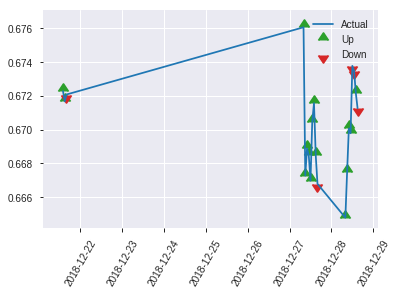


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2850440397575687
RMSE: 0.5338951580203446
LogLoss: 0.822701214979262
Mean Per-Class Error: 0.4546957671957672
AUC: 0.5213293650793651
pr_auc: 0.5104986652850884
Gini: 0.04265873015873023
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.009647766457557454: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    108  1        (108.0/108.0)
1      0    112  0        (0.0/112.0)
Total  0    220  0.4909   (108.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00964777   0.674699  219
max f2                       0.00964777   0.838323  219
max f0point5                 0.309241     0.57971   178
max accuracy                 0.325603     0.55      166
max precision                0.99723      1         0
max recall                   0.00964777   1         219
max specificity              0.99723      1         0
max absolute_mcc             0.086645     0.149751  214
max min_per_class_accuracy   0.424189     0.5       103
max mean_per_class_accuracy  0.325603     0.545304  166

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 43.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.971469           0.654762  0.654762           0.333333         0.988335  0.333333                    0.988335            0.00892857      0.00892857                 -34.5238  -34.5238
    2        0.0227273                   0.945389           1.96429   1.17857            1                0.95205   0.6                         0.973821            0.0178571       0.0267857                  96.4286   17.8571
    3        0.0318182                   0.909471           0.982143  1.12245            0.5              0.937716  0.571429                    0.963505            0.00892857      0.0357143                  -1.78571  12.2449
    4        0.0409091                   0.848395           0.982143  1.09127            0.5              0.874178  0.555556                    0.943655            0.00892857      0.0446429                  -1.78571  9.12698
    5        0.05                        0.771944           0.982143  1.07143            0.5              0.829743  0.545455                    0.922944            0.00892857      0.0535714                  -1.78571  7.14286
    6        0.1                         0.65274            0.714286  0.892857           0.363636         0.707513  0.454545                    0.815228            0.0357143       0.0892857                  -28.5714  -10.7143
    7        0.15                        0.610231           0.892857  0.892857           0.454545         0.632901  0.454545                    0.754452            0.0446429       0.133929                   -10.7143  -10.7143
    8        0.2                         0.555201           1.25      0.982143           0.636364         0.577518  0.5                         0.710219            0.0625          0.196429                   25        -1.78571
    9        0.3                         0.498731           1.25      1.07143            0.636364         0.519349  0.545455                    0.646595            0.125           0.321429                   25        7.14286
    10       0.4                         0.455542           0.982143  1.04911            0.5              0.476656  0.534091                    0.604111            0.0982143       0.419643                   -1.78571  4.91071
    11       0.5                         0.415076           0.803571  1                  0.409091         0.433103  0.509091                    0.569909            0.0803571       0.5                        -19.6429  0
    12       0.6                         0.38613            0.982143  0.997024           0.5              0.399885  0.507576                    0.541572            0.0982143       0.598214                   -1.78571  -0.297619
    13       0.7                         0.34629            1.33929   1.04592            0.681818         0.371416  0.532468                    0.517264            0.133929        0.732143                   33.9286   4.59184
    14       0.8                         0.317163           1.07143   1.04911            0.545455         0.328572  0.534091                    0.493677            0.107143        0.839286                   7.14286   4.91071
    15       0.9                         0.252707           0.625     1.00198            0.318182         0.285787  0.510101                    0.470578            0.0625          0.901786                   -37.5     0.198413
    16       1                           0.00964777         0.982143  1                  0.5              0.144855  0.509091                    0.438006        

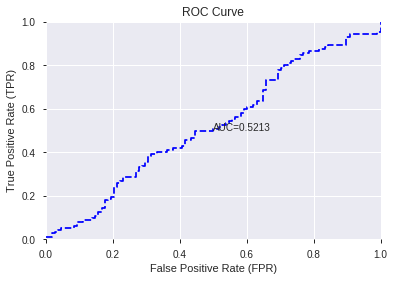

This function is available for GLM models only


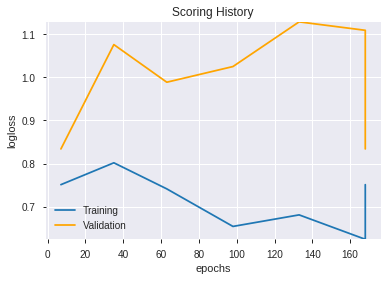

--2019-08-26 16:25:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.132
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.132|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_161819_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_161819_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDL2CROWS',
 'CDLSTICKSANDWICH',
 'CDLEVENINGDOJISTAR',
 'CDLONNECK',
 'CDLINNECK',
 'CDLLADDERBOTTOM',
 'CDLMORNINGDOJISTAR',
 'hour',
 'HT_TRENDMODE',
 'CDLMORNINGSTAR',
 'CDLSTALLEDPATTERN',
 'days_in_month',
 'CORREL_14',
 'BOP',
 'OBV',
 'SAREXT',
 'is_month_start',
 'CDLEVENINGSTAR',
 'aroondown_20',
 'VAR_30',
 'CORREL_12',
 'CDLDARKCLOUDCOVER',
 'weekday_name',
 'HT_DCPERIOD',
 'CDLPIERCING',
 'CDLTASUKIGAP',
 'VAR_24',
 'VAR_14',
 'VAR_20',
 'CDLGAPSIDESIDEWHITE',
 'CDLSEPARATINGLINES',
 'CDLTHRUSTING',
 'CDL3WHITESOLDIERS',
 'VAR_12',
 'CDL3LINESTRIKE',
 'CORREL_20',
 'CDLRICKSHAWMAN',
 'CDLDOJI',
 'CORREL_24',
 'CDLHAMMER',
 'CDLLONGLEGGEDDOJI',
 'is_month_end',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLADVANCEBLOCK',
 'CDLTAKURI',
 'CDLSHOOTINGSTAR',
 'CDLMATCHINGLOW']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_162545_model_1  0.465774  0.694012              0.490741  0.500432  0.250432

variable  relative_importance  scaled_importance  percentage
0             CDLHAMMER             0.009151           1.000000    0.057179
1           HT_DCPERIOD             0.009114           0.995920    0.056945
2          aroondown_20             0.007991           0.873279    0.049933
3                   BOP             0.006460           0.705969    0.040366
4        CDLRICKSHAWMAN             0.005741           0.627347    0.035871
5          HT_TRENDMODE             0.005564           0.608042    0.034767
6               CDLDOJI             0.005322           0.581614    0.033256
7    CDLEVENINGDOJISTAR             0.005015           0.547989    0.031333
8                VAR_14             0.004980           0.544209    0.031117
9           CDLPIERCING             0.004865           0.531648    0.030399
10            CDLINNECK             0.004855           0.530591    0.030338
11            CDLONNECK             0.004854           0.530408    0.030328
12    CDLLONGLEGGEDDOJI             0.004797           0.524247    0.029976
13      CDLADVANCEBLOCK             0.004623           0.505226    0.028888
14        days_in_month             0.004482           0.489801    0.028006
15               VAR_20             0.004105           0.448605    0.025651
16                  OBV             0.004031           0.440526    0.025189
17         is_month_end             0.003946           0.431185    0.024655
18               VAR_24             0.003919           0.428235    0.024486
19         weekday_name             0.003744           0.409140    0.023394
20       is_month_start             0.003666           0.400592    0.022905
21            CDL2CROWS             0.003659           0.399904    0.022866
22            CORREL_24             0.003337           0.364619    0.020848
23               VAR_12             0.003328           0.363694    0.020796
24      CDLSHOOTINGSTAR             0.003189           0.348460    0.019924
25            CORREL_20             0.003145           0.343712    0.019653
26   CDLSEPARATINGLINES             0.003065           0.334938    0.019151
27    CDLDARKCLOUDCOVER             0.002945           0.321780    0.018399
28       CDL3LINESTRIKE             0.002895           0.316347    0.018088
29       CDLEVENINGSTAR             0.002609           0.285098    0.016302
30    CDLGRAVESTONEDOJI             0.002407           0.263080    0.015043
31               VAR_30             0.002255           0.246471    0.014093
32   CDLMORNINGDOJISTAR             0.002199           0.240256    0.013738
33    CDL3WHITESOLDIERS             0.002100           0.229500    0.013123
34         CDLTASUKIGAP             0.002059           0.225029    0.012867
35     CDLDRAGONFLYDOJI             0.001660           0.181456    0.010375
36            CORREL_14             0.001485           0.162306    0.009280
37         CDLTHRUSTING             0.001451           0.158599    0.009068
38               SAREXT             0.001434           0.156748    0.008963
39                 hour             0.001241           0.135664    0.007757
40    CDLINVERTEDHAMMER             0.001002           0.109526    0.006263
41            CDLTAKURI             0.000892           0.097518    0.005576
42       CDLMATCHINGLOW             0.000219           0.023912    0.001367
43    CDLSTALLEDPATTERN             0.000057           0.006268    0.000358
44     CDLSTICKSANDWICH             0.000049           0.005401    0.000309
45        CDLHANGINGMAN             0.000041           0.004517    0.000258
46            CORREL_12             0.000039           0.004218    0.000241
47  CDLGAPSIDESIDEWHITE             0.000025           0.002775    0.000159
48       CDLMORNINGSTAR             0.000023           0.002504    0.000143
49      CDLLADDERBOTTOM             0.000002           0.000169    0.000010

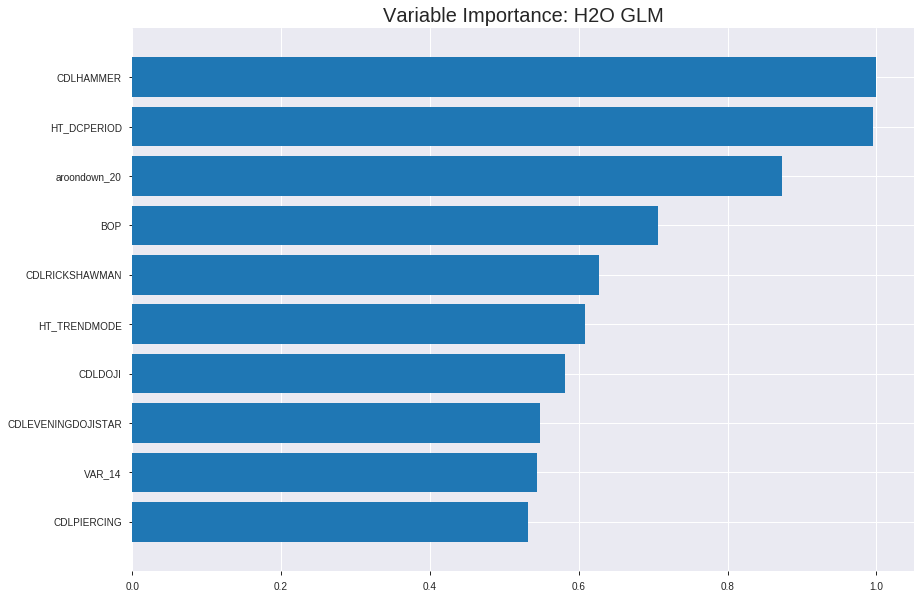

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_162545_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24869269312388792
RMSE: 0.4986909795894527
LogLoss: 0.6905300541457562
Null degrees of freedom: 1534
Residual degrees of freedom: 1484
Null deviance: 2127.955981123116
Residual deviance: 2119.9272662274716
AIC: 2221.9272662274716
AUC: 0.5901946171318758
pr_auc: 0.57892661829267
Gini: 0.18038923426375164
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48956628125856433: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      54   712   0.9295   (712.0/766.0)
1      20   749   0.026    (20.0/769.0)
Total  74   1461  0.4769   (732.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489566     0.671749  347
max f2                       0.478436     0.835325  391
max f0point5                 0.49798      0.581202  250
max accuracy                 0.499755     0.577199  220
max precision                0.569109     1         0
max recall                   0.478436     1         391
max specificity              0.569109     1         0
max absolute_mcc             0.499755     0.154563  220
max min_per_class_accuracy   0.500122     0.565274  214
max mean_per_class_accuracy  0.499755     0.57714   220

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 50.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.534948           1.62183   1.62183            0.8125           0.54375   0.8125                      0.54375             0.0169051       0.0169051                  62.183    62.183
    2        0.0201954                   0.521187           1.33073   1.48098            0.666667         0.526609  0.741935                    0.535456            0.0130039       0.029909                   33.0733   48.0977
    3        0.0306189                   0.518029           1.24756   1.40152            0.625            0.519227  0.702128                    0.529931            0.0130039       0.0429129                  24.7562   40.1516
    4        0.0403909                   0.51503            1.46381   1.41659            0.733333         0.516364  0.709677                    0.526649            0.0143043       0.0572172                  46.3806   41.6586
    5        0.0501629                   0.513665           1.33073   1.39986            0.666667         0.514312  0.701299                    0.524245            0.0130039       0.0702211                  33.0733   39.9862
    6        0.100326                    0.510081           0.959164  1.17951            0.480519         0.511707  0.590909                    0.517976            0.0481144       0.118336                   -4.08356  17.9513
    7        0.150489                    0.507655           1.2184    1.19247            0.61039          0.508793  0.597403                    0.514915            0.0611183       0.179454                   21.8398   19.2475
    8        0.2                         0.505757           1.20817   1.19636            0.605263         0.506731  0.599349                    0.512889            0.0598179       0.239272                   20.8165   19.6359
    9        0.300326                    0.503287           1.15359   1.18207            0.577922         0.504447  0.592191                    0.510069            0.115735        0.355007                   15.359    18.2072
    10       0.4                         0.501538           1.0959    1.1606             0.54902          0.502357  0.581433                    0.508147            0.109233        0.464239                   9.58974   16.0598
    11       0.500326                    0.500124           1.01101   1.1306             0.506494         0.500754  0.566406                    0.506665            0.10143         0.56567                    1.10111   13.0603
    12       0.6                         0.498772           1.03067   1.114              0.51634          0.499431  0.558089                    0.505463            0.102731        0.668401                   3.06654   11.4001
    13       0.699674                    0.497409           0.874109  1.07983            0.437908         0.498102  0.540968                    0.504414            0.0871261       0.755527                   -12.5891  7.98263
    14       0.8                         0.495715           0.868433  1.05332            0.435065         0.496568  0.527687                    0.50343             0.0871261       0.842653                   -13.1567  5.3316
    15       0.899674                    0.492988           0.887155  1.03491            0.444444         0.494545  0.518465                    0.502446            0.0884265       0.931079                   -11.2845  3.49071
    16       1                           0.460176           0.686969  1                  0.344156         0.487805  0.500977                    0.500977           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2506249006934399
RMSE: 0.5006245106798507
LogLoss: 0.694400316677833
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 607.245508785986
Residual deviance: 608.2946774097817
AIC: 710.2946774097817
AUC: 0.4585602503912363
pr_auc: 0.44849373671938253
Gini: -0.08287949921752735
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4701550457603186: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    225  1        (225.0/225.0)
1      0    213  0        (0.0/213.0)
Total  0    438  0.5137   (225.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470155     0.654378  399
max f2                       0.470155     0.825581  399
max f0point5                 0.487251     0.543767  379
max accuracy                 0.520003     0.518265  9
max precision                0.529383     0.666667  2
max recall                   0.470155     1         399
max specificity              0.579583     0.995556  0
max absolute_mcc             0.503436     0.131399  94
max min_per_class_accuracy   0.497697     0.474178  200
max mean_per_class_accuracy  0.489572     0.509609  370

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 49.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.522717           0.822535  0.822535           0.4              0.537771  0.4                         0.537771            0.00938967      0.00938967                 -17.7465  -17.7465
    2        0.0205479                   0.520152           1.54225   1.14241            0.75             0.521535  0.555556                    0.530555            0.0140845       0.0234742                  54.2254   14.241
    3        0.0319635                   0.516308           0.822535  1.02817            0.4              0.518361  0.5                         0.5262              0.00938967      0.0328638                  -17.7465  2.8169
    4        0.0410959                   0.512682           1.02817   1.02817            0.5              0.513765  0.5                         0.523437            0.00938967      0.0422535                  2.8169    2.8169
    5        0.0502283                   0.51153            0         0.841229           0                0.512159  0.409091                    0.521386            0               0.0422535                  -100      -15.8771
    6        0.100457                    0.50748            0.46735   0.654289           0.227273         0.509452  0.318182                    0.515419            0.0234742       0.0657277                  -53.265   -34.5711
    7        0.150685                    0.505549           1.12164   0.810073           0.545455         0.506519  0.393939                    0.512453            0.056338        0.122066                   12.1639   -18.9927
    8        0.200913                    0.504095           0.747759  0.794494           0.363636         0.504777  0.386364                    0.510534            0.0375587       0.159624                   -25.2241  -20.5506
    9        0.30137                     0.501399           0.934699  0.841229           0.454545         0.502734  0.409091                    0.507934            0.0938967       0.253521                   -6.53009  -15.8771
    10       0.399543                    0.499306           1.0999    0.904789           0.534884         0.500458  0.44                        0.506097            0.107981        0.361502                   9.99017   -9.52113
    11       0.5                         0.497674           1.12164   0.948357           0.545455         0.498443  0.461187                    0.504559            0.112676        0.474178                   12.1639   -5.16432
    12       0.600457                    0.496411           1.12164   0.977347           0.545455         0.497109  0.475285                    0.503313            0.112676        0.586854                   12.1639   -2.2653
    13       0.69863                     0.495085           0.956436  0.974409           0.465116         0.495763  0.473856                    0.502252            0.0938967       0.680751                   -4.35637  -2.55915
    14       0.799087                    0.493455           1.0749    0.987042           0.522727         0.494177  0.48                        0.501237            0.107981        0.788732                   7.4904    -1.29577
    15       0.899543                    0.491386           1.16837   1.00729            0.568182         0.492617  0.489848                    0.500274            0.117371        0.906103                   16.8374   0.729249
    16       1                           0.470155           0.934699  1                  0.454545         0.485976  0.486301                    0.498838 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 16:25:45  0.000 sec   2            3.2       51            1.38106           1.3888
    2019-08-26 16:25:45  0.014 sec   4            2         51            1.37857           1.39002
    2019-08-26 16:25:45  0.028 sec   6            1.2       51            1.37526           1.39173
    2019-08-26 16:25:45  0.042 sec   8            0.77      51            1.37116           1.39407
    2019-08-26 16:25:45  0.056 sec   10           0.48      51            1.36645           1.39718

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5181818181818182)

('F1', 0.6787878787878788)

('auc', 0.46577380952380953)

('logloss', 0.6940121573734822)

('mean_per_class_error', 0.4798280423280423)

('rmse', 0.5004321251104031)

('mse', 0.25043231184251413)

glm prediction progress: |████████████████████████████████████████████████| 100%


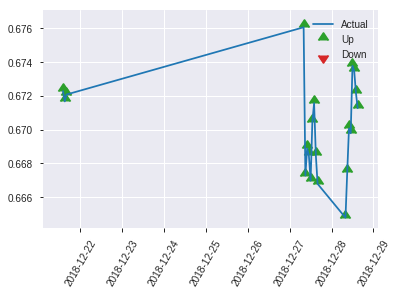


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25043231184251413
RMSE: 0.5004321251104031
LogLoss: 0.6940121573734822
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 304.9699645761388
Residual deviance: 305.36534924433215
AIC: 407.36534924433215
AUC: 0.46577380952380953
pr_auc: 0.482744140431772
Gini: -0.06845238095238093
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4835331438005426: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    106  0.9815   (106.0/108.0)
1      0    112  0        (0.0/112.0)
Total  2    218  0.4818   (106.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483533     0.678788  217
max f2                       0.483533     0.840841  217
max f0point5                 0.483533     0.569106  217
max accuracy                 0.500864     0.518182  85
max precision                0.505435     0.560976  40
max recall                   0.483533     1         217
max specificity              0.524019     0.990741  0
max absolute_mcc             0.515877     0.155297  4
max min_per_class_accuracy   0.498687     0.490741  109
max mean_per_class_accuracy  0.500864     0.520172  85

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 49.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.518484           0         0                  0                0.521599  0                           0.521599            0               0                          -100      -100
    2        0.0227273                   0.515638           0         0                  0                0.516009  0                           0.519363            0               0                          -100      -100
    3        0.0318182                   0.51489            1.96429   0.561224           1                0.51517   0.285714                    0.518165            0.0178571       0.0178571                  96.4286   -43.8776
    4        0.0409091                   0.514451           1.96429   0.873016           1                0.514671  0.444444                    0.517389            0.0178571       0.0357143                  96.4286   -12.6984
    5        0.05                        0.513671           0         0.714286           0                0.514103  0.363636                    0.516791            0               0.0357143                  -100      -28.5714
    6        0.1                         0.50863            0.892857  0.803571           0.454545         0.511367  0.409091                    0.514079            0.0446429       0.0803571                  -10.7143  -19.6429
    7        0.15                        0.506528           1.25      0.952381           0.636364         0.507491  0.484848                    0.511883            0.0625          0.142857                   25        -4.7619
    8        0.2                         0.504897           1.42857   1.07143            0.727273         0.5057    0.545455                    0.510337            0.0714286       0.214286                   42.8571   7.14286
    9        0.3                         0.502329           0.892857  1.0119             0.454545         0.503583  0.515152                    0.508086            0.0892857       0.303571                   -10.7143  1.19048
    10       0.4                         0.500448           1.16071   1.04911            0.590909         0.501472  0.534091                    0.506432            0.116071        0.419643                   16.0714   4.91071
    11       0.5                         0.498619           0.714286  0.982143           0.363636         0.499392  0.5                         0.505024            0.0714286       0.491071                   -28.5714  -1.78571
    12       0.6                         0.497187           0.714286  0.9375             0.363636         0.497812  0.477273                    0.503822            0.0714286       0.5625                     -28.5714  -6.25
    13       0.7                         0.496082           0.803571  0.918367           0.409091         0.496608  0.467532                    0.502792            0.0803571       0.642857                   -19.6429  -8.16327
    14       0.8                         0.494566           1.07143   0.9375             0.545455         0.495414  0.477273                    0.501869            0.107143        0.75                       7.14286   -6.25
    15       0.9                         0.493349           1.42857   0.992063           0.727273         0.49389   0.505051                    0.500983            0.142857        0.892857                   42.8571   -0.793651
    16       1                           0.476897           1.07143   1                  0.545455         0.489398  0.509091                    0.499824           

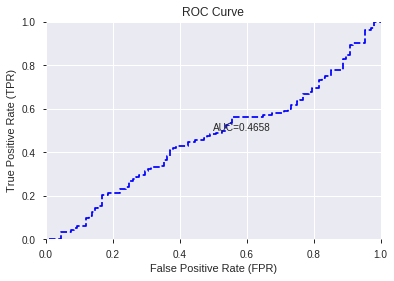

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


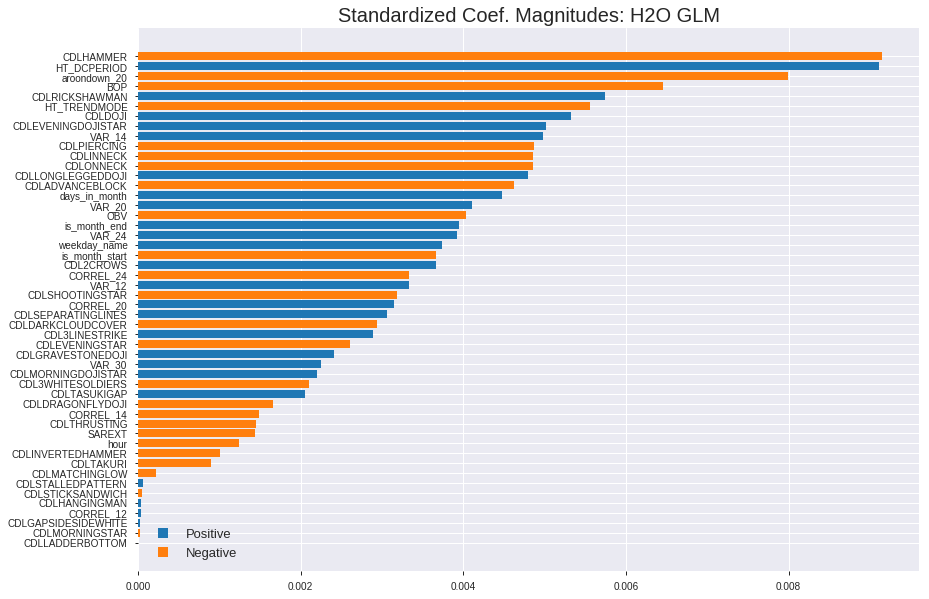

'log_likelihood'
--2019-08-26 16:25:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_162545_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_162545_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLHAMMER',
 'HT_DCPERIOD',
 'aroondown_20',
 'BOP',
 'CDLRICKSHAWMAN',
 'HT_TRENDMODE',
 'CDLDOJI',
 'CDLEVENINGDOJISTAR',
 'VAR_14',
 'CDLPIERCING',
 'CDLINNECK',
 'CDLONNECK',
 'CDLLONGLEGGEDDOJI',
 'CDLADVANCEBLOCK',
 'days_in_month',
 'VAR_20',
 'OBV',
 'is_month_end',
 'VAR_24',
 'weekday_name',
 'is_month_start',
 'CDL2CROWS',
 'CORREL_24',
 'VAR_12',
 'CDLSHOOTINGSTAR',
 'CORREL_20',
 'CDLSEPARATINGLINES',
 'CDLDARKCLOUDCOVER',
 'CDL3LINESTRIKE',
 'CDLEVENINGSTAR',
 'CDLGRAVESTONEDOJI',
 'VAR_30',
 'CDLMORNINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLTASUKIGAP',
 'CDLDRAGONFLYDOJI',
 'CORREL_14',
 'CDLTHRUSTING',
 'SAREXT',
 'hour',
 'CDLINVERTEDHAMMER',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'CDLSTALLEDPATTERN',
 'CDLSTICKSANDWICH',
 'CDLHANGINGMAN',
 'CORREL_12',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGSTAR',
 'CDLLADDERBOTTOM']

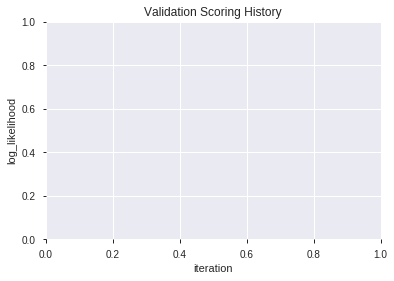

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_162602_model_5  0.514798  0.735477              0.471726  0.518437  0.268777
1               XGBoost_3_AutoML_20190826_162602  0.468006  0.713646              0.495370  0.509915  0.260013
2  XGBoost_grid_1_AutoML_20190826_162602_model_3  0.462467  0.715488              0.490741  0.510764  0.260880
3  XGBoost_grid_1_AutoML_20190826_162602_model_6  0.460400  0.716672              0.481316  0.511364  0.261493
4               XGBoost_2_AutoML_20190826_162602  0.454613  0.720516              0.481151  0.513138  0.263311
5  XGBoost_grid_1_AutoML_20190826_162602_model_2  0.454365  0.713484              0.500000  0.509906  0.260004
6               XGBoost_1_AutoML_20190826_162602  0.448082  0.722554              0.495370  0.514106  0.264305
7  XGBoost_grid_1_AutoML_20190826_162602_model_7  0.444775  0.742170              0.495370  0.522733  0.273250
8  XGBoost_grid_1_AutoML_20190826_162602_model_4  0.431217  0.717113              0.495370  0.511667  0.261803
9  XGBoost_grid_1_AutoML_20190826_162602_model_1  0.409805  0.739386              0.476687  0.522129  0.272619

variable  relative_importance  scaled_importance  percentage
0           HT_DCPERIOD          1856.071411           1.000000    0.086715
1                   BOP          1796.747925           0.968038    0.083944
2                SAREXT          1793.919434           0.966514    0.083812
3                   OBV          1734.099609           0.934285    0.081017
4                VAR_14          1539.849609           0.829628    0.071941
5                VAR_12          1385.770386           0.746615    0.064743
6                VAR_24          1262.402100           0.680147    0.058979
7                VAR_30          1250.663940           0.673823    0.058431
8                VAR_20          1239.809937           0.667975    0.057924
9             CORREL_24          1197.696411           0.645286    0.055956
10                 hour          1031.013550           0.555482    0.048169
11         aroondown_20          1003.013672           0.540396    0.046861
12            CORREL_14           997.007507           0.537160    0.046580
13            CORREL_20           917.940430           0.494561    0.042886
14            CORREL_12           797.546326           0.429696    0.037261
15         weekday_name           471.997681           0.254299    0.022052
16        days_in_month           298.781952           0.160975    0.013959
17         HT_TRENDMODE           148.516434           0.080017    0.006939
18              CDLDOJI           111.329758           0.059981    0.005201
19       CDLRICKSHAWMAN            84.300514           0.045419    0.003939
20            CDLHAMMER            76.339539           0.041130    0.003567
21       is_month_start            56.491196           0.030436    0.002639
22         is_month_end            42.614334           0.022959    0.001991
23    CDLGRAVESTONEDOJI            40.986832           0.022083    0.001915
24    CDLINVERTEDHAMMER            39.375828           0.021215    0.001840
25     CDLDRAGONFLYDOJI            35.141338           0.018933    0.001642
26        CDLHANGINGMAN            28.896519           0.015569    0.001350
27      CDLADVANCEBLOCK            23.603294           0.012717    0.001103
28            CDLTAKURI            21.635660           0.011657    0.001011
29      CDLSHOOTINGSTAR            19.977846           0.010764    0.000933
30    CDLLONGLEGGEDDOJI            17.570248           0.009466    0.000821
31       CDLMATCHINGLOW            14.711393           0.007926    0.000687
32       CDLEVENINGSTAR            13.984657           0.007535    0.000653
33  CDLGAPSIDESIDEWHITE             8.493547           0.004576    0.000397
34       CDL3LINESTRIKE             7.762857           0.004182    0.000363
35         CDLTHRUSTING             7.533677           0.004059    0.000352
36     CDLSTICKSANDWICH             6.999831           0.003771    0.000327
37      CDLLADDERBOTTOM             4.479550           0.002413    0.000209
38   CDLEVENINGDOJISTAR             4.100592           0.002209    0.000192
39    CDL3WHITESOLDIERS             4.044546           0.002179    0.000189
40         CDLTASUKIGAP             2.190288           0.001180    0.000102
41       CDLMORNINGSTAR             2.057099           0.001108    0.000096
42            CDL2CROWS             1.531170           0.000825    0.000072
43    CDLDARKCLOUDCOVER             1.483823           0.000799    0.000069
44          CDLPIERCING             1.475330           0.000795    0.000069
45   CDLSEPARATINGLINES             1.444132           0.000778    0.000067
46    CDLSTALLEDPATTERN             0.793087           0.000427    0.000037

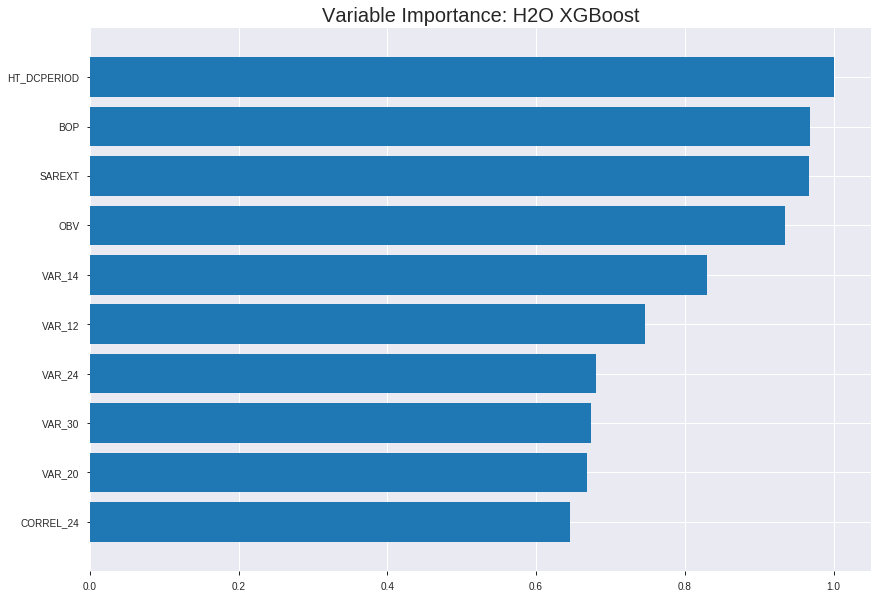

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_162602_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.05108973548595706
RMSE: 0.22603038620052185
LogLoss: 0.24712362059492238
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9986996098829649
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5499263405799866: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      766  0    0        (0.0/766.0)
1      0    769  0        (0.0/769.0)
Total  766  769  0        (0.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.549926     1        196
max f2                       0.549926     1        196
max f0point5                 0.549926     1        196
max accuracy                 0.549926     1        196
max precision                0.9156       1        0
max recall                   0.549926     1        196
max specificity              0.9156       1        0
max absolute_mcc             0.549926     1        196
max min_per_class_accuracy   0.549926     1        196
max mean_per_class_accuracy  0.549926     1        196

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 50.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.890647           1.9961     1.9961             1                0.902372  1                           0.902372            0.0208062       0.0208062                  99.6099   99.6099
    2        0.0201954                   0.882143           1.9961     1.9961             1                0.886495  1                           0.89469             0.0195059       0.0403121                  99.6099   99.6099
    3        0.0306189                   0.874659           1.9961     1.9961             1                0.877559  1                           0.888858            0.0208062       0.0611183                  99.6099   99.6099
    4        0.0403909                   0.867549           1.9961     1.9961             1                0.872227  1                           0.884834            0.0195059       0.0806242                  99.6099   99.6099
    5        0.0501629                   0.863524           1.9961     1.9961             1                0.865856  1                           0.881137            0.0195059       0.10013                    99.6099   99.6099
    6        0.100326                    0.84441            1.9961     1.9961             1                0.854028  1                           0.867583            0.10013         0.20026                    99.6099   99.6099
    7        0.150489                    0.826476           1.9961     1.9961             1                0.835582  1                           0.856916            0.10013         0.30039                    99.6099   99.6099
    8        0.2                         0.807992           1.9961     1.9961             1                0.817237  1                           0.847093            0.0988296       0.39922                    99.6099   99.6099
    9        0.300326                    0.776552           1.9961     1.9961             1                0.793299  1                           0.829123            0.20026         0.59948                    99.6099   99.6099
    10       0.4                         0.731822           1.9961     1.9961             1                0.756191  1                           0.810949            0.19896         0.79844                    99.6099   99.6099
    11       0.500326                    0.577645           1.9961     1.9961             1                0.686469  1                           0.785988            0.20026         0.9987                     99.6099   99.6099
    12       0.6                         0.274722           0.0130464  1.66667            0.00653595       0.322996  0.834962                    0.709074            0.00130039      1                          -98.6954  66.6667
    13       0.699674                    0.225494           0          1.42924            0                0.248374  0.716015                    0.643444            0               1                          -100      42.9236
    14       0.8                         0.192558           0          1.25               0                0.209022  0.626221                    0.588964            0               1                          -100      25
    15       0.899674                    0.160154           0          1.11151            0                0.175353  0.556843                    0.54314             0               1                          -100      11.1513
    16       1                           0.0814354          0          1                  0                0.135263  0.500977                    0.50



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.27512318188403145
RMSE: 0.524521860253728
LogLoss: 0.7486337813685475
Mean Per-Class Error: 0.48294209702660407
AUC: 0.4801147626499739
pr_auc: 0.44964791094162354
Gini: -0.03977047470005224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18867003917694092: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    223  0.9911   (223.0/225.0)
1      0    213  0        (0.0/213.0)
Total  2    436  0.5091   (223.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.18867      0.656394  397
max f2                       0.18867      0.826863  397
max f0point5                 0.211846     0.545455  389
max accuracy                 0.83273      0.515982  0
max precision                0.83273      1         0
max recall                   0.18867      1         397
max specificity              0.83273      1         0
max absolute_mcc             0.651649     0.147139  22
max min_per_class_accuracy   0.428684     0.493333  200
max mean_per_class_accuracy  0.362852     0.517058  279

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 44.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.732144           0.411268  0.411268           0.2              0.773793  0.2                         0.773793            0.00469484      0.00469484                 -58.8732  -58.8732
    2        0.0205479                   0.716842           0.514085  0.456964           0.25             0.727813  0.222222                    0.753357            0.00469484      0.00938967                 -48.5915  -54.3036
    3        0.0319635                   0.690039           0         0.293763           0                0.701334  0.142857                    0.734778            0               0.00938967                 -100      -70.6237
    4        0.0410959                   0.676506           0.514085  0.342723           0.25             0.683008  0.166667                    0.723273            0.00469484      0.0140845                  -48.5915  -65.7277
    5        0.0502283                   0.651864           0.514085  0.37388            0.25             0.666225  0.181818                    0.712901            0.00469484      0.0187793                  -48.5915  -62.612
    6        0.100457                    0.604162           1.12164   0.747759           0.545455         0.62728   0.363636                    0.670091            0.056338        0.0751174                  12.1639   -25.2241
    7        0.150685                    0.579423           0.841229  0.778916           0.409091         0.589828  0.378788                    0.643337            0.0422535       0.117371                   -15.8771  -22.1084
    8        0.200913                    0.554545           0.934699  0.817862           0.454545         0.568062  0.397727                    0.624518            0.0469484       0.164319                   -6.53009  -18.2138
    9        0.30137                     0.517368           1.16837   0.934699           0.568182         0.53554   0.454545                    0.594859            0.117371        0.28169                    16.8374   -6.53009
    10       0.399543                    0.479197           1.05208   0.963541           0.511628         0.497751  0.468571                    0.570998            0.103286        0.384977                   5.20799   -3.64588
    11       0.5                         0.430152           1.0749    0.985915           0.522727         0.455725  0.479452                    0.547838            0.107981        0.492958                   7.4904    -1.40845
    12       0.600457                    0.394762           1.02817   0.992985           0.5              0.411384  0.48289                     0.525009            0.103286        0.596244                   2.8169    -0.701548
    13       0.69863                     0.3639             1.19555   1.02145            0.581395         0.380053  0.496732                    0.50464             0.117371        0.713615                   19.5545   2.1449
    14       0.799087                    0.330127           0.887964  1.00467            0.431818         0.349411  0.488571                    0.485125            0.0892019       0.802817                   -11.2036  0.466801
    15       0.899543                    0.26465            0.841229  0.986416           0.409091         0.302053  0.479695                    0.46468             0.084507        0.887324                   -15.8771  -1.3584
    16       1                           0.117371           1.12164   1                  0.545455         0.228221  0.486301                    0.440


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 16:26:10  3.501 sec   0                  0.5              0.693147            0.5             0                  1                0.499023                         0.5                0.693147              0.5               0                    1                  0.513699
    2019-08-26 16:26:11  3.856 sec   5                  0.454102         0.604974            0.966611        0.965736           1.9961           0.0944625                        0.505176           0.703638              0.455263          0.443908             0.411268           0.513699
    2019-08-26 16:26:11  4.172 sec   10                 0.415532         0.53586             0.99245         0.991413           1.9961           0.037785                         0.505036           0.7034                0.47736           0.482603             1.64507            0.511416
    2019-08-26 16:26:11  4.485 sec   15                 0.381642         0.478208            0.997521        0.996211           1.9961           0.0228013                        0.506879           0.707255              0.475879          0.473258             1.2338             0.513699
    2019-08-26 16:26:12  4.827 sec   20                 0.349583         0.426439            0.999666        0.997063           1.9961           0.00846906                       0.50937            0.712722              0.481732          0.462421             0.822535           0.509132
    2019-08-26 16:26:12  5.158 sec   25                 0.323759         0.386305            0.999927        0.997327           1.9961           0.00456026                       0.51276            0.72002               0.472478          0.450109             0.411268           0.509132
    2019-08-26 16:26:12  5.512 sec   30                 0.299769         0.350055            0.999987        0.998687           1.9961           0.000651466                      0.516881           0.729558              0.473834          0.446829             0.411268           0.509132
    2019-08-26 16:26:13  5.869 sec   35                 0.27978          0.320651            0.999975        0.998675           1.9961           0.00130293                       0.517751           0.732014              0.482567          0.454044             0.822535           0.509132
    2019-08-26 16:26:13  6.242 sec   40                 0.260179         0.293166            0.999999        0.998699           1.9961           0.000651466                      0.520961           0.739509              0.474888          0.448953             0.411268           0.509132
    2019-08-26 16:26:13  6.640 sec   45                 0.24181          0.268065            1               0.997399           1.9961           0                                0.522851           0.744266              0.479489          0.45166              0.411268           0.509132
    2019-08-26 16:26:14  7.049 sec   50                 0.22603          0.247124            1               0.9987             1.9961           0                                0.524522           0.748634              0.480115          0.449648             0.411268           0.509132

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
HT_DCPERIOD         1856.0714111328125     1.0                    0.08671530301013525
BOP                 1796.7479248046875     0.9680381444526867     0.08394372102158379
SAREXT              1793.91943359375       0.9665142315288777     0.08381157445063464
OBV                 1734.099609375         0.9342849628380572     0.08101680365031506
VAR_14              1539.849609375         0.8296284292397923     0.07194148062735113
---                 ---                    ---                    ---
CDL2CROWS           1.531170129776001      0.0008249521654134443  7.153597699269403e-05
CDLDARKCLOUDCOVER   1.4838231801986694     0.0007994429370004953  6.932393652131041e-05
CDLPIERCING         1.475330114364624      0.0007948671077607885  6.89271421022666e-05
CDLSEPARATINGLINES  1.444131851196289      0.0007780583454571367  6.74695651858801e-05
CDLSTALLEDPATTERN   0.7930868268013        0.0004272932722546795  3.7052865577756745e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5454545454545454)

('F1', 0.68125)

('auc', 0.5147982804232805)

('logloss', 0.735477442921593)

('mean_per_class_error', 0.4522156084656085)

('rmse', 0.5184369036329545)

('mse', 0.2687768230485253)

xgboost prediction progress: |████████████████████████████████████████████| 100%


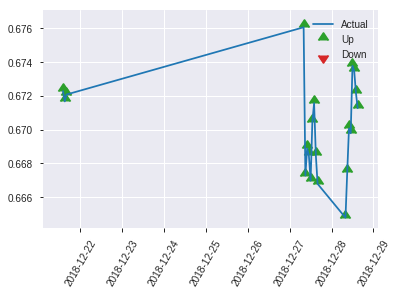


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2687768230485253
RMSE: 0.5184369036329545
LogLoss: 0.735477442921593
Mean Per-Class Error: 0.4522156084656085
AUC: 0.5147982804232805
pr_auc: 0.5174004738935863
Gini: 0.029596560846560926
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24437516927719116: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    99   0.9167   (99.0/108.0)
1      3    109  0.0268   (3.0/112.0)
Total  12   208  0.4636   (102.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.244375     0.68125   207
max f2                       0.195822     0.83958   218
max f0point5                 0.244375     0.577331  207
max accuracy                 0.491238     0.545455  81
max precision                0.582652     0.62069   28
max recall                   0.195822     1         218
max specificity              0.792812     0.990741  0
max absolute_mcc             0.244375     0.124484  207
max min_per_class_accuracy   0.449515     0.5       104
max mean_per_class_accuracy  0.491238     0.547784  81

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 44.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.738673           0         0                  0                0.769756  0                           0.769756            0               0                          -100      -100
    2        0.0227273                   0.727535           1.96429   0.785714           1                0.732738  0.4                         0.754949            0.0178571       0.0178571                  96.4286   -21.4286
    3        0.0318182                   0.712923           0.982143  0.841837           0.5              0.719712  0.428571                    0.744881            0.00892857      0.0267857                  -1.78571  -15.8163
    4        0.0409091                   0.694365           0.982143  0.873016           0.5              0.70215   0.444444                    0.735385            0.00892857      0.0357143                  -1.78571  -12.6984
    5        0.05                        0.673161           0         0.714286           0                0.684094  0.363636                    0.72606             0               0.0357143                  -100      -28.5714
    6        0.1                         0.602651           1.42857   1.07143            0.727273         0.633137  0.545455                    0.679598            0.0714286       0.107143                   42.8571   7.14286
    7        0.15                        0.576083           1.42857   1.19048            0.727273         0.58805   0.606061                    0.649082            0.0714286       0.178571                   42.8571   19.0476
    8        0.2                         0.552702           0.714286  1.07143            0.363636         0.563066  0.545455                    0.627578            0.0357143       0.214286                   -28.5714  7.14286
    9        0.3                         0.509909           1.07143   1.07143            0.545455         0.528365  0.545455                    0.594507            0.107143        0.321429                   7.14286   7.14286
    10       0.4                         0.475215           1.25      1.11607            0.636364         0.495084  0.568182                    0.569651            0.125           0.446429                   25        11.6071
    11       0.5                         0.439499           0.535714  1                  0.272727         0.458855  0.509091                    0.547492            0.0535714       0.5                        -46.4286  0
    12       0.6                         0.395424           1.07143   1.0119             0.545455         0.414507  0.515152                    0.525328            0.107143        0.607143                   7.14286   1.19048
    13       0.7                         0.356572           0.803571  0.982143           0.409091         0.378096  0.5                         0.504295            0.0803571       0.6875                     -19.6429  -1.78571
    14       0.8                         0.330483           0.982143  0.982143           0.5              0.341855  0.5                         0.48399             0.0982143       0.785714                   -1.78571  -1.78571
    15       0.9                         0.276566           1.07143   0.992063           0.545455         0.307139  0.505051                    0.46434             0.107143        0.892857                   7.14286   -0.793651
    16       1                           0.160753           1.07143   1                  0.545455         0.237026  0.509091                    0.441608          

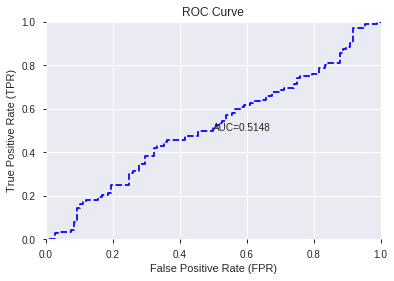

This function is available for GLM models only


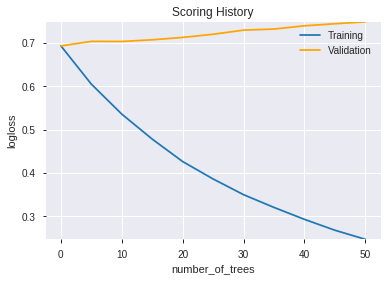

--2019-08-26 16:26:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_162602_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_162602_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_DCPERIOD',
 'BOP',
 'SAREXT',
 'OBV',
 'VAR_14',
 'VAR_12',
 'VAR_24',
 'VAR_30',
 'VAR_20',
 'CORREL_24',
 'hour',
 'aroondown_20',
 'CORREL_14',
 'CORREL_20',
 'CORREL_12',
 'weekday_name',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLHAMMER',
 'is_month_start',
 'is_month_end',
 'CDLGRAVESTONEDOJI',
 'CDLINVERTEDHAMMER',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN',
 'CDLADVANCEBLOCK',
 'CDLTAKURI',
 'CDLSHOOTINGSTAR',
 'CDLLONGLEGGEDDOJI',
 'CDLMATCHINGLOW',
 'CDLEVENINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDL3LINESTRIKE',
 'CDLTHRUSTING',
 'CDLSTICKSANDWICH',
 'CDLLADDERBOTTOM',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLTASUKIGAP',
 'CDLMORNINGSTAR',
 'CDL2CROWS',
 'CDLDARKCLOUDCOVER',
 'CDLPIERCING',
 'CDLSEPARATINGLINES',
 'CDLSTALLEDPATTERN']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190826_162637_model_1  0.531746  0.692375              0.447255  0.49961  0.24961

variable  relative_importance  scaled_importance    percentage
0                  HT_DCPERIOD         9.144034e-03           1.000000  1.370083e-02
1                    CDLHAMMER         9.096280e-03           0.994777  1.362927e-02
2                CDLHIKKAKEMOD         7.886959e-03           0.862525  1.181731e-02
3           CDLCLOSINGMARUBOZU         7.606941e-03           0.831902  1.139775e-02
4                   CDLHIKKAKE         6.771863e-03           0.740577  1.014652e-02
...                        ...                  ...                ...           ...
1033  BBANDS_middleband_12_2_4         1.267481e-06           0.000139  1.899112e-06
1034   BBANDS_upperband_12_3_3         1.258245e-06           0.000138  1.885272e-06
1035                    MIN_20         1.107255e-06           0.000121  1.659038e-06
1036   BBANDS_upperband_12_1_4         7.136955e-07           0.000078  1.069355e-06
1037                    WMA_30         2.227959e-07           0.000024  3.338229e-07

[1038 rows x 4 columns]

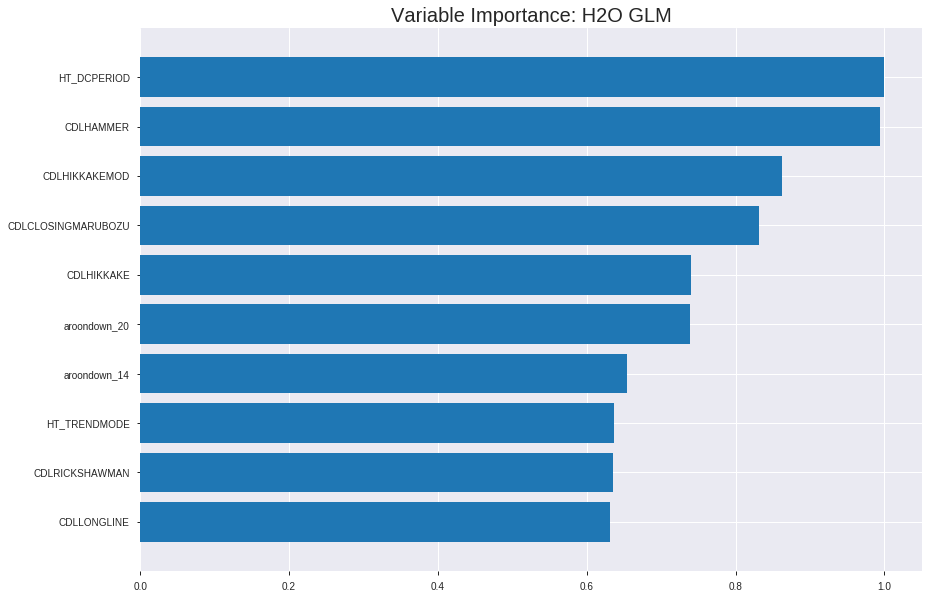

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_162637_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2467856671401529
RMSE: 0.4967752682452629
LogLoss: 0.6867022595809339
Null degrees of freedom: 1534
Residual degrees of freedom: 496
Null deviance: 2127.955981123116
Residual deviance: 2108.175936913467
AIC: 4186.175936913467
AUC: 0.6040371510931086
pr_auc: 0.590229656873709
Gini: 0.20807430218621725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47518376566402654: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      81   685   0.8943   (685.0/766.0)
1      30   739   0.039    (30.0/769.0)
Total  111  1424  0.4658   (715.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475184     0.673963  349
max f2                       0.442239     0.833876  399
max f0point5                 0.492451     0.591178  260
max accuracy                 0.492451     0.581107  260
max precision                0.598356     1         0
max recall                   0.442239     1         399
max specificity              0.598356     1         0
max absolute_mcc             0.492451     0.172084  260
max min_per_class_accuracy   0.50021      0.570871  212
max mean_per_class_accuracy  0.492451     0.580771  260

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 50.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.568187           1.62183   1.62183            0.8125           0.587299  0.8125                      0.587299            0.0169051       0.0169051                  62.183    62.183
    2        0.0201954                   0.545547           1.19766   1.41659            0.6              0.556618  0.709677                    0.572454            0.0117035       0.0286086                  19.7659   41.6586
    3        0.0306189                   0.540162           1.24756   1.35905            0.625            0.543105  0.680851                    0.562463            0.0130039       0.0416125                  24.7562   35.9046
    4        0.0403909                   0.532912           1.72995   1.44878            0.866667         0.535416  0.725806                    0.555919            0.0169051       0.0585176                  72.9952   44.8781
    5        0.0501629                   0.529952           0.931513  1.34801            0.466667         0.531427  0.675325                    0.551148            0.00910273      0.0676203                  -6.84872  34.8015
    6        0.100326                    0.522685           1.14063   1.24432            0.571429         0.525668  0.623377                    0.538408            0.0572172       0.124837                   14.0628   24.4321
    7        0.150489                    0.518315           1.16655   1.2184             0.584416         0.520557  0.61039                     0.532458            0.0585176       0.183355                   16.6551   21.8398
    8        0.2                         0.515076           1.28696   1.23537            0.644737         0.516469  0.618893                    0.5285              0.0637191       0.247074                   28.6958   23.5371
    9        0.300326                    0.509391           1.14063   1.20372            0.571429         0.511951  0.603037                    0.522971            0.114434        0.361508                   14.0628   20.3721
    10       0.4                         0.505409           1.05676   1.1671             0.529412         0.507299  0.584691                    0.519066            0.105332        0.46684                    5.67582   16.71
    11       0.500326                    0.500081           1.03693   1.141              0.519481         0.502833  0.571615                    0.515811            0.104031        0.570871                   3.69345   14.0999
    12       0.6                         0.495416           1.01762   1.1205             0.509804         0.497818  0.561346                    0.512822            0.10143         0.672302                   1.7619    12.0503
    13       0.699674                    0.490761           1.03067   1.1077             0.51634          0.493276  0.554935                    0.510037            0.102731        0.775033                   3.06654   10.7705
    14       0.8                         0.485104           0.725854  1.05982            0.363636         0.488064  0.530945                    0.507282            0.0728218       0.847854                   -27.4146  5.98179
    15       0.899674                    0.478455           0.913248  1.04358            0.457516         0.482016  0.52281                     0.504483            0.0910273       0.938882                   -8.67522  4.35795
    16       1                           0.442239           0.609199  1                  0.305195         0.469542  0.500977                    0.500977            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25236338079347675
RMSE: 0.5023578214713859
LogLoss: 0.6978961288548697
Null degrees of freedom: 437
Residual degrees of freedom: -601
Null deviance: 607.245508785986
Residual deviance: 611.3570088768658
AIC: 2689.3570088768656
AUC: 0.4547209181011998
pr_auc: 0.4500794958331976
Gini: -0.0905581637976004
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4786821426487033: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    216  0.96     (216.0/225.0)
1      1    212  0.0047   (1.0/213.0)
Total  10   428  0.4954   (217.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478682     0.661466  389
max f2                       0.473848     0.828149  395
max f0point5                 0.478682     0.550649  389
max accuracy                 0.607912     0.515982  0
max precision                0.607912     1         0
max recall                   0.473848     1         395
max specificity              0.607912     1         0
max absolute_mcc             0.478682     0.11814   389
max min_per_class_accuracy   0.509458     0.488263  201
max mean_per_class_accuracy  0.478682     0.517653  389

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 51.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.592998           0.822535  0.822535           0.4              0.599791  0.4                         0.599791            0.00938967      0.00938967                 -17.7465  -17.7465
    2        0.0205479                   0.573861           1.02817   0.913928           0.5              0.583441  0.444444                    0.592525            0.00938967      0.0187793                  2.8169    -8.6072
    3        0.0319635                   0.561792           0.822535  0.881288           0.4              0.567116  0.428571                    0.58345             0.00938967      0.028169                   -17.7465  -11.8712
    4        0.0410959                   0.55367            0         0.685446           0                0.557103  0.333333                    0.577595            0               0.028169                   -100      -31.4554
    5        0.0502283                   0.55054            0.514085  0.654289           0.25             0.551623  0.318182                    0.572873            0.00469484      0.0328638                  -48.5915  -34.5711
    6        0.100457                    0.536026           1.02817   0.841229           0.5              0.543067  0.409091                    0.55797             0.0516432       0.084507                   2.8169    -15.8771
    7        0.150685                    0.52915            0.747759  0.810073           0.363636         0.532245  0.393939                    0.549395            0.0375587       0.122066                   -25.2241  -18.9927
    8        0.200913                    0.525574           1.40205   0.958067           0.681818         0.527506  0.465909                    0.543923            0.0704225       0.192488                   40.2049   -4.19334
    9        0.30137                     0.519701           0.841229  0.919121           0.409091         0.522561  0.44697                     0.536802            0.084507        0.276995                   -15.8771  -8.08792
    10       0.399543                    0.514281           0.860793  0.904789           0.418605         0.516927  0.44                        0.531919            0.084507        0.361502                   -13.9207  -9.52113
    11       0.5                         0.509284           1.26184   0.976526           0.613636         0.511858  0.474886                    0.527888            0.126761        0.488263                   26.1844   -2.34742
    12       0.600457                    0.505207           0.701024  0.930434           0.340909         0.507214  0.452471                    0.524429            0.0704225       0.558685                   -29.8976  -6.95657
    13       0.69863                     0.500689           1.00426   0.940808           0.488372         0.503108  0.457516                    0.521433            0.0985915       0.657277                   0.425811  -5.91918
    14       0.799087                    0.49692            1.16837   0.969416           0.568182         0.498829  0.471429                    0.518592            0.117371        0.774648                   16.8374   -3.05835
    15       0.899543                    0.48931            1.0749    0.981197           0.522727         0.493837  0.477157                    0.515827            0.107981        0.882629                   7.4904    -1.88032
    16       1                           0.467572           1.16837   1                  0.568182         0.48236   0.486301                    0.5


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 16:26:40  0.000 sec   2            3.2       1039          1.3734            1.39579
    2019-08-26 16:26:42  1.970 sec   4            2.3       1039          1.37005           1.3976
    2019-08-26 16:26:44  3.966 sec   6            1.7       1039          1.36606           1.39999
    2019-08-26 16:26:46  6.025 sec   8            1.2       1039          1.36146           1.40284
    2019-08-26 16:26:48  8.032 sec   10           0.9       1039          1.35624           1.40619

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5636363636363636)

('F1', 0.6755852842809366)

('auc', 0.5317460317460317)

('logloss', 0.6923752514406492)

('mean_per_class_error', 0.435681216931217)

('rmse', 0.4996101190038648)

('mse', 0.24961027101105596)

glm prediction progress: |████████████████████████████████████████████████| 100%


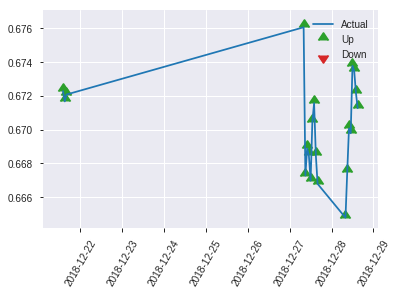


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24961027101105596
RMSE: 0.4996101190038648
LogLoss: 0.6923752514406492
Null degrees of freedom: 219
Residual degrees of freedom: -819
Null deviance: 304.9699645761388
Residual deviance: 304.6451106338856
AIC: 2382.6451106338855
AUC: 0.5317460317460317
pr_auc: 0.5114612672643086
Gini: 0.06349206349206349
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49519889174020554: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      22   86   0.7963   (86.0/108.0)
1      11   101  0.0982   (11.0/112.0)
Total  33   187  0.4409   (97.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495199     0.675585  186
max f2                       0.46814      0.838323  219
max f0point5                 0.495199     0.587209  186
max accuracy                 0.515594     0.563636  101
max precision                0.515594     0.578431  101
max recall                   0.46814      1         219
max specificity              0.569075     0.990741  0
max absolute_mcc             0.495199     0.14769   186
max min_per_class_accuracy   0.513998     0.546296  110
max mean_per_class_accuracy  0.515594     0.564319  101

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.560911           0.654762  0.654762           0.333333         0.564257  0.333333                    0.564257            0.00892857      0.00892857                 -34.5238  -34.5238
    2        0.0227273                   0.554798           0.982143  0.785714           0.5              0.55735   0.4                         0.561494            0.00892857      0.0178571                  -1.78571  -21.4286
    3        0.0318182                   0.550952           0.982143  0.841837           0.5              0.552669  0.428571                    0.558973            0.00892857      0.0267857                  -1.78571  -15.8163
    4        0.0409091                   0.546912           0.982143  0.873016           0.5              0.549017  0.444444                    0.556761            0.00892857      0.0357143                  -1.78571  -12.6984
    5        0.05                        0.546304           1.96429   1.07143            1                0.546621  0.545455                    0.554917            0.0178571       0.0535714                  96.4286   7.14286
    6        0.1                         0.538497           0.714286  0.892857           0.363636         0.543733  0.454545                    0.549325            0.0357143       0.0892857                  -28.5714  -10.7143
    7        0.15                        0.530951           0.892857  0.892857           0.454545         0.533683  0.454545                    0.544111            0.0446429       0.133929                   -10.7143  -10.7143
    8        0.2                         0.528414           0.892857  0.892857           0.454545         0.529748  0.454545                    0.540521            0.0446429       0.178571                   -10.7143  -10.7143
    9        0.3                         0.523284           1.25      1.0119             0.636364         0.525838  0.515152                    0.535626            0.125           0.303571                   25        1.19048
    10       0.4                         0.517449           1.25      1.07143            0.636364         0.520068  0.545455                    0.531737            0.125           0.428571                   25        7.14286
    11       0.5                         0.514264           1.16071   1.08929            0.590909         0.515897  0.554545                    0.528569            0.116071        0.544643                   16.0714   8.92857
    12       0.6                         0.51124            0.892857  1.05655            0.454545         0.512689  0.537879                    0.525922            0.0892857       0.633929                   -10.7143  5.65476
    13       0.7                         0.505209           0.892857  1.03316            0.454545         0.508567  0.525974                    0.523443            0.0892857       0.723214                   -10.7143  3.31633
    14       0.8                         0.500092           1.07143   1.03795            0.545455         0.503352  0.528409                    0.520932            0.107143        0.830357                   7.14286   3.79464
    15       0.9                         0.489265           0.803571  1.0119             0.409091         0.494951  0.515152                    0.518045            0.0803571       0.910714                   -19.6429  1.19048
    16       1                           0.46814            0.892857  1                  0.454545         0.479937  0.509091                    0.514234  

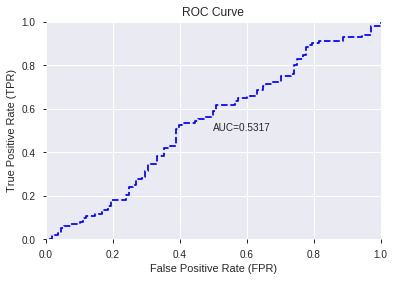

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


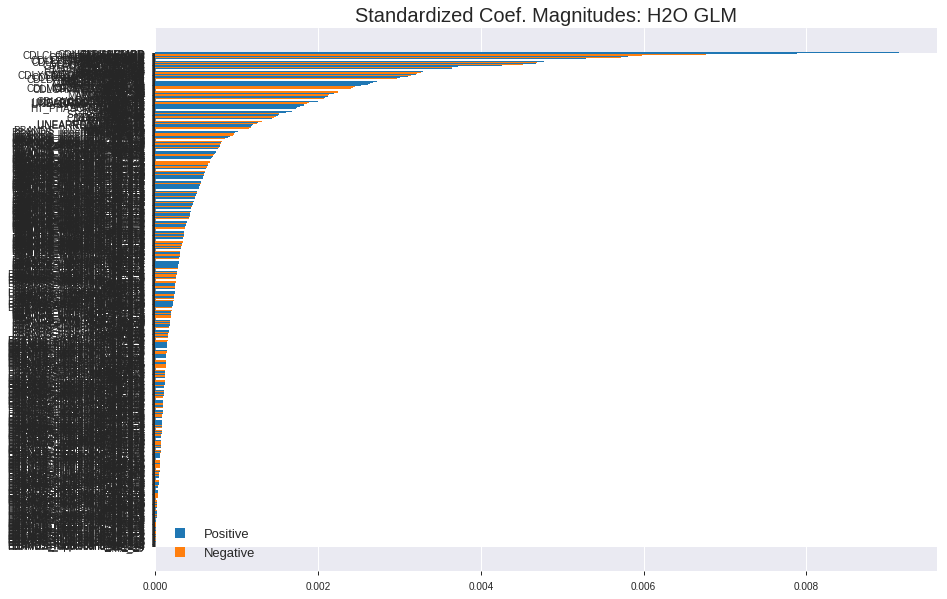

'log_likelihood'
--2019-08-26 16:27:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_162637_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_162637_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

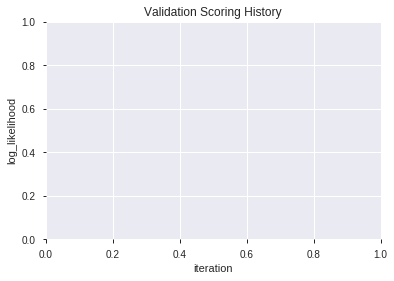

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_162728_model_6  0.567791  0.686861              0.486111  0.496798  0.246808
1  XGBoost_grid_1_AutoML_20190826_162728_model_7  0.566634  0.690354              0.457341  0.498467  0.248469
2               XGBoost_1_AutoML_20190826_162728  0.557126  0.692618              0.466931  0.499592  0.249592
3  XGBoost_grid_1_AutoML_20190826_162728_model_2  0.539269  0.691544              0.423942  0.499230  0.249230
4  XGBoost_grid_1_AutoML_20190826_162728_model_5  0.531250  0.718077              0.443287  0.510893  0.261012
5  XGBoost_grid_1_AutoML_20190826_162728_model_4  0.519428  0.696489              0.500000  0.501597  0.251600
6  XGBoost_grid_1_AutoML_20190826_162728_model_1  0.505870  0.698779              0.476852  0.502884  0.252893
7  XGBoost_grid_1_AutoML_20190826_162728_model_3  0.495536  0.708347              0.500000  0.507327  0.257381
8               XGBoost_3_AutoML_20190826_162728  0.483631  0.708459              0.480985  0.507485  0.257541
9               XGBoost_2_AutoML_20190826_162728  0.457176  0.718993              0.485780  0.512432  0.262587

variable  relative_importance  scaled_importance  percentage
0                        BOP           148.346100           1.000000    0.021915
1                HT_DCPERIOD           133.265472           0.898342    0.019687
2                      MFI_8            95.241859           0.642025    0.014070
3                     ULTOSC            94.652672           0.638053    0.013983
4                    ADXR_14            81.624214           0.550228    0.012058
..                       ...                  ...                ...         ...
304               PLUS_DI_30             3.102733           0.020915    0.000458
305            MINMAX_min_24             3.087141           0.020810    0.000456
306  BBANDS_lowerband_14_0_3             3.084600           0.020793    0.000456
307                  DEMA_20             2.350039           0.015842    0.000347
308                    RSI_8             2.325115           0.015674    0.000343

[309 rows x 4 columns]

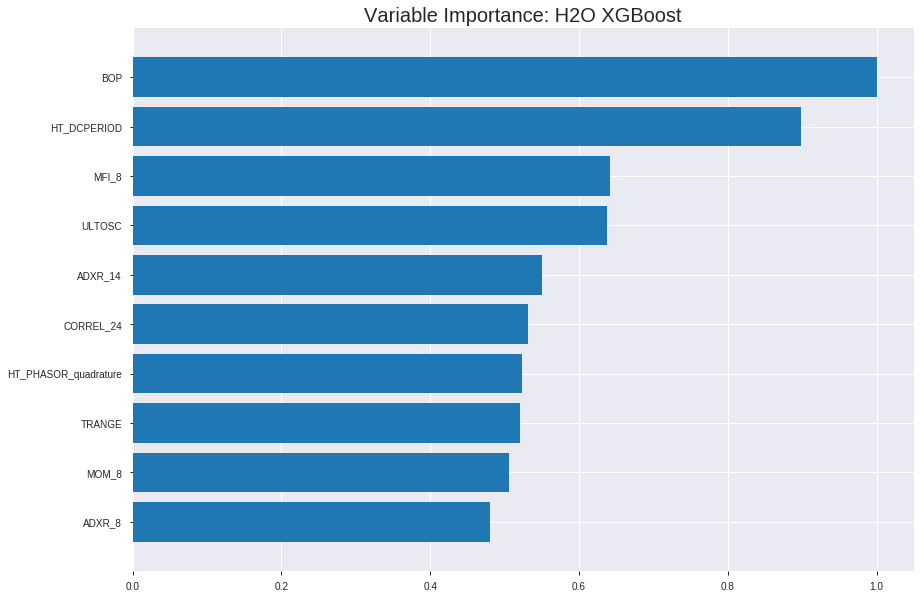

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_162728_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17402084583762942
RMSE: 0.4171580585792745
LogLoss: 0.536823950245652
Mean Per-Class Error: 0.10364584571193813
AUC: 0.9599629236029295
pr_auc: 0.9593683726957152
Gini: 0.9199258472058589
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4855235069990158: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      662  104  0.1358   (104.0/766.0)
1      55   714  0.0715   (55.0/769.0)
Total  717  818  0.1036   (159.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.485524     0.899811  214
max f2                       0.455539     0.932288  242
max f0point5                 0.517989     0.905356  183
max accuracy                 0.485524     0.896417  214
max precision                0.791156     1         0
max recall                   0.3166       1         367
max specificity              0.791156     1         0
max absolute_mcc             0.485524     0.794428  214
max min_per_class_accuracy   0.498181     0.883812  201
max mean_per_class_accuracy  0.485524     0.896354  214

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 49.89 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.736451           1.9961     1.9961             1                0.757082  1                           0.757082            0.0208062       0.0208062                  99.6099   99.6099
    2        0.0201954                   0.725206           1.9961     1.9961             1                0.730163  1                           0.744057            0.0195059       0.0403121                  99.6099   99.6099
    3        0.0306189                   0.714679           1.9961     1.9961             1                0.718282  1                           0.735282            0.0208062       0.0611183                  99.6099   99.6099
    4        0.0403909                   0.701539           1.9961     1.9961             1                0.708426  1                           0.728785            0.0195059       0.0806242                  99.6099   99.6099
    5        0.0501629                   0.691211           1.9961     1.9961             1                0.695818  1                           0.722363            0.0195059       0.10013                    99.6099   99.6099
    6        0.100326                    0.648429           1.9961     1.9961             1                0.671311  1                           0.696837            0.10013         0.20026                    99.6099   99.6099
    7        0.150489                    0.622881           1.9961     1.9961             1                0.635464  1                           0.676379            0.10013         0.30039                    99.6099   99.6099
    8        0.2                         0.603765           1.91731    1.97659            0.960526         0.612736  0.990228                    0.660624            0.0949285       0.395319                   91.7305   97.6593
    9        0.300977                    0.568406           1.89307    1.94857            0.948387         0.587033  0.97619                     0.635935            0.191157        0.586476                   89.3074   94.8573
    10       0.4                         0.534471           1.73345    1.89532            0.868421         0.551885  0.949511                    0.615127            0.171651        0.758127                   73.3454   89.5319
    11       0.500326                    0.498041           1.25728    1.76738            0.62987          0.516837  0.885417                    0.595418            0.126138        0.884265                   25.7283   76.7379
    12       0.6                         0.461031           0.834969   1.61248            0.418301         0.47845   0.807818                    0.575987            0.083225        0.96749                    -16.5031  61.2484
    13       0.699674                    0.422233           0.260928   1.41994            0.130719         0.440635  0.711359                    0.556705            0.0260078       0.993498                   -73.9072  41.9944
    14       0.8                         0.389936           0.0129617  1.2435             0.00649351       0.406956  0.622964                    0.537925            0.00130039      0.994798                   -98.7038  24.3498
    15       0.899674                    0.350516           0.0260928  1.10862            0.0130719        0.371277  0.555395                    0.519463            0.00260078      0.997399                   -97.3907  10.8623
    16       1                           0.210466           0.0259234  1                  0.012987         0.314744  0.500977                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2635367735096473
RMSE: 0.5133583285675293
LogLoss: 0.7211366376276965
Mean Per-Class Error: 0.4928638497652582
AUC: 0.4570266040688576
pr_auc: 0.4545548582183711
Gini: -0.08594679186228482
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2896782159805298: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    223  0.9911   (223.0/225.0)
1      0    213  0        (0.0/213.0)
Total  2    436  0.5091   (223.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.289678     0.656394  397
max f2                       0.289678     0.826863  397
max f0point5                 0.289678     0.5442    397
max accuracy                 0.720955     0.511416  0
max precision                0.370226     0.490148  370
max recall                   0.289678     1         397
max specificity              0.720955     0.995556  0
max absolute_mcc             0.477777     0.101768  234
max min_per_class_accuracy   0.498182     0.469484  197
max mean_per_class_accuracy  0.370226     0.507136  370

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 49.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.698649           0.822535  0.822535           0.4              0.710634  0.4                         0.710634            0.00938967      0.00938967                 -17.7465  -17.7465
    2        0.0205479                   0.678345           1.02817   0.913928           0.5              0.686644  0.444444                    0.699972            0.00938967      0.0187793                  2.8169    -8.6072
    3        0.0319635                   0.659911           0.822535  0.881288           0.4              0.669651  0.428571                    0.689143            0.00938967      0.028169                   -17.7465  -11.8712
    4        0.0410959                   0.651375           0.514085  0.799687           0.25             0.654706  0.388889                    0.68149             0.00469484      0.0328638                  -48.5915  -20.0313
    5        0.0502283                   0.644117           1.02817   0.841229           0.5              0.647152  0.409091                    0.675247            0.00938967      0.0422535                  2.8169    -15.8771
    6        0.100457                    0.612075           0.934699  0.887964           0.454545         0.627437  0.431818                    0.651342            0.0469484       0.0892019                  -6.53009  -11.2036
    7        0.150685                    0.58594            1.02817   0.934699           0.5              0.597646  0.454545                    0.633443            0.0516432       0.140845                   2.8169    -6.53009
    8        0.200913                    0.565726           0.934699  0.934699           0.454545         0.57785   0.454545                    0.619545            0.0469484       0.187793                   -6.53009  -6.53009
    9        0.30137                     0.543225           0.841229  0.903542           0.409091         0.553286  0.439394                    0.597459            0.084507        0.2723                     -15.8771  -9.64575
    10       0.399543                    0.520997           1.00426   0.92829            0.488372         0.532289  0.451429                    0.581445            0.0985915       0.370892                   0.425811  -7.17103
    11       0.5                         0.498044           0.981434  0.938967           0.477273         0.508266  0.456621                    0.566743            0.0985915       0.469484                   -1.85659  -6.10329
    12       0.600457                    0.47618            0.841229  0.922616           0.409091         0.487965  0.448669                    0.553563            0.084507        0.553991                   -15.8771  -7.73845
    13       0.69863                     0.452222           1.0999    0.947528           0.534884         0.462445  0.460784                    0.540759            0.107981        0.661972                   9.99017   -5.24717
    14       0.799087                    0.41779            1.16837   0.975292           0.568182         0.43657   0.474286                    0.527661            0.117371        0.779343                   16.8374   -2.47082
    15       0.899543                    0.382142           1.16837   0.996854           0.568182         0.403554  0.484772                    0.513801            0.117371        0.896714                   16.8374   -0.314578
    16       1                           0.259609           1.02817   1                  0.5              0.343863  0.486301                    0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 16:28:10  25.445 sec  0                  0.5              0.693147            0.5             0                  1                0.499023                         0.5                0.693147              0.5               0                    1                  0.513699
    2019-08-26 16:28:11  26.558 sec  5                  0.488787         0.670919            0.76061         0.757032           1.9961           0.327687                         0.500934           0.69502               0.490339          0.476471             0.822535           0.511416
    2019-08-26 16:28:11  26.772 sec  10                 0.478618         0.65109             0.836886        0.835413           1.9961           0.25798                          0.503156           0.699516              0.469682          0.459379             0.685446           0.509132
    2019-08-26 16:28:11  26.996 sec  15                 0.468929         0.63246             0.873785        0.874664           1.9961           0.207818                         0.50348            0.700231              0.485749          0.468815             0.822535           0.513699
    2019-08-26 16:28:11  27.207 sec  20                 0.460109         0.615687            0.891367        0.891891           1.9961           0.197394                         0.503931           0.701206              0.489369          0.479554             1.2338             0.513699
    2019-08-26 16:28:12  27.421 sec  25                 0.453028         0.602332            0.906267        0.905344           1.9961           0.172638                         0.505747           0.70493               0.475576          0.469159             1.64507            0.513699
    2019-08-26 16:28:12  27.632 sec  30                 0.445773         0.588836            0.919768        0.920404           1.9961           0.169381                         0.507332           0.708208              0.469254          0.461975             1.2338             0.513699
    2019-08-26 16:28:12  27.841 sec  35                 0.439251         0.576762            0.929539        0.930106           1.9961           0.151792                         0.508818           0.711347              0.464674          0.456345             0.411268           0.511416
    2019-08-26 16:28:12  28.067 sec  40                 0.433505         0.566175            0.936968        0.936457           1.9961           0.138762                         0.510378           0.714723              0.463871          0.4568               0.822535           0.509132
    2019-08-26 16:28:12  28.293 sec  45                 0.424897         0.550591            0.948686        0.948241           1.9961           0.12443                          0.511844           0.717882              0.458998          0.456281             0.411268           0.509132
    2019-08-26 16:28:13  28.538 sec  50                 0.417158         0.536824            0.959963        0.959368           1.9961           0.103583                         0.513358           0.721137              0.457027          0.454555             0.822535           0.509132

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      148.34609985351562     1.0                   0.021914936180854674
HT_DCPERIOD              133.26547241210938     0.8983415980851697    0.019687098790643492
MFI_8                    95.24185943603516      0.6420246944819024    0.014069930206103611
ULTOSC                   94.65267181396484      0.6380529849280139    0.013982890444701253
ADXR_14                  81.62421417236328      0.5502282449822619    0.01205821687368994
---                      ---                    ---                   ---
PLUS_DI_30               3.1027326583862305     0.020915498698314442  0.00045836181916431
MINMAX_min_24            3.0871410369873047     0.0208103956897802    0.00045605849343986624
BBANDS_lowerband_14_0_3  3.0846004486083984     0.020793269601656447  0.00045568317631160656
DEMA_20                  2.350038528442383      0.015841592942200226  0.00034716749833139574
RSI_8                    2.3251147270202637     0.015673581774756456  0.0003434855443191946


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5727272727272728)

('F1', 0.6808510638297872)

('auc', 0.5677910052910052)

('logloss', 0.6868614375968842)

('mean_per_class_error', 0.42427248677248675)

('rmse', 0.4967978167932295)

('mse', 0.24680807077051922)

xgboost prediction progress: |████████████████████████████████████████████| 100%


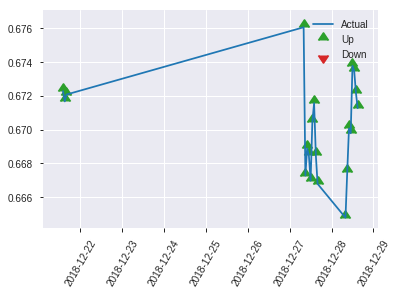


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24680807077051922
RMSE: 0.4967978167932295
LogLoss: 0.6868614375968842
Mean Per-Class Error: 0.42427248677248675
AUC: 0.5677910052910052
pr_auc: 0.5755544717745965
Gini: 0.13558201058201047
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32063475251197815: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    105  0.9722   (105.0/108.0)
1      0    112  0        (0.0/112.0)
Total  3    217  0.4773   (105.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320635     0.680851  216
max f2                       0.320635     0.842105  216
max f0point5                 0.426324     0.57971   178
max accuracy                 0.542828     0.572727  73
max precision                0.689275     0.8       4
max recall                   0.320635     1         216
max specificity              0.728162     0.990741  0
max absolute_mcc             0.573796     0.167984  54
max min_per_class_accuracy   0.496158     0.553571  108
max mean_per_class_accuracy  0.542828     0.575728  73

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 50.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.69939            1.30952   1.30952            0.666667         0.717771  0.666667                    0.717771            0.0178571       0.0178571                  30.9524   30.9524
    2        0.0227273                   0.68672            1.96429   1.57143            1                0.694182  0.8                         0.708336            0.0178571       0.0357143                  96.4286   57.1429
    3        0.0318182                   0.67967            0.982143  1.40306            0.5              0.681801  0.714286                    0.700754            0.00892857      0.0446429                  -1.78571  40.3061
    4        0.0409091                   0.677025           0         1.09127            0                0.678422  0.555556                    0.695791            0               0.0446429                  -100      9.12698
    5        0.05                        0.664247           0.982143  1.07143            0.5              0.672999  0.545455                    0.691647            0.00892857      0.0535714                  -1.78571  7.14286
    6        0.1                         0.623903           1.60714   1.33929            0.818182         0.642752  0.681818                    0.6672              0.0803571       0.133929                   60.7143   33.9286
    7        0.15                        0.606965           1.42857   1.36905            0.727273         0.615644  0.69697                     0.650015            0.0714286       0.205357                   42.8571   36.9048
    8        0.2                         0.589286           0.892857  1.25               0.454545         0.599322  0.636364                    0.637341            0.0446429       0.25                       -10.7143  25
    9        0.3                         0.557612           1.16071   1.22024            0.590909         0.573578  0.621212                    0.616087            0.116071        0.366071                   16.0714   22.0238
    10       0.4                         0.527208           0.892857  1.13839            0.454545         0.54031   0.579545                    0.597143            0.0892857       0.455357                   -10.7143  13.8393
    11       0.5                         0.494046           0.982143  1.10714            0.5              0.509036  0.563636                    0.579521            0.0982143       0.553571                   -1.78571  10.7143
    12       0.6                         0.475322           0.714286  1.04167            0.363636         0.482963  0.530303                    0.563428            0.0714286       0.625                      -28.5714  4.16667
    13       0.7                         0.458409           0.803571  1.00765            0.409091         0.465385  0.512987                    0.549422            0.0803571       0.705357                   -19.6429  0.765306
    14       0.8                         0.434429           1.25      1.03795            0.636364         0.449363  0.528409                    0.536915            0.125           0.830357                   25        3.79464
    15       0.9                         0.393797           0.714286  1.00198            0.363636         0.411699  0.510101                    0.523002            0.0714286       0.901786                   -28.5714  0.198413
    16       1                           0.261866           0.982143  1                  0.5              0.349555  0.509091                    0.505657            

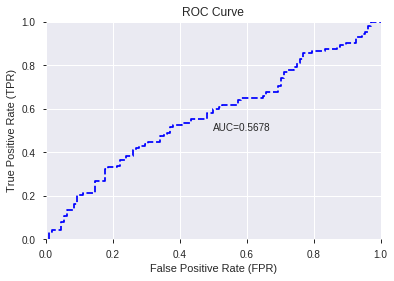

This function is available for GLM models only


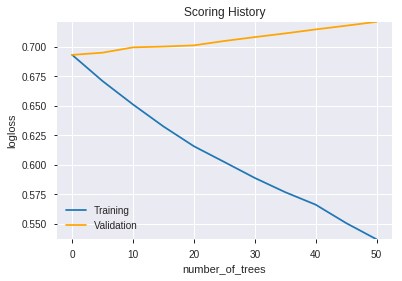

--2019-08-26 16:28:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.jav

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_162728_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_162728_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_162839_model_2  0.535880  0.889426              0.447421  0.542787  0.294618
1               DeepLearning_1_AutoML_20190826_162839  0.518022  0.712043              0.476025  0.508938  0.259018
2  DeepLearning_grid_1_AutoML_20190826_162839_model_3  0.513641  0.863965              0.495370  0.530861  0.281813
3  DeepLearning_grid_1_AutoML_20190826_162839_model_1  0.513145  1.091906              0.495370  0.557240  0.310516
4  DeepLearning_grid_1_AutoML_20190826_162839_model_9  0.493965  0.695180              0.500000  0.501014  0.251015
5  DeepLearning_grid_1_AutoML_20190826_162839_model_7  0.481192  0.780868              0.500000  0.525816  0.276483
6  DeepLearning_grid_1_AutoML_20190826_162839_model_4  0.469990  0.933320              0.500000  0.570654  0.325645
7  DeepLearning_grid_1_AutoML_20190826_162839_model_5  0.469081  0.763005              0.490741  0.526442  0.277141
8  DeepLearning_grid_1_AutoML_20190826_162839_model_8  0.455274  0.708757              0.495205  0.507149  0.257200
9  DeepLearning_grid_1_AutoML_20190826_162839_model_6  0.448578  0.729663              0.495370  0.514030  0.264227

variable  relative_importance  scaled_importance  percentage
0                  hour             1.000000           1.000000    0.034951
1             CDLINNECK             0.964036           0.964036    0.033694
2                   BOP             0.946264           0.946264    0.033073
3             CDLONNECK             0.945999           0.945999    0.033064
4                   OBV             0.930223           0.930223    0.032512
5             CDL2CROWS             0.913164           0.913164    0.031916
6          HT_TRENDMODE             0.904637           0.904637    0.031618
7          weekday_name             0.900649           0.900649    0.031479
8          aroondown_20             0.840437           0.840437    0.029374
9                SAREXT             0.839636           0.839636    0.029346
10        days_in_month             0.815855           0.815855    0.028515
11          HT_DCPERIOD             0.805238           0.805238    0.028144
12            CORREL_14             0.758379           0.758379    0.026506
13      CDLLADDERBOTTOM             0.754337           0.754337    0.026365
14     CDLSTICKSANDWICH             0.745616           0.745616    0.026060
15       CDLEVENINGSTAR             0.729213           0.729213    0.025487
16            CORREL_12             0.728241           0.728241    0.025453
17   CDLEVENINGDOJISTAR             0.670828           0.670828    0.023446
18       CDLMORNINGSTAR             0.662977           0.662977    0.023172
19          CDLPIERCING             0.626929           0.626929    0.021912
20   CDLMORNINGDOJISTAR             0.614565           0.614565    0.021480
21    CDLSTALLEDPATTERN             0.602475           0.602475    0.021057
22               VAR_30             0.594509           0.594509    0.020779
23    CDL3WHITESOLDIERS             0.580002           0.580002    0.020272
24  CDLGAPSIDESIDEWHITE             0.524040           0.524040    0.018316
25       is_month_start             0.494038           0.494038    0.017267
26               VAR_24             0.494023           0.494023    0.017267
27       CDL3LINESTRIKE             0.482416           0.482416    0.016861
28               VAR_20             0.481282           0.481282    0.016821
29               VAR_12             0.464054           0.464054    0.016219
30    CDLDARKCLOUDCOVER             0.443912           0.443912    0.015515
31      CDLADVANCEBLOCK             0.436167           0.436167    0.015245
32               VAR_14             0.419366           0.419366    0.014657
33            CORREL_24             0.408656           0.408656    0.014283
34       CDLRICKSHAWMAN             0.401056           0.401056    0.014017
35            CDLHAMMER             0.388574           0.388574    0.013581
36            CORREL_20             0.386855           0.386855    0.013521
37    CDLLONGLEGGEDDOJI             0.384707           0.384707    0.013446
38              CDLDOJI             0.381383           0.381383    0.013330
39   CDLSEPARATINGLINES             0.362583           0.362583    0.012673
40      CDLSHOOTINGSTAR             0.328504           0.328504    0.011482
41    CDLINVERTEDHAMMER             0.320002           0.320002    0.011184
42         CDLTASUKIGAP             0.317976           0.317976    0.011114
43         CDLTHRUSTING             0.313873           0.313873    0.010970
44    CDLGRAVESTONEDOJI             0.283588           0.283588    0.009912
45         is_month_end             0.273866           0.273866    0.009572
46        CDLHANGINGMAN             0.251807           0.251807    0.008801
47     CDLDRAGONFLYDOJI             0.237806           0.237806    0.008312
48       CDLMATCHINGLOW             0.232620           0.232620    0.008130
49            CDLTAKURI             0.223965           0.223965    0.007828

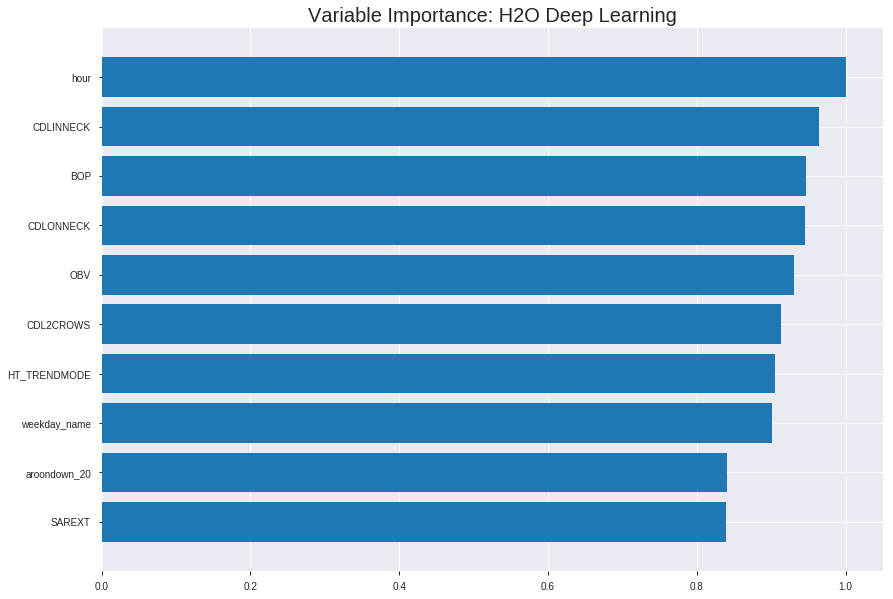

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_162839_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24609127072807357
RMSE: 0.496075871947098
LogLoss: 0.7271452901691804
Mean Per-Class Error: 0.3913554614687278
AUC: 0.6475076987848313
pr_auc: 0.6302977104850102
Gini: 0.29501539756966255
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26398201627480955: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      191  575   0.7507   (575.0/766.0)
1      75   694   0.0975   (75.0/769.0)
Total  266  1269  0.4235   (650.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.263982     0.68106   312
max f2                       0.00152459   0.834601  398
max f0point5                 0.399305     0.607308  255
max accuracy                 0.589479     0.608469  160
max precision                0.993885     0.933333  2
max recall                   5.0649e-05   1         399
max specificity              0.999446     0.998695  0
max absolute_mcc             0.589479     0.220862  160
max min_per_class_accuracy   0.532816     0.596606  191
max mean_per_class_accuracy  0.589479     0.608645  160

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 51.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.989816           1.74659   1.74659            0.875            0.99694    0.875                       0.99694             0.0182055       0.0182055                  74.6586   74.6586
    2        0.0201954                   0.946997           1.33073   1.54537            0.666667         0.970043   0.774194                    0.983926            0.0130039       0.0312094                  33.0733   54.5367
    3        0.0306189                   0.921383           1.74659   1.61387            0.875            0.932623   0.808511                    0.966461            0.0182055       0.0494148                  74.6586   61.3867
    4        0.0403909                   0.904683           1.33073   1.54537            0.666667         0.911491   0.774194                    0.953162            0.0130039       0.0624187                  33.0733   54.5367
    5        0.0501629                   0.891695           1.46381   1.52948            0.733333         0.898429   0.766234                    0.9425              0.0143043       0.076723                   46.3806   52.9478
    6        0.100326                    0.83021            1.39986   1.46467            0.701299         0.860169   0.733766                    0.901334            0.0702211       0.146944                   39.9862   46.467
    7        0.150489                    0.777059           1.24432   1.39122            0.623377         0.802546   0.69697                     0.868405            0.0624187       0.209363                   24.4321   39.122
    8        0.2                         0.738891           1.23443   1.35241            0.618421         0.757032   0.677524                    0.840834            0.0611183       0.270481                   23.443    35.2406
    9        0.300326                    0.659016           1.2184    1.30764            0.61039          0.697129   0.655098                    0.792828            0.122237        0.392718                   21.8398   30.764
    10       0.4                         0.596992           1.13504   1.26463            0.568627         0.629143   0.63355                     0.75204             0.113134        0.505852                   13.5037   26.4629
    11       0.500326                    0.53249            0.907318  1.19298            0.454545         0.565908   0.597656                    0.714717            0.0910273       0.596879                   -9.26824  19.2981
    12       0.6                         0.460109           0.97848   1.15735            0.490196         0.491484   0.579805                    0.677633            0.0975293       0.694408                   -2.15202  15.7347
    13       0.699674                    0.387206           1.01762   1.13744            0.509804         0.42694    0.569832                    0.641919            0.10143         0.795839                   1.7619    13.7442
    14       0.8                         0.294838           0.842509  1.10046            0.422078         0.339699   0.551303                    0.604019            0.0845254       0.880364                   -15.7491  10.0455
    15       0.899674                    0.169954           0.665366  1.05225            0.333333         0.234421   0.527154                    0.563071            0.0663199       0.946684                   -33.4634  5.2252
    16       1                           7.67409e-10        0.531429  1                  0.266234         0.0721911  0.500977                    0.5



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.29534749190835446
RMSE: 0.5434588226428516
LogLoss: 0.9528893384354413
Mean Per-Class Error: 0.4594053208137715
AUC: 0.5441105894627022
pr_auc: 0.5143849380840178
Gini: 0.08822117892540438
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.014672270045074676: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   214  0.9511   (214.0/225.0)
1      3    210  0.0141   (3.0/213.0)
Total  14   424  0.4954   (217.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0146723    0.659341   392
max f2                       2.89778e-07  0.825581   399
max f0point5                 0.192412     0.551767   323
max accuracy                 0.678669     0.541096   77
max precision                0.819324     0.606061   32
max recall                   2.89778e-07  1          399
max specificity              1            0.995556   0
max absolute_mcc             0.0146723    0.0988936  392
max min_per_class_accuracy   0.413774     0.525822   203
max mean_per_class_accuracy  0.366377     0.540595   232

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 41.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.965765           0.822535  0.822535           0.4              0.990614   0.4                         0.990614            0.00938967      0.00938967                 -17.7465  -17.7465
    2        0.0205479                   0.89244            1.02817   0.913928           0.5              0.920933   0.444444                    0.959645            0.00938967      0.0187793                  2.8169    -8.6072
    3        0.0319635                   0.868737           0.822535  0.881288           0.4              0.879288   0.428571                    0.930946            0.00938967      0.028169                   -17.7465  -11.8712
    4        0.0410959                   0.857806           1.54225   1.02817            0.75             0.864795   0.5                         0.916246            0.0140845       0.0422535                  54.2254   2.8169
    5        0.0502283                   0.840491           1.54225   1.12164            0.75             0.847381   0.545455                    0.903725            0.0140845       0.056338                   54.2254   12.1639
    6        0.100457                    0.760227           1.02817   1.0749             0.5              0.805276   0.522727                    0.8545              0.0516432       0.107981                   2.8169    7.4904
    7        0.150685                    0.70437            1.21511   1.12164            0.590909         0.729259   0.545455                    0.812753            0.0610329       0.169014                   21.5109   12.1639
    8        0.200913                    0.636987           1.12164   1.12164            0.545455         0.678581   0.545455                    0.77921             0.056338        0.225352                   12.1639   12.1639
    9        0.30137                     0.537439           1.0749    1.10606            0.522727         0.582772   0.537879                    0.713731            0.107981        0.333333                   7.4904    10.6061
    10       0.399543                    0.471785           0.860793  1.04579            0.418605         0.505102   0.508571                    0.662468            0.084507        0.41784                    -13.9207  4.57948
    11       0.5                         0.411942           1.0749    1.05164            0.522727         0.440139   0.511416                    0.617799            0.107981        0.525822                   7.4904    5.16432
    12       0.600457                    0.332261           1.0749    1.05553            0.522727         0.373494   0.513308                    0.576927            0.107981        0.633803                   7.4904    5.55347
    13       0.69863                     0.27802            0.908614  1.03489            0.44186          0.302453   0.503268                    0.538357            0.0892019       0.723005                   -9.13855  3.48891
    14       0.799087                    0.192118           1.12164   1.04579            0.545455         0.234196   0.508571                    0.500119            0.112676        0.835681                   12.1639   4.57948
    15       0.899543                    0.0934995          0.794494  1.01773            0.386364         0.140355   0.494924                    0.459943            0.0798122       0.915493                   -20.5506  1.77307
    16       1                           3.54948e-08        0.841229  1                  0.409091         0.0365559  0.486301                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 16:29:39  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 16:29:42  1 min  1.606 sec  5251 obs/sec      10        1             15350      0.510474         0.762721            -0.0423401     0.60929         0.596835           1.62183          0.461238                         0.562809           0.958387              -0.267968        0.492686          0.468739             0.822535           0.5
    2019-08-26 16:29:48  1 min  7.842 sec  6753 obs/sec      40        4             61400      0.496076         0.727145            0.0156312      0.647508        0.630298           1.74659          0.423453                         0.543459           0.952889              -0.182277        0.544111          0.514385             0.822535           0.495434
    2019-08-26 16:29:53  1 min 13.052 sec  7548 obs/sec      70        7             107450     0.492684         0.737939            0.0290481      0.661133        0.650219           1.9961           0.454072                         0.549342           1.01474               -0.208012        0.548461          0.512385             0.411268           0.502283
    2019-08-26 16:30:00  1 min 19.365 sec  8244 obs/sec      110       11            168850     0.490789         0.811864            0.036501       0.682514        0.687636           1.87134          0.433225                         0.562748           1.18937               -0.267692        0.559948          0.528394             0.822535           0.493151
    2019-08-26 16:30:05  1 min 25.268 sec  8749 obs/sec      150       15            230250     0.478807         0.744756            0.0829703      0.701692        0.70511            1.9961           0.40456                          0.557406           1.1379                -0.243738        0.540376          0.513875             0                  0.502283
    2019-08-26 16:30:11  1 min 30.905 sec  9148 obs/sec      190       19            291650     0.468686         0.701689            0.12133        0.723178        0.72265            1.9961           0.390879                         0.547841           1.10523               -0.201419        0.549338          0.527536             0.822535           0.502283
    2019-08-26 16:30:11  1 min 30.980 sec  9146 obs/sec      190       19            291650     0.496076         0.727145            0.0156312      0.647508        0.630298           1.74659          0.423453                         0.543459           0.952889              -0.182277        0.544111          0.514385             0.822535           0.495434

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  --------------------
hour              1.0                    1.0                  0.0349511910255605
CDLINNECK         0.9640363454818726     0.9640363454818726   0.03369421846652017
BOP               0.9462635517120361     0.9462635517120361   0.03307303815641272
CDLONNECK         0.9459992051124573     0.9459992051124573   0.03306379892791388
OBV               0.930222749710083      0.930222749710083    0.03251239302143926
---               ---                    ---                  ---
is_month_end      0.2738657295703888     0.2738657295703888   0.00957193342956915
CDLHANGINGMAN     0.2518065869808197     0.2518065869808197   0.008800940123061044
CDLDRAGONFLYDOJI  0.23780584335327148    0.23780584335327148  0.008311597458034708
CDLMATCHINGLOW    0.23261971771717072    0.23261971771717072  0.008130336190244794
CDLTAKURI         0.22396542131900787    0.22396542131900787  0.007827858223640785


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5590909090909091)

('F1', 0.6777408637873754)

('auc', 0.5358796296296297)

('logloss', 0.8894258059528525)

('mean_per_class_error', 0.4464285714285714)

('rmse', 0.5427867951133496)

('mse', 0.2946175049494214)

deeplearning prediction progress: |███████████████████████████████████████| 100%


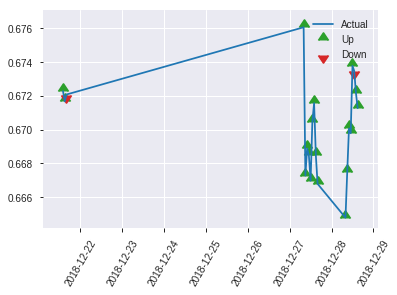


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2946175049494214
RMSE: 0.5427867951133496
LogLoss: 0.8894258059528525
Mean Per-Class Error: 0.4464285714285714
AUC: 0.5358796296296297
pr_auc: 0.524019750482229
Gini: 0.0717592592592593
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16192138535437947: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      21   87   0.8056   (87.0/108.0)
1      10   102  0.0893   (10.0/112.0)
Total  31   189  0.4409   (97.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.161921     0.677741  188
max f2                       0.000464349  0.838323  219
max f0point5                 0.161921     0.587558  188
max accuracy                 0.224151     0.559091  176
max precision                0.999294     1         0
max recall                   0.000464349  1         219
max specificity              0.999294     1         0
max absolute_mcc             0.161921     0.151097  188
max min_per_class_accuracy   0.424288     0.5       109
max mean_per_class_accuracy  0.224151     0.553571  176

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 43.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.934055           0.654762  0.654762           0.333333         0.963653   0.333333                    0.963653            0.00892857      0.00892857                 -34.5238  -34.5238
    2        0.0227273                   0.909965           1.96429   1.17857            1                0.918465   0.6                         0.945578            0.0178571       0.0267857                  96.4286   17.8571
    3        0.0318182                   0.870617           0.982143  1.12245            0.5              0.894408   0.571429                    0.930958            0.00892857      0.0357143                  -1.78571  12.2449
    4        0.0409091                   0.830467           0         0.873016           0                0.854808   0.444444                    0.914036            0               0.0357143                  -100      -12.6984
    5        0.05                        0.806955           0         0.714286           0                0.824112   0.363636                    0.897686            0               0.0357143                  -100      -28.5714
    6        0.1                         0.752687           1.60714   1.16071            0.818182         0.783333   0.590909                    0.840509            0.0803571       0.116071                   60.7143   16.0714
    7        0.15                        0.681762           0.892857  1.07143            0.454545         0.721611   0.545455                    0.800877            0.0446429       0.160714                   -10.7143  7.14286
    8        0.2                         0.627742           1.25      1.11607            0.636364         0.655816   0.568182                    0.764612            0.0625          0.223214                   25        11.6071
    9        0.3                         0.567449           0.982143  1.07143            0.5              0.589898   0.545455                    0.706374            0.0982143       0.321429                   -1.78571  7.14286
    10       0.4                         0.492915           0.892857  1.02679            0.454545         0.539281   0.522727                    0.664601            0.0892857       0.410714                   -10.7143  2.67857
    11       0.5                         0.424245           0.892857  1                  0.454545         0.461399   0.509091                    0.62396             0.0892857       0.5                        -10.7143  0
    12       0.6                         0.356053           1.16071   1.02679            0.590909         0.391887   0.522727                    0.585281            0.116071        0.616071                   16.0714   2.67857
    13       0.7                         0.290995           1.25      1.05867            0.636364         0.330053   0.538961                    0.54882             0.125           0.741071                   25        5.86735
    14       0.8                         0.224447           1.07143   1.06027            0.545455         0.254697   0.539773                    0.512055            0.107143        0.848214                   7.14286   6.02679
    15       0.9                         0.117195           0.803571  1.03175            0.409091         0.172218   0.525253                    0.474295            0.0803571       0.928571                   -19.6429  3.1746
    16       1                           0.000464349        0.714286  1                  0.363636         0.0485143  0.509091                    0.4

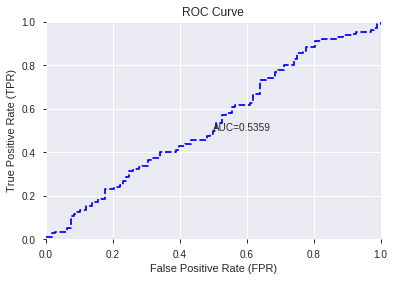

This function is available for GLM models only


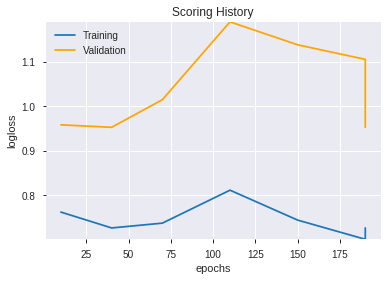

--2019-08-26 16:36:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_162839_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_162839_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['hour',
 'CDLINNECK',
 'BOP',
 'CDLONNECK',
 'OBV',
 'CDL2CROWS',
 'HT_TRENDMODE',
 'weekday_name',
 'aroondown_20',
 'SAREXT',
 'days_in_month',
 'HT_DCPERIOD',
 'CORREL_14',
 'CDLLADDERBOTTOM',
 'CDLSTICKSANDWICH',
 'CDLEVENINGSTAR',
 'CORREL_12',
 'CDLEVENINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLPIERCING',
 'CDLMORNINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'VAR_30',
 'CDL3WHITESOLDIERS',
 'CDLGAPSIDESIDEWHITE',
 'is_month_start',
 'VAR_24',
 'CDL3LINESTRIKE',
 'VAR_20',
 'VAR_12',
 'CDLDARKCLOUDCOVER',
 'CDLADVANCEBLOCK',
 'VAR_14',
 'CORREL_24',
 'CDLRICKSHAWMAN',
 'CDLHAMMER',
 'CORREL_20',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLSEPARATINGLINES',
 'CDLSHOOTINGSTAR',
 'CDLINVERTEDHAMMER',
 'CDLTASUKIGAP',
 'CDLTHRUSTING',
 'CDLGRAVESTONEDOJI',
 'is_month_end',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'CDLMATCHINGLOW',
 'CDLTAKURI']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_163620_model_1  0.465774  0.694012              0.490741  0.500432  0.250432

variable  relative_importance  scaled_importance  percentage
0             CDLHAMMER             0.009151           1.000000    0.057179
1           HT_DCPERIOD             0.009114           0.995920    0.056945
2          aroondown_20             0.007991           0.873279    0.049933
3                   BOP             0.006460           0.705969    0.040366
4        CDLRICKSHAWMAN             0.005741           0.627347    0.035871
5          HT_TRENDMODE             0.005564           0.608042    0.034767
6               CDLDOJI             0.005322           0.581614    0.033256
7    CDLEVENINGDOJISTAR             0.005015           0.547989    0.031333
8                VAR_14             0.004980           0.544209    0.031117
9           CDLPIERCING             0.004865           0.531648    0.030399
10            CDLINNECK             0.004855           0.530591    0.030338
11            CDLONNECK             0.004854           0.530408    0.030328
12    CDLLONGLEGGEDDOJI             0.004797           0.524247    0.029976
13      CDLADVANCEBLOCK             0.004623           0.505226    0.028888
14        days_in_month             0.004482           0.489801    0.028006
15               VAR_20             0.004105           0.448605    0.025651
16                  OBV             0.004031           0.440526    0.025189
17         is_month_end             0.003946           0.431185    0.024655
18               VAR_24             0.003919           0.428235    0.024486
19         weekday_name             0.003744           0.409140    0.023394
20       is_month_start             0.003666           0.400592    0.022905
21            CDL2CROWS             0.003659           0.399904    0.022866
22            CORREL_24             0.003337           0.364619    0.020848
23               VAR_12             0.003328           0.363694    0.020796
24      CDLSHOOTINGSTAR             0.003189           0.348460    0.019924
25            CORREL_20             0.003145           0.343712    0.019653
26   CDLSEPARATINGLINES             0.003065           0.334938    0.019151
27    CDLDARKCLOUDCOVER             0.002945           0.321780    0.018399
28       CDL3LINESTRIKE             0.002895           0.316347    0.018088
29       CDLEVENINGSTAR             0.002609           0.285098    0.016302
30    CDLGRAVESTONEDOJI             0.002407           0.263080    0.015043
31               VAR_30             0.002255           0.246471    0.014093
32   CDLMORNINGDOJISTAR             0.002199           0.240256    0.013738
33    CDL3WHITESOLDIERS             0.002100           0.229500    0.013123
34         CDLTASUKIGAP             0.002059           0.225029    0.012867
35     CDLDRAGONFLYDOJI             0.001660           0.181456    0.010375
36            CORREL_14             0.001485           0.162306    0.009280
37         CDLTHRUSTING             0.001451           0.158599    0.009068
38               SAREXT             0.001434           0.156748    0.008963
39                 hour             0.001241           0.135664    0.007757
40    CDLINVERTEDHAMMER             0.001002           0.109526    0.006263
41            CDLTAKURI             0.000892           0.097518    0.005576
42       CDLMATCHINGLOW             0.000219           0.023912    0.001367
43    CDLSTALLEDPATTERN             0.000057           0.006268    0.000358
44     CDLSTICKSANDWICH             0.000049           0.005401    0.000309
45        CDLHANGINGMAN             0.000041           0.004517    0.000258
46            CORREL_12             0.000039           0.004218    0.000241
47  CDLGAPSIDESIDEWHITE             0.000025           0.002775    0.000159
48       CDLMORNINGSTAR             0.000023           0.002504    0.000143
49      CDLLADDERBOTTOM             0.000002           0.000169    0.000010

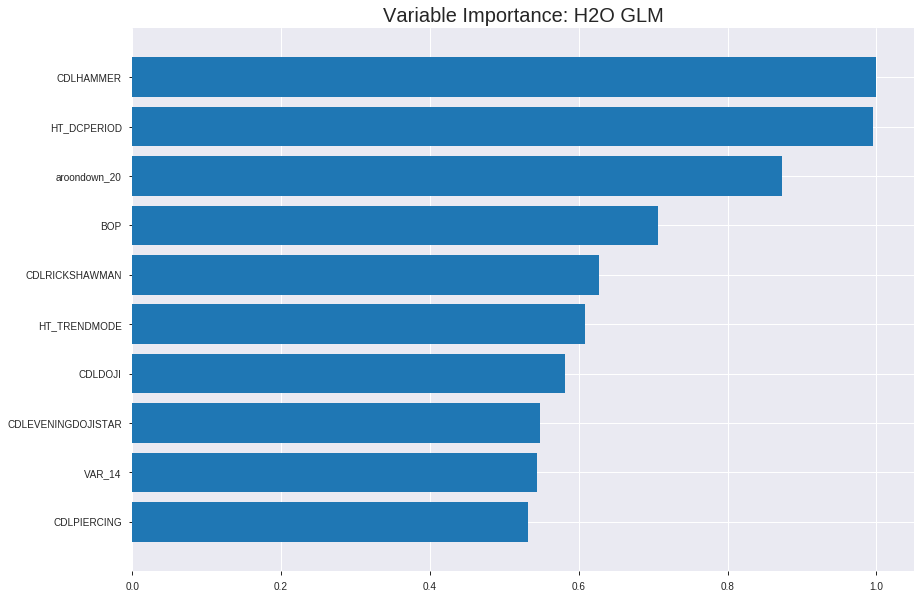

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_163620_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24869269312388792
RMSE: 0.4986909795894527
LogLoss: 0.6905300541457562
Null degrees of freedom: 1534
Residual degrees of freedom: 1484
Null deviance: 2127.955981123116
Residual deviance: 2119.9272662274716
AIC: 2221.9272662274716
AUC: 0.5901946171318758
pr_auc: 0.57892661829267
Gini: 0.18038923426375164
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48956628125856433: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      54   712   0.9295   (712.0/766.0)
1      20   749   0.026    (20.0/769.0)
Total  74   1461  0.4769   (732.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489566     0.671749  347
max f2                       0.478436     0.835325  391
max f0point5                 0.49798      0.581202  250
max accuracy                 0.499755     0.577199  220
max precision                0.569109     1         0
max recall                   0.478436     1         391
max specificity              0.569109     1         0
max absolute_mcc             0.499755     0.154563  220
max min_per_class_accuracy   0.500122     0.565274  214
max mean_per_class_accuracy  0.499755     0.57714   220

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 50.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.534948           1.62183   1.62183            0.8125           0.54375   0.8125                      0.54375             0.0169051       0.0169051                  62.183    62.183
    2        0.0201954                   0.521187           1.33073   1.48098            0.666667         0.526609  0.741935                    0.535456            0.0130039       0.029909                   33.0733   48.0977
    3        0.0306189                   0.518029           1.24756   1.40152            0.625            0.519227  0.702128                    0.529931            0.0130039       0.0429129                  24.7562   40.1516
    4        0.0403909                   0.51503            1.46381   1.41659            0.733333         0.516364  0.709677                    0.526649            0.0143043       0.0572172                  46.3806   41.6586
    5        0.0501629                   0.513665           1.33073   1.39986            0.666667         0.514312  0.701299                    0.524245            0.0130039       0.0702211                  33.0733   39.9862
    6        0.100326                    0.510081           0.959164  1.17951            0.480519         0.511707  0.590909                    0.517976            0.0481144       0.118336                   -4.08356  17.9513
    7        0.150489                    0.507655           1.2184    1.19247            0.61039          0.508793  0.597403                    0.514915            0.0611183       0.179454                   21.8398   19.2475
    8        0.2                         0.505757           1.20817   1.19636            0.605263         0.506731  0.599349                    0.512889            0.0598179       0.239272                   20.8165   19.6359
    9        0.300326                    0.503287           1.15359   1.18207            0.577922         0.504447  0.592191                    0.510069            0.115735        0.355007                   15.359    18.2072
    10       0.4                         0.501538           1.0959    1.1606             0.54902          0.502357  0.581433                    0.508147            0.109233        0.464239                   9.58974   16.0598
    11       0.500326                    0.500124           1.01101   1.1306             0.506494         0.500754  0.566406                    0.506665            0.10143         0.56567                    1.10111   13.0603
    12       0.6                         0.498772           1.03067   1.114              0.51634          0.499431  0.558089                    0.505463            0.102731        0.668401                   3.06654   11.4001
    13       0.699674                    0.497409           0.874109  1.07983            0.437908         0.498102  0.540968                    0.504414            0.0871261       0.755527                   -12.5891  7.98263
    14       0.8                         0.495715           0.868433  1.05332            0.435065         0.496568  0.527687                    0.50343             0.0871261       0.842653                   -13.1567  5.3316
    15       0.899674                    0.492988           0.887155  1.03491            0.444444         0.494545  0.518465                    0.502446            0.0884265       0.931079                   -11.2845  3.49071
    16       1                           0.460176           0.686969  1                  0.344156         0.487805  0.500977                    0.500977           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2506249006934399
RMSE: 0.5006245106798507
LogLoss: 0.694400316677833
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 607.245508785986
Residual deviance: 608.2946774097817
AIC: 710.2946774097817
AUC: 0.4585602503912363
pr_auc: 0.44849373671938253
Gini: -0.08287949921752735
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4701550457603186: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    225  1        (225.0/225.0)
1      0    213  0        (0.0/213.0)
Total  0    438  0.5137   (225.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470155     0.654378  399
max f2                       0.470155     0.825581  399
max f0point5                 0.487251     0.543767  379
max accuracy                 0.520003     0.518265  9
max precision                0.529383     0.666667  2
max recall                   0.470155     1         399
max specificity              0.579583     0.995556  0
max absolute_mcc             0.503436     0.131399  94
max min_per_class_accuracy   0.497697     0.474178  200
max mean_per_class_accuracy  0.489572     0.509609  370

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 49.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.522717           0.822535  0.822535           0.4              0.537771  0.4                         0.537771            0.00938967      0.00938967                 -17.7465  -17.7465
    2        0.0205479                   0.520152           1.54225   1.14241            0.75             0.521535  0.555556                    0.530555            0.0140845       0.0234742                  54.2254   14.241
    3        0.0319635                   0.516308           0.822535  1.02817            0.4              0.518361  0.5                         0.5262              0.00938967      0.0328638                  -17.7465  2.8169
    4        0.0410959                   0.512682           1.02817   1.02817            0.5              0.513765  0.5                         0.523437            0.00938967      0.0422535                  2.8169    2.8169
    5        0.0502283                   0.51153            0         0.841229           0                0.512159  0.409091                    0.521386            0               0.0422535                  -100      -15.8771
    6        0.100457                    0.50748            0.46735   0.654289           0.227273         0.509452  0.318182                    0.515419            0.0234742       0.0657277                  -53.265   -34.5711
    7        0.150685                    0.505549           1.12164   0.810073           0.545455         0.506519  0.393939                    0.512453            0.056338        0.122066                   12.1639   -18.9927
    8        0.200913                    0.504095           0.747759  0.794494           0.363636         0.504777  0.386364                    0.510534            0.0375587       0.159624                   -25.2241  -20.5506
    9        0.30137                     0.501399           0.934699  0.841229           0.454545         0.502734  0.409091                    0.507934            0.0938967       0.253521                   -6.53009  -15.8771
    10       0.399543                    0.499306           1.0999    0.904789           0.534884         0.500458  0.44                        0.506097            0.107981        0.361502                   9.99017   -9.52113
    11       0.5                         0.497674           1.12164   0.948357           0.545455         0.498443  0.461187                    0.504559            0.112676        0.474178                   12.1639   -5.16432
    12       0.600457                    0.496411           1.12164   0.977347           0.545455         0.497109  0.475285                    0.503313            0.112676        0.586854                   12.1639   -2.2653
    13       0.69863                     0.495085           0.956436  0.974409           0.465116         0.495763  0.473856                    0.502252            0.0938967       0.680751                   -4.35637  -2.55915
    14       0.799087                    0.493455           1.0749    0.987042           0.522727         0.494177  0.48                        0.501237            0.107981        0.788732                   7.4904    -1.29577
    15       0.899543                    0.491386           1.16837   1.00729            0.568182         0.492617  0.489848                    0.500274            0.117371        0.906103                   16.8374   0.729249
    16       1                           0.470155           0.934699  1                  0.454545         0.485976  0.486301                    0.498838 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 16:36:20  0.000 sec   2            3.2       51            1.38106           1.3888
    2019-08-26 16:36:20  0.013 sec   4            2         51            1.37857           1.39002
    2019-08-26 16:36:20  0.025 sec   6            1.2       51            1.37526           1.39173
    2019-08-26 16:36:20  0.037 sec   8            0.77      51            1.37116           1.39407
    2019-08-26 16:36:20  0.049 sec   10           0.48      51            1.36645           1.39718

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5181818181818182)

('F1', 0.6787878787878788)

('auc', 0.46577380952380953)

('logloss', 0.6940121573734822)

('mean_per_class_error', 0.4798280423280423)

('rmse', 0.5004321251104031)

('mse', 0.25043231184251413)

glm prediction progress: |████████████████████████████████████████████████| 100%


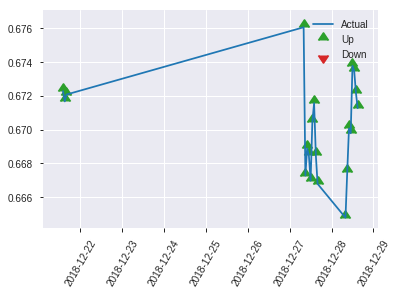


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25043231184251413
RMSE: 0.5004321251104031
LogLoss: 0.6940121573734822
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 304.9699645761388
Residual deviance: 305.36534924433215
AIC: 407.36534924433215
AUC: 0.46577380952380953
pr_auc: 0.482744140431772
Gini: -0.06845238095238093
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4835331438005426: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    106  0.9815   (106.0/108.0)
1      0    112  0        (0.0/112.0)
Total  2    218  0.4818   (106.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483533     0.678788  217
max f2                       0.483533     0.840841  217
max f0point5                 0.483533     0.569106  217
max accuracy                 0.500864     0.518182  85
max precision                0.505435     0.560976  40
max recall                   0.483533     1         217
max specificity              0.524019     0.990741  0
max absolute_mcc             0.515877     0.155297  4
max min_per_class_accuracy   0.498687     0.490741  109
max mean_per_class_accuracy  0.500864     0.520172  85

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 49.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.518484           0         0                  0                0.521599  0                           0.521599            0               0                          -100      -100
    2        0.0227273                   0.515638           0         0                  0                0.516009  0                           0.519363            0               0                          -100      -100
    3        0.0318182                   0.51489            1.96429   0.561224           1                0.51517   0.285714                    0.518165            0.0178571       0.0178571                  96.4286   -43.8776
    4        0.0409091                   0.514451           1.96429   0.873016           1                0.514671  0.444444                    0.517389            0.0178571       0.0357143                  96.4286   -12.6984
    5        0.05                        0.513671           0         0.714286           0                0.514103  0.363636                    0.516791            0               0.0357143                  -100      -28.5714
    6        0.1                         0.50863            0.892857  0.803571           0.454545         0.511367  0.409091                    0.514079            0.0446429       0.0803571                  -10.7143  -19.6429
    7        0.15                        0.506528           1.25      0.952381           0.636364         0.507491  0.484848                    0.511883            0.0625          0.142857                   25        -4.7619
    8        0.2                         0.504897           1.42857   1.07143            0.727273         0.5057    0.545455                    0.510337            0.0714286       0.214286                   42.8571   7.14286
    9        0.3                         0.502329           0.892857  1.0119             0.454545         0.503583  0.515152                    0.508086            0.0892857       0.303571                   -10.7143  1.19048
    10       0.4                         0.500448           1.16071   1.04911            0.590909         0.501472  0.534091                    0.506432            0.116071        0.419643                   16.0714   4.91071
    11       0.5                         0.498619           0.714286  0.982143           0.363636         0.499392  0.5                         0.505024            0.0714286       0.491071                   -28.5714  -1.78571
    12       0.6                         0.497187           0.714286  0.9375             0.363636         0.497812  0.477273                    0.503822            0.0714286       0.5625                     -28.5714  -6.25
    13       0.7                         0.496082           0.803571  0.918367           0.409091         0.496608  0.467532                    0.502792            0.0803571       0.642857                   -19.6429  -8.16327
    14       0.8                         0.494566           1.07143   0.9375             0.545455         0.495414  0.477273                    0.501869            0.107143        0.75                       7.14286   -6.25
    15       0.9                         0.493349           1.42857   0.992063           0.727273         0.49389   0.505051                    0.500983            0.142857        0.892857                   42.8571   -0.793651
    16       1                           0.476897           1.07143   1                  0.545455         0.489398  0.509091                    0.499824           

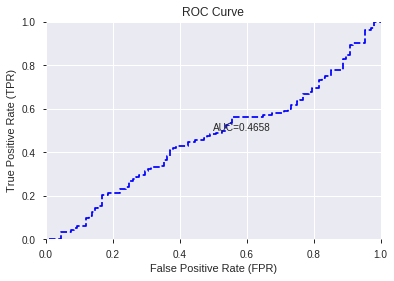

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


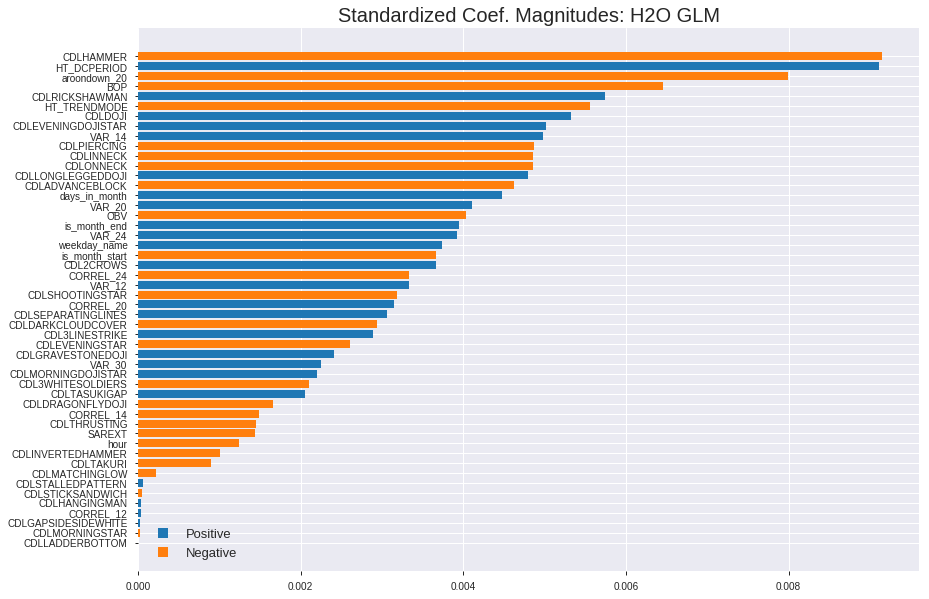

'log_likelihood'
--2019-08-26 16:36:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_163620_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_163620_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLHAMMER',
 'HT_DCPERIOD',
 'aroondown_20',
 'BOP',
 'CDLRICKSHAWMAN',
 'HT_TRENDMODE',
 'CDLDOJI',
 'CDLEVENINGDOJISTAR',
 'VAR_14',
 'CDLPIERCING',
 'CDLINNECK',
 'CDLONNECK',
 'CDLLONGLEGGEDDOJI',
 'CDLADVANCEBLOCK',
 'days_in_month',
 'VAR_20',
 'OBV',
 'is_month_end',
 'VAR_24',
 'weekday_name',
 'is_month_start',
 'CDL2CROWS',
 'CORREL_24',
 'VAR_12',
 'CDLSHOOTINGSTAR',
 'CORREL_20',
 'CDLSEPARATINGLINES',
 'CDLDARKCLOUDCOVER',
 'CDL3LINESTRIKE',
 'CDLEVENINGSTAR',
 'CDLGRAVESTONEDOJI',
 'VAR_30',
 'CDLMORNINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLTASUKIGAP',
 'CDLDRAGONFLYDOJI',
 'CORREL_14',
 'CDLTHRUSTING',
 'SAREXT',
 'hour',
 'CDLINVERTEDHAMMER',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'CDLSTALLEDPATTERN',
 'CDLSTICKSANDWICH',
 'CDLHANGINGMAN',
 'CORREL_12',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGSTAR',
 'CDLLADDERBOTTOM']

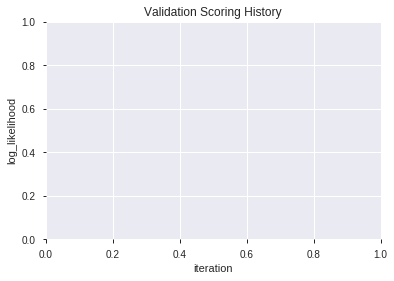

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_163642_model_5  0.514798  0.735477              0.471726  0.518437  0.268777
1               XGBoost_3_AutoML_20190826_163642  0.468006  0.713646              0.495370  0.509915  0.260013
2  XGBoost_grid_1_AutoML_20190826_163642_model_3  0.462467  0.715488              0.490741  0.510764  0.260880
3  XGBoost_grid_1_AutoML_20190826_163642_model_6  0.460400  0.716672              0.481316  0.511364  0.261493
4               XGBoost_2_AutoML_20190826_163642  0.454613  0.720516              0.481151  0.513138  0.263311
5  XGBoost_grid_1_AutoML_20190826_163642_model_2  0.454365  0.713484              0.500000  0.509906  0.260004
6               XGBoost_1_AutoML_20190826_163642  0.448082  0.722554              0.495370  0.514106  0.264305
7  XGBoost_grid_1_AutoML_20190826_163642_model_7  0.444775  0.742170              0.495370  0.522733  0.273250
8  XGBoost_grid_1_AutoML_20190826_163642_model_4  0.431217  0.717113              0.495370  0.511667  0.261803
9  XGBoost_grid_1_AutoML_20190826_163642_model_1  0.409805  0.739386              0.476687  0.522129  0.272619

variable  relative_importance  scaled_importance  percentage
0           HT_DCPERIOD          1856.071411           1.000000    0.086715
1                   BOP          1796.747925           0.968038    0.083944
2                SAREXT          1793.919434           0.966514    0.083812
3                   OBV          1734.099609           0.934285    0.081017
4                VAR_14          1539.849609           0.829628    0.071941
5                VAR_12          1385.770386           0.746615    0.064743
6                VAR_24          1262.402100           0.680147    0.058979
7                VAR_30          1250.663940           0.673823    0.058431
8                VAR_20          1239.809937           0.667975    0.057924
9             CORREL_24          1197.696411           0.645286    0.055956
10                 hour          1031.013550           0.555482    0.048169
11         aroondown_20          1003.013672           0.540396    0.046861
12            CORREL_14           997.007507           0.537160    0.046580
13            CORREL_20           917.940430           0.494561    0.042886
14            CORREL_12           797.546326           0.429696    0.037261
15         weekday_name           471.997681           0.254299    0.022052
16        days_in_month           298.781952           0.160975    0.013959
17         HT_TRENDMODE           148.516434           0.080017    0.006939
18              CDLDOJI           111.329758           0.059981    0.005201
19       CDLRICKSHAWMAN            84.300514           0.045419    0.003939
20            CDLHAMMER            76.339539           0.041130    0.003567
21       is_month_start            56.491196           0.030436    0.002639
22         is_month_end            42.614334           0.022959    0.001991
23    CDLGRAVESTONEDOJI            40.986832           0.022083    0.001915
24    CDLINVERTEDHAMMER            39.375828           0.021215    0.001840
25     CDLDRAGONFLYDOJI            35.141338           0.018933    0.001642
26        CDLHANGINGMAN            28.896519           0.015569    0.001350
27      CDLADVANCEBLOCK            23.603294           0.012717    0.001103
28            CDLTAKURI            21.635660           0.011657    0.001011
29      CDLSHOOTINGSTAR            19.977846           0.010764    0.000933
30    CDLLONGLEGGEDDOJI            17.570248           0.009466    0.000821
31       CDLMATCHINGLOW            14.711393           0.007926    0.000687
32       CDLEVENINGSTAR            13.984657           0.007535    0.000653
33  CDLGAPSIDESIDEWHITE             8.493547           0.004576    0.000397
34       CDL3LINESTRIKE             7.762857           0.004182    0.000363
35         CDLTHRUSTING             7.533677           0.004059    0.000352
36     CDLSTICKSANDWICH             6.999831           0.003771    0.000327
37      CDLLADDERBOTTOM             4.479550           0.002413    0.000209
38   CDLEVENINGDOJISTAR             4.100592           0.002209    0.000192
39    CDL3WHITESOLDIERS             4.044546           0.002179    0.000189
40         CDLTASUKIGAP             2.190288           0.001180    0.000102
41       CDLMORNINGSTAR             2.057099           0.001108    0.000096
42            CDL2CROWS             1.531170           0.000825    0.000072
43    CDLDARKCLOUDCOVER             1.483823           0.000799    0.000069
44          CDLPIERCING             1.475330           0.000795    0.000069
45   CDLSEPARATINGLINES             1.444132           0.000778    0.000067
46    CDLSTALLEDPATTERN             0.793087           0.000427    0.000037

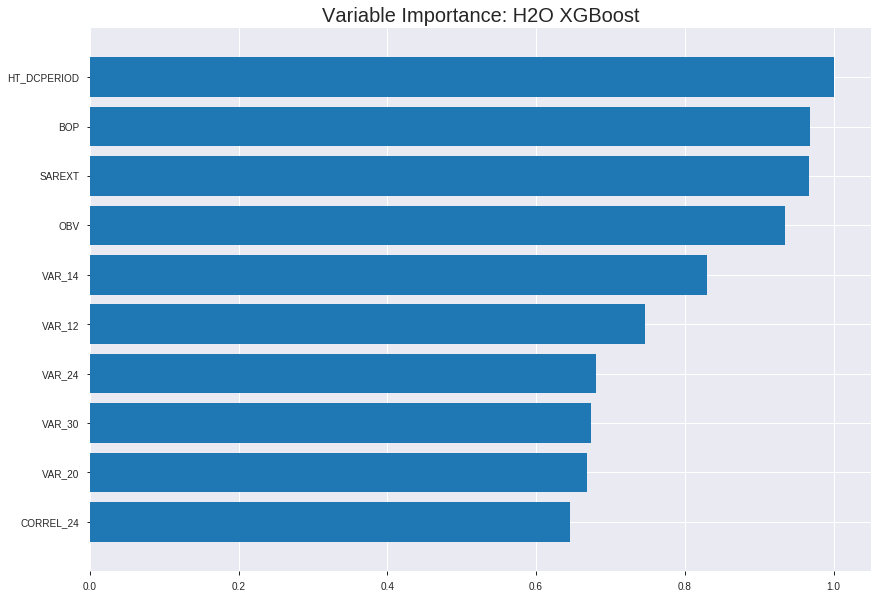

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_163642_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.05108973548595706
RMSE: 0.22603038620052185
LogLoss: 0.24712362059492238
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9986996098829649
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5499263405799866: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      766  0    0        (0.0/766.0)
1      0    769  0        (0.0/769.0)
Total  766  769  0        (0.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.549926     1        196
max f2                       0.549926     1        196
max f0point5                 0.549926     1        196
max accuracy                 0.549926     1        196
max precision                0.9156       1        0
max recall                   0.549926     1        196
max specificity              0.9156       1        0
max absolute_mcc             0.549926     1        196
max min_per_class_accuracy   0.549926     1        196
max mean_per_class_accuracy  0.549926     1        196

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 50.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.890647           1.9961     1.9961             1                0.902372  1                           0.902372            0.0208062       0.0208062                  99.6099   99.6099
    2        0.0201954                   0.882143           1.9961     1.9961             1                0.886495  1                           0.89469             0.0195059       0.0403121                  99.6099   99.6099
    3        0.0306189                   0.874659           1.9961     1.9961             1                0.877559  1                           0.888858            0.0208062       0.0611183                  99.6099   99.6099
    4        0.0403909                   0.867549           1.9961     1.9961             1                0.872227  1                           0.884834            0.0195059       0.0806242                  99.6099   99.6099
    5        0.0501629                   0.863524           1.9961     1.9961             1                0.865856  1                           0.881137            0.0195059       0.10013                    99.6099   99.6099
    6        0.100326                    0.84441            1.9961     1.9961             1                0.854028  1                           0.867583            0.10013         0.20026                    99.6099   99.6099
    7        0.150489                    0.826476           1.9961     1.9961             1                0.835582  1                           0.856916            0.10013         0.30039                    99.6099   99.6099
    8        0.2                         0.807992           1.9961     1.9961             1                0.817237  1                           0.847093            0.0988296       0.39922                    99.6099   99.6099
    9        0.300326                    0.776552           1.9961     1.9961             1                0.793299  1                           0.829123            0.20026         0.59948                    99.6099   99.6099
    10       0.4                         0.731822           1.9961     1.9961             1                0.756191  1                           0.810949            0.19896         0.79844                    99.6099   99.6099
    11       0.500326                    0.577645           1.9961     1.9961             1                0.686469  1                           0.785988            0.20026         0.9987                     99.6099   99.6099
    12       0.6                         0.274722           0.0130464  1.66667            0.00653595       0.322996  0.834962                    0.709074            0.00130039      1                          -98.6954  66.6667
    13       0.699674                    0.225494           0          1.42924            0                0.248374  0.716015                    0.643444            0               1                          -100      42.9236
    14       0.8                         0.192558           0          1.25               0                0.209022  0.626221                    0.588964            0               1                          -100      25
    15       0.899674                    0.160154           0          1.11151            0                0.175353  0.556843                    0.54314             0               1                          -100      11.1513
    16       1                           0.0814354          0          1                  0                0.135263  0.500977                    0.50



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.27512318188403145
RMSE: 0.524521860253728
LogLoss: 0.7486337813685475
Mean Per-Class Error: 0.48294209702660407
AUC: 0.4801147626499739
pr_auc: 0.44964791094162354
Gini: -0.03977047470005224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18867003917694092: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    223  0.9911   (223.0/225.0)
1      0    213  0        (0.0/213.0)
Total  2    436  0.5091   (223.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.18867      0.656394  397
max f2                       0.18867      0.826863  397
max f0point5                 0.211846     0.545455  389
max accuracy                 0.83273      0.515982  0
max precision                0.83273      1         0
max recall                   0.18867      1         397
max specificity              0.83273      1         0
max absolute_mcc             0.651649     0.147139  22
max min_per_class_accuracy   0.428684     0.493333  200
max mean_per_class_accuracy  0.362852     0.517058  279

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 44.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.732144           0.411268  0.411268           0.2              0.773793  0.2                         0.773793            0.00469484      0.00469484                 -58.8732  -58.8732
    2        0.0205479                   0.716842           0.514085  0.456964           0.25             0.727813  0.222222                    0.753357            0.00469484      0.00938967                 -48.5915  -54.3036
    3        0.0319635                   0.690039           0         0.293763           0                0.701334  0.142857                    0.734778            0               0.00938967                 -100      -70.6237
    4        0.0410959                   0.676506           0.514085  0.342723           0.25             0.683008  0.166667                    0.723273            0.00469484      0.0140845                  -48.5915  -65.7277
    5        0.0502283                   0.651864           0.514085  0.37388            0.25             0.666225  0.181818                    0.712901            0.00469484      0.0187793                  -48.5915  -62.612
    6        0.100457                    0.604162           1.12164   0.747759           0.545455         0.62728   0.363636                    0.670091            0.056338        0.0751174                  12.1639   -25.2241
    7        0.150685                    0.579423           0.841229  0.778916           0.409091         0.589828  0.378788                    0.643337            0.0422535       0.117371                   -15.8771  -22.1084
    8        0.200913                    0.554545           0.934699  0.817862           0.454545         0.568062  0.397727                    0.624518            0.0469484       0.164319                   -6.53009  -18.2138
    9        0.30137                     0.517368           1.16837   0.934699           0.568182         0.53554   0.454545                    0.594859            0.117371        0.28169                    16.8374   -6.53009
    10       0.399543                    0.479197           1.05208   0.963541           0.511628         0.497751  0.468571                    0.570998            0.103286        0.384977                   5.20799   -3.64588
    11       0.5                         0.430152           1.0749    0.985915           0.522727         0.455725  0.479452                    0.547838            0.107981        0.492958                   7.4904    -1.40845
    12       0.600457                    0.394762           1.02817   0.992985           0.5              0.411384  0.48289                     0.525009            0.103286        0.596244                   2.8169    -0.701548
    13       0.69863                     0.3639             1.19555   1.02145            0.581395         0.380053  0.496732                    0.50464             0.117371        0.713615                   19.5545   2.1449
    14       0.799087                    0.330127           0.887964  1.00467            0.431818         0.349411  0.488571                    0.485125            0.0892019       0.802817                   -11.2036  0.466801
    15       0.899543                    0.26465            0.841229  0.986416           0.409091         0.302053  0.479695                    0.46468             0.084507        0.887324                   -15.8771  -1.3584
    16       1                           0.117371           1.12164   1                  0.545455         0.228221  0.486301                    0.440


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 16:36:49  3.400 sec   0                  0.5              0.693147            0.5             0                  1                0.499023                         0.5                0.693147              0.5               0                    1                  0.513699
    2019-08-26 16:36:50  3.784 sec   5                  0.454102         0.604974            0.966611        0.965736           1.9961           0.0944625                        0.505176           0.703638              0.455263          0.443908             0.411268           0.513699
    2019-08-26 16:36:50  4.099 sec   10                 0.415532         0.53586             0.99245         0.991413           1.9961           0.037785                         0.505036           0.7034                0.47736           0.482603             1.64507            0.511416
    2019-08-26 16:36:50  4.418 sec   15                 0.381642         0.478208            0.997521        0.996211           1.9961           0.0228013                        0.506879           0.707255              0.475879          0.473258             1.2338             0.513699
    2019-08-26 16:36:51  4.762 sec   20                 0.349583         0.426439            0.999666        0.997063           1.9961           0.00846906                       0.50937            0.712722              0.481732          0.462421             0.822535           0.509132
    2019-08-26 16:36:51  5.086 sec   25                 0.323759         0.386305            0.999927        0.997327           1.9961           0.00456026                       0.51276            0.72002               0.472478          0.450109             0.411268           0.509132
    2019-08-26 16:36:52  5.453 sec   30                 0.302918         0.354693            0.999974        0.998673           1.9961           0.000651466                      0.517113           0.730057              0.472885          0.445611             0.411268           0.509132
    2019-08-26 16:36:52  5.816 sec   35                 0.283078         0.325478            0.999975        0.998674           1.9961           0.00130293                       0.517417           0.731265              0.480376          0.455863             0.822535           0.509132
    2019-08-26 16:36:52  6.174 sec   40                 0.26233          0.296161            0.999997        0.998696           1.9961           0.000651466                      0.521641           0.740881              0.469776          0.444273             0.411268           0.511416
    2019-08-26 16:36:53  6.574 sec   45                 0.244504         0.271834            1               0.996099           1.9961           0                                0.522661           0.743782              0.479468          0.450313             0.411268           0.504566
    2019-08-26 16:36:53  6.966 sec   50                 0.22603          0.247124            1               0.9987             1.9961           0                                0.524522           0.748634              0.480115          0.449648             0.411268           0.509132

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
HT_DCPERIOD         1856.0714111328125     1.0                    0.08671530301013525
BOP                 1796.7479248046875     0.9680381444526867     0.08394372102158379
SAREXT              1793.91943359375       0.9665142315288777     0.08381157445063464
OBV                 1734.099609375         0.9342849628380572     0.08101680365031506
VAR_14              1539.849609375         0.8296284292397923     0.07194148062735113
---                 ---                    ---                    ---
CDL2CROWS           1.531170129776001      0.0008249521654134443  7.153597699269403e-05
CDLDARKCLOUDCOVER   1.4838231801986694     0.0007994429370004953  6.932393652131041e-05
CDLPIERCING         1.475330114364624      0.0007948671077607885  6.89271421022666e-05
CDLSEPARATINGLINES  1.444131851196289      0.0007780583454571367  6.74695651858801e-05
CDLSTALLEDPATTERN   0.7930868268013        0.0004272932722546795  3.7052865577756745e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5454545454545454)

('F1', 0.68125)

('auc', 0.5147982804232805)

('logloss', 0.735477442921593)

('mean_per_class_error', 0.4522156084656085)

('rmse', 0.5184369036329545)

('mse', 0.2687768230485253)

xgboost prediction progress: |████████████████████████████████████████████| 100%


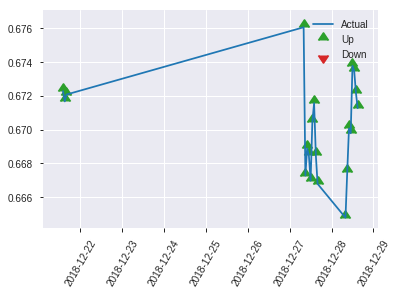


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2687768230485253
RMSE: 0.5184369036329545
LogLoss: 0.735477442921593
Mean Per-Class Error: 0.4522156084656085
AUC: 0.5147982804232805
pr_auc: 0.5174004738935863
Gini: 0.029596560846560926
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24437516927719116: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    99   0.9167   (99.0/108.0)
1      3    109  0.0268   (3.0/112.0)
Total  12   208  0.4636   (102.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.244375     0.68125   207
max f2                       0.195822     0.83958   218
max f0point5                 0.244375     0.577331  207
max accuracy                 0.491238     0.545455  81
max precision                0.582652     0.62069   28
max recall                   0.195822     1         218
max specificity              0.792812     0.990741  0
max absolute_mcc             0.244375     0.124484  207
max min_per_class_accuracy   0.449515     0.5       104
max mean_per_class_accuracy  0.491238     0.547784  81

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 44.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.738673           0         0                  0                0.769756  0                           0.769756            0               0                          -100      -100
    2        0.0227273                   0.727535           1.96429   0.785714           1                0.732738  0.4                         0.754949            0.0178571       0.0178571                  96.4286   -21.4286
    3        0.0318182                   0.712923           0.982143  0.841837           0.5              0.719712  0.428571                    0.744881            0.00892857      0.0267857                  -1.78571  -15.8163
    4        0.0409091                   0.694365           0.982143  0.873016           0.5              0.70215   0.444444                    0.735385            0.00892857      0.0357143                  -1.78571  -12.6984
    5        0.05                        0.673161           0         0.714286           0                0.684094  0.363636                    0.72606             0               0.0357143                  -100      -28.5714
    6        0.1                         0.602651           1.42857   1.07143            0.727273         0.633137  0.545455                    0.679598            0.0714286       0.107143                   42.8571   7.14286
    7        0.15                        0.576083           1.42857   1.19048            0.727273         0.58805   0.606061                    0.649082            0.0714286       0.178571                   42.8571   19.0476
    8        0.2                         0.552702           0.714286  1.07143            0.363636         0.563066  0.545455                    0.627578            0.0357143       0.214286                   -28.5714  7.14286
    9        0.3                         0.509909           1.07143   1.07143            0.545455         0.528365  0.545455                    0.594507            0.107143        0.321429                   7.14286   7.14286
    10       0.4                         0.475215           1.25      1.11607            0.636364         0.495084  0.568182                    0.569651            0.125           0.446429                   25        11.6071
    11       0.5                         0.439499           0.535714  1                  0.272727         0.458855  0.509091                    0.547492            0.0535714       0.5                        -46.4286  0
    12       0.6                         0.395424           1.07143   1.0119             0.545455         0.414507  0.515152                    0.525328            0.107143        0.607143                   7.14286   1.19048
    13       0.7                         0.356572           0.803571  0.982143           0.409091         0.378096  0.5                         0.504295            0.0803571       0.6875                     -19.6429  -1.78571
    14       0.8                         0.330483           0.982143  0.982143           0.5              0.341855  0.5                         0.48399             0.0982143       0.785714                   -1.78571  -1.78571
    15       0.9                         0.276566           1.07143   0.992063           0.545455         0.307139  0.505051                    0.46434             0.107143        0.892857                   7.14286   -0.793651
    16       1                           0.160753           1.07143   1                  0.545455         0.237026  0.509091                    0.441608          

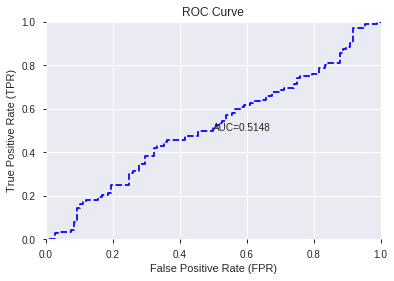

This function is available for GLM models only


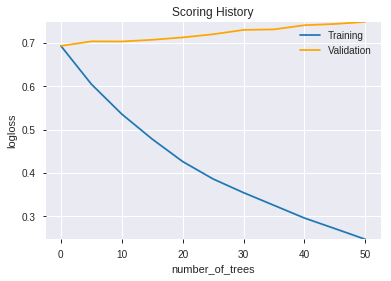

--2019-08-26 16:37:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.alg

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_163642_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_163642_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_DCPERIOD',
 'BOP',
 'SAREXT',
 'OBV',
 'VAR_14',
 'VAR_12',
 'VAR_24',
 'VAR_30',
 'VAR_20',
 'CORREL_24',
 'hour',
 'aroondown_20',
 'CORREL_14',
 'CORREL_20',
 'CORREL_12',
 'weekday_name',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLHAMMER',
 'is_month_start',
 'is_month_end',
 'CDLGRAVESTONEDOJI',
 'CDLINVERTEDHAMMER',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN',
 'CDLADVANCEBLOCK',
 'CDLTAKURI',
 'CDLSHOOTINGSTAR',
 'CDLLONGLEGGEDDOJI',
 'CDLMATCHINGLOW',
 'CDLEVENINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDL3LINESTRIKE',
 'CDLTHRUSTING',
 'CDLSTICKSANDWICH',
 'CDLLADDERBOTTOM',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLTASUKIGAP',
 'CDLMORNINGSTAR',
 'CDL2CROWS',
 'CDLDARKCLOUDCOVER',
 'CDLPIERCING',
 'CDLSEPARATINGLINES',
 'CDLSTALLEDPATTERN']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 915] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_163720_model_3  0.546048  0.713223              0.495370  0.507267  0.257320
1  DeepLearning_grid_1_AutoML_20190826_163720_model_4  0.536624  0.903139              0.485615  0.556320  0.309492
2  DeepLearning_grid_1_AutoML_20190826_163720_model_1  0.519428  1.594581              0.485946  0.627534  0.393798
3  DeepLearning_grid_1_AutoML_20190826_163720_model_5  0.517857  0.689012              0.500000  0.498006  0.248010
4  DeepLearning_grid_1_AutoML_20190826_163720_model_8  0.500000  0.696813              0.500000  0.501825  0.251829
5  DeepLearning_grid_1_AutoML_20190826_163720_model_9  0.500000  0.693308              0.500000  0.500080  0.250080
6  DeepLearning_grid_1_AutoML_20190826_163720_model_2  0.498760  0.711731              0.500000  0.508829  0.258907
7  DeepLearning_grid_1_AutoML_20190826_163720_model_6  0.491733  0.694917              0.500000  0.500882  0.250882
8  DeepLearning_grid_1_AutoML_20190826_163720_model_7  0.474206  0.730326              0.500000  0.517699  0.268013
9               DeepLearning_1_AutoML_20190826_163720  0.467510  0.709981              0.495370  0.508145  0.258211

variable  relative_importance  scaled_importance  percentage
0                  CDLPIERCING             1.000000           1.000000    0.003488
1            CDLDARKCLOUDCOVER             0.982831           0.982831    0.003428
2               CDLEVENINGSTAR             0.955835           0.955835    0.003334
3              CDLADVANCEBLOCK             0.948709           0.948709    0.003309
4                 CDLTHRUSTING             0.938068           0.938068    0.003272
...                        ...                  ...                ...         ...
1033                   KAMA_24             0.209508           0.209508    0.000731
1034  BBANDS_middleband_24_6_4             0.204307           0.204307    0.000713
1035   BBANDS_upperband_24_6_3             0.201643           0.201643    0.000703
1036                 CDLHARAMI             0.201431           0.201431    0.000703
1037       CDLRISEFALL3METHODS             0.175741           0.175741    0.000613

[1038 rows x 4 columns]

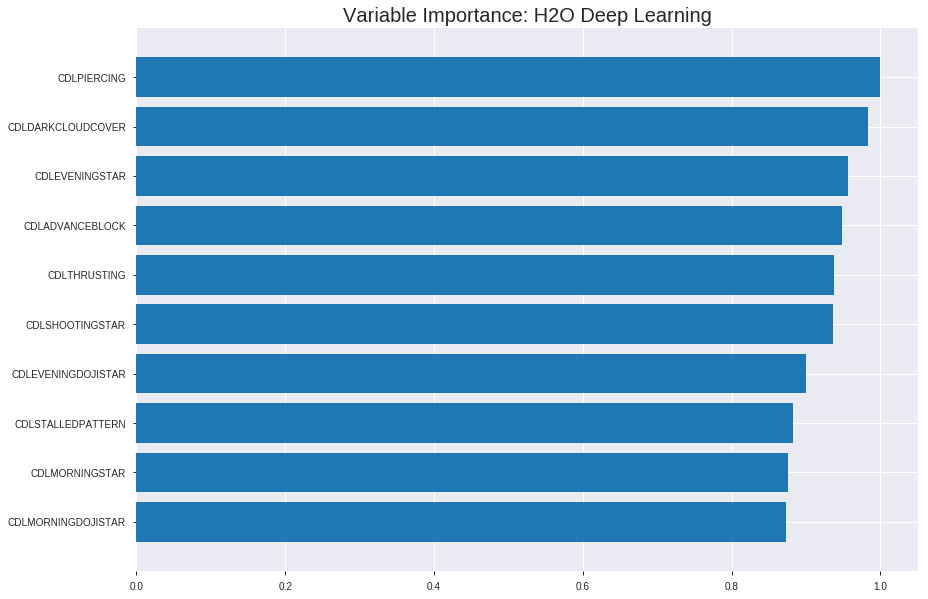

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_163720_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23738987726460023
RMSE: 0.48722672059791655
LogLoss: 0.6686121975909172
Mean Per-Class Error: 0.3961538330950982
AUC: 0.640301228749826
pr_auc: 0.6208080943054067
Gini: 0.28060245749965196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3028057633895124: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      148  618   0.8068   (618.0/766.0)
1      54   715   0.0702   (54.0/769.0)
Total  202  1333  0.4378   (672.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.302806     0.680304  307
max f2                       0.19946      0.83443   363
max f0point5                 0.405849     0.608494  228
max accuracy                 0.440171     0.603909  200
max precision                0.843079     1         0
max recall                   0.0259094    1         398
max specificity              0.843079     1         0
max absolute_mcc             0.374503     0.217226  254
max min_per_class_accuracy   0.44944      0.593995  191
max mean_per_class_accuracy  0.440171     0.603846  200

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 44.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.727785           1.62183   1.62183            0.8125           0.778759  0.8125                      0.778759            0.0169051       0.0169051                  62.183    62.183
    2        0.0201954                   0.709343           1.33073   1.48098            0.666667         0.716485  0.741935                    0.748626            0.0130039       0.029909                   33.0733   48.0977
    3        0.0306189                   0.693468           1.12281   1.35905            0.5625           0.699352  0.680851                    0.731852            0.0117035       0.0416125                  12.2806   35.9046
    4        0.0403909                   0.672447           1.72995   1.44878            0.866667         0.682948  0.725806                    0.72002             0.0169051       0.0585176                  72.9952   44.8781
    5        0.0501629                   0.658762           1.46381   1.45171            0.733333         0.665332  0.727273                    0.709367            0.0143043       0.0728218                  46.3806   45.1708
    6        0.100326                    0.615358           1.29617   1.37394            0.649351         0.634635  0.688312                    0.672001            0.0650195       0.137841                   29.6168   37.3938
    7        0.150489                    0.585153           1.47763   1.4085             0.74026          0.600372  0.705628                    0.648125            0.0741222       0.211964                   47.7632   40.8503
    8        0.2                         0.563748           1.23443   1.36541            0.618421         0.574453  0.684039                    0.629887            0.0611183       0.273082                   23.443    36.541
    9        0.300326                    0.524911           1.01101   1.24702            0.506494         0.542841  0.624729                    0.600808            0.10143         0.374512                   1.10111   24.7021
    10       0.4                         0.484431           1.10894   1.21261            0.555556         0.503993  0.607492                    0.576684            0.110533        0.485046                   10.8944   21.2614
    11       0.500326                    0.449415           1.10174   1.19038            0.551948         0.467216  0.596354                    0.554733            0.110533        0.595579                   10.1743   19.0382
    12       0.6                         0.42189            0.97848   1.15518            0.490196         0.43573   0.578719                    0.534964            0.0975293       0.693108                   -2.15202  15.518
    13       0.699674                    0.381414           1.00457   1.13372            0.503268         0.403074  0.56797                     0.516175            0.10013         0.793238                   0.457261  13.3725
    14       0.8                         0.336747           0.868433  1.10046            0.435065         0.359814  0.551303                    0.496566            0.0871261       0.880364                   -13.1567  10.0455
    15       0.899674                    0.277128           0.639273  1.04936            0.320261         0.311378  0.525706                    0.476049            0.0637191       0.944083                   -36.0727  4.93612
    16       1                           0.0215215          0.557352  1                  0.279221         0.206368  0.500977                    0.448993            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.27411331549500756
RMSE: 0.5235583210063685
LogLoss: 0.7475962340578357
Mean Per-Class Error: 0.4823474178403756
AUC: 0.4791549295774648
pr_auc: 0.4714703018182027
Gini: -0.04169014084507039
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17461067206409348: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    216  0.96     (216.0/225.0)
1      1    212  0.0047   (1.0/213.0)
Total  10   428  0.4954   (217.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.174611     0.661466  389
max f2                       0.174611     0.828125  389
max f0point5                 0.174611     0.550649  389
max accuracy                 0.582046     0.525114  61
max precision                0.650034     0.5625    30
max recall                   0.0751074    1         398
max specificity              0.898099     0.995556  0
max absolute_mcc             0.174611     0.11814   389
max min_per_class_accuracy   0.449829     0.474178  197
max mean_per_class_accuracy  0.174611     0.517653  389

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 44.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.794395           0.822535  0.822535           0.4              0.835985  0.4                         0.835985            0.00938967      0.00938967                 -17.7465  -17.7465
    2        0.0205479                   0.738955           1.02817   0.913928           0.5              0.76258   0.444444                    0.80336             0.00938967      0.0187793                  2.8169    -8.6072
    3        0.0319635                   0.717588           1.2338    1.02817            0.6              0.730149  0.5                         0.777213            0.0140845       0.0328638                  23.3803   2.8169
    4        0.0410959                   0.696095           1.02817   1.02817            0.5              0.702211  0.5                         0.760546            0.00938967      0.0422535                  2.8169    2.8169
    5        0.0502283                   0.679772           0.514085  0.934699           0.25             0.687047  0.454545                    0.747183            0.00469484      0.0469484                  -48.5915  -6.53009
    6        0.100457                    0.620298           1.12164   1.02817            0.545455         0.648794  0.5                         0.697988            0.056338        0.103286                   12.1639   2.8169
    7        0.150685                    0.580479           1.12164   1.05933            0.545455         0.593116  0.515152                    0.663031            0.056338        0.159624                   12.1639   5.93257
    8        0.200913                    0.556845           0.654289  0.958067           0.318182         0.568312  0.465909                    0.639351            0.0328638       0.192488                   -34.5711  -4.19334
    9        0.30137                     0.514982           0.747759  0.887964           0.363636         0.535394  0.431818                    0.604699            0.0751174       0.267606                   -25.2241  -11.2036
    10       0.399543                    0.48341            0.956436  0.904789           0.465116         0.496902  0.44                        0.578212            0.0938967       0.361502                   -4.35637  -9.52113
    11       0.5                         0.446608           1.12164   0.948357           0.545455         0.46439   0.461187                    0.555343            0.112676        0.474178                   12.1639   -5.16432
    12       0.600457                    0.400921           1.0749    0.969528           0.522727         0.422786  0.471483                    0.533166            0.107981        0.58216                    7.4904    -3.04718
    13       0.69863                     0.363388           1.33901   1.02145            0.651163         0.38567   0.496732                    0.51244             0.131455        0.713615                   33.9011   2.1449
    14       0.799087                    0.317311           0.747759  0.987042           0.363636         0.339914  0.48                        0.490751            0.0751174       0.788732                   -25.2241  -1.29577
    15       0.899543                    0.266468           1.0749    0.996854           0.522727         0.294753  0.484772                    0.468863            0.107981        0.896714                   7.4904    -0.314578
    16       1                           0.0628415          1.02817   1                  0.5              0.206873  0.486301                    0.442544   


Scoring History: 


timestamp            duration          training_speed    epochs              iterations    samples    training_rmse        training_logloss    training_r2           training_auc        training_pr_auc     training_lift       training_classification_error    validation_rmse     validation_logloss    validation_r2         validation_auc       validation_pr_auc    validation_lift     validation_classification_error
---  -------------------  ----------------  ----------------  ------------------  ------------  ---------  -------------------  ------------------  --------------------  ------------------  ------------------  ------------------  -------------------------------  ------------------  --------------------  --------------------  -------------------  -------------------  ------------------  ---------------------------------
     2019-08-26 16:40:34  0.000 sec                           0.0                 0             0.0        nan                  nan                 nan                   nan                 nan                 nan                 nan                              nan                 nan                   nan                   nan                  nan                  nan                 nan
     2019-08-26 16:40:36  3 min 13.743 sec  452 obs/sec       0.5530944625407166  1             849.0      0.6782118446104799   3.7978954419129853  -0.8398922524595196   0.5181740553497641  0.5006853422907627  1.3723179453836152  0.4990228013029316               0.6950555662434211  5.631674375136737     -0.9338605354699836   0.5233176838810641   0.4947166540633911   1.2338028169014084  0.4908675799086758
     2019-08-26 16:40:45  3 min 22.495 sec  516 obs/sec       3.2925081433224754  6             5054.0     0.6419461663103577   3.107985301573223   -0.6483858180507585   0.5786489863408109  0.5598736392466156  1.497074122236671   0.4990228013029316               0.6827027342390366  3.0074501528058213    -0.8657325306030472   0.44811684924360984  0.4488771710856237   0.8225352112676056  0.5136986301369864
     2019-08-26 16:40:54  3 min 31.112 sec  528 obs/sec       6.034527687296417   11            9263.0     0.6075882438384148   1.9023070575489145  -0.4766595365535089   0.5830950982422664  0.5584202326640109  1.497074122236671   0.4990228013029316               0.6906204393144035  4.408344013199557     -0.9092594738016981   0.46026082420448616  0.45501623496090365  0.8225352112676056  0.5136986301369864
     2019-08-26 16:41:04  3 min 41.184 sec  536 obs/sec       9.359609120521172   17            14367.0    0.5966536569409016   1.3227830336673831  -0.4239877845260491   0.6144682830436599  0.6118133418692671  1.746586475942783   0.4482084690553746               0.629218451699144   1.6471711229549855    -0.5848530461744541   0.5135628586332811   0.49601287048273063  1.2338028169014084  0.5114155251141552
---  ---                  ---               ---               ---                 ---           ---        ---                  ---                 ---                   ---                 ---                 ---                 ---                              ---                 ---                   ---                   ---                  ---                  ---                 ---
     2019-08-26 16:42:56  5 min 33.067 sec  577 obs/sec       48.25928338762215   88            74078.0    0.4969863139527217   0.6950449733087247  0.012014641197527376  0.6107513063318474  0.5986768950117057  1.621830299089727   0.4547231270358306               0.5424778932404798  0.8038447358167917    -0.1780132870193578   0.4711945748565467   0.4562186134476489   0.8225352112676056  0.4954337899543379
     2019-08-26 16:43:04  5 min 42.001 sec  579 obs/sec       51.521824104234526  94            79086.0    0.5756623183545888   1.129670383222193   -0.32555348226929515  0.5539347835682297  0.5427655236347452  1.3723179453836152  0.46579804560260585              0.5608366177479757  0.9168670816080003    -0.2590959370662491   0.451257


See the whole table with table.as_data_frame()
Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLPIERCING               1.0                    1.0                  0.003487978790779036
CDLDARKCLOUDCOVER         0.9828314781188965     0.9828314781188965   0.0034280953505887216
CDLEVENINGSTAR            0.955834686756134      0.955834686756134    0.0033339311148963195
CDLADVANCEBLOCK           0.9487085938453674     0.9487085938453674   0.0033090754539624448
CDLTHRUSTING              0.938067615032196      0.938067615032196    0.003271959945548974
---                       ---                    ---                  ---
KAMA_24                   0.20950756967067719    0.20950756967067719  0.0007307579595189833
BBANDS_middleband_24_6_4  0.20430687069892883    0.20430687069892883  0.0007126180318082988
BBANDS_upperband_24_6_3   0.20164304971694946    0.20164304971694946  0.0007033266807207225
CDLHARAMI                 0.2014314830303192     0.2014314830303192   0.0007025887406049208
CDLRISEFALL3METHODS       0.17574097216129303    0.17574097216129303  0.0006129807835694791


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5681818181818182)

('F1', 0.676737160120846)

('auc', 0.5460482804232805)

('logloss', 0.7132225925228854)

('mean_per_class_error', 0.43535052910052907)

('rmse', 0.5072667932155597)

('mse', 0.25731959949919736)

deeplearning prediction progress: |███████████████████████████████████████| 100%


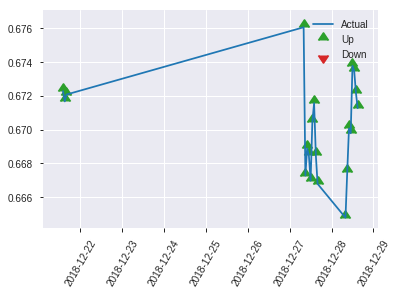


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25731959949919736
RMSE: 0.5072667932155597
LogLoss: 0.7132225925228854
Mean Per-Class Error: 0.43535052910052907
AUC: 0.5460482804232805
pr_auc: 0.5302027598951411
Gini: 0.09209656084656093
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12316361207416095: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    107  0.9907   (107.0/108.0)
1      0    112  0        (0.0/112.0)
Total  1    219  0.4864   (107.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.123164     0.676737  218
max f2                       0.123164     0.83958   218
max f0point5                 0.350829     0.589623  183
max accuracy                 0.448918     0.568182  152
max precision                0.774936     1         0
max recall                   0.123164     1         218
max specificity              0.774936     1         0
max absolute_mcc             0.350829     0.15551   183
max min_per_class_accuracy   0.526516     0.537037  110
max mean_per_class_accuracy  0.448918     0.564649  152

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 49.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.744837           1.30952   1.30952            0.666667         0.75508   0.666667                    0.75508             0.0178571       0.0178571                  30.9524   30.9524
    2        0.0227273                   0.726276           0.982143  1.17857            0.5              0.73924   0.6                         0.748744            0.00892857      0.0267857                  -1.78571  17.8571
    3        0.0318182                   0.710612           0         0.841837           0                0.712929  0.428571                    0.738511            0               0.0267857                  -100      -15.8163
    4        0.0409091                   0.708048           0         0.654762           0                0.709021  0.333333                    0.731958            0               0.0267857                  -100      -34.5238
    5        0.05                        0.693831           0.982143  0.714286           0.5              0.704399  0.363636                    0.726947            0.00892857      0.0357143                  -1.78571  -28.5714
    6        0.1                         0.645175           1.42857   1.07143            0.727273         0.672008  0.545455                    0.699478            0.0714286       0.107143                   42.8571   7.14286
    7        0.15                        0.614457           1.25      1.13095            0.636364         0.629176  0.575758                    0.676044            0.0625          0.169643                   25        13.0952
    8        0.2                         0.599407           1.07143   1.11607            0.545455         0.607398  0.568182                    0.658882            0.0535714       0.223214                   7.14286   11.6071
    9        0.3                         0.583142           0.625     0.952381           0.318182         0.591377  0.484848                    0.636381            0.0625          0.285714                   -37.5     -4.7619
    10       0.4                         0.553869           1.33929   1.04911            0.681818         0.569146  0.534091                    0.619572            0.133929        0.419643                   33.9286   4.91071
    11       0.5                         0.526711           1.16071   1.07143            0.590909         0.540869  0.545455                    0.603831            0.116071        0.535714                   16.0714   7.14286
    12       0.6                         0.487611           0.982143  1.05655            0.5              0.508973  0.537879                    0.588022            0.0982143       0.633929                   -1.78571  5.65476
    13       0.7                         0.445365           1.25      1.08418            0.636364         0.470939  0.551948                    0.571295            0.125           0.758929                   25        8.41837
    14       0.8                         0.376939           0.892857  1.06027            0.454545         0.412418  0.539773                    0.551436            0.0892857       0.848214                   -10.7143  6.02679
    15       0.9                         0.284657           0.714286  1.02183            0.363636         0.334893  0.520202                    0.527375            0.0714286       0.919643                   -28.5714  2.18254
    16       1                           0.0873911          0.803571  1                  0.409091         0.192363  0.509091                    0.493874      

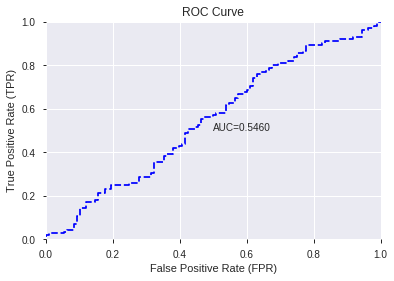

This function is available for GLM models only


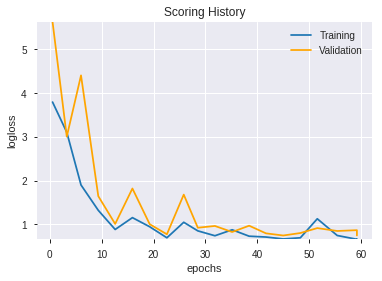

--2019-08-26 17:02:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_163720_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_163720_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLPIERCING',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGSTAR',
 'CDLADVANCEBLOCK',
 'CDLTHRUSTING',
 'CDLSHOOTINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'CDLMORNINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'is_month_start',
 'CDLINVERTEDHAMMER',
 'CDLSTICKSANDWICH',
 'CDLINNECK',
 'CDLONNECK',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'CDLGRAVESTONEDOJI',
 'CDLGAPSIDESIDEWHITE',
 'CDLDRAGONFLYDOJI',
 'CDLHAMMER',
 'HT_TRENDMODE',
 'CDLLADDERBOTTOM',
 'CDLHANGINGMAN',
 'HT_DCPERIOD',
 'CDL3LINESTRIKE',
 'is_month_end',
 'CDL2CROWS',
 'VAR_24',
 'VAR_30',
 'SAREXT',
 'VAR_20',
 'CDLRICKSHAWMAN',
 'CORREL_14',
 'VAR_14',
 'VAR_12',
 'OBV',
 'CORREL_12',
 'CDLDOJI',
 'CORREL_24',
 'aroondown_20',
 'CORREL_20',
 'VAR_8',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'CDLSEPARATINGLINES',
 'aroondown_14',
 'CORREL_30',
 'BOP',
 'CDLTASUKIGAP',
 'hour',
 'day',
 'TRANGE',
 'CDL3INSIDE',
 'aroonup_20',
 'weekday_name',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'DX_8',
 'BETA_14',
 'aroondown_1

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190826_170228_model_1  0.531746  0.692375              0.447255  0.49961  0.24961

variable  relative_importance  scaled_importance    percentage
0                  HT_DCPERIOD         9.144034e-03           1.000000  1.370083e-02
1                    CDLHAMMER         9.096280e-03           0.994777  1.362927e-02
2                CDLHIKKAKEMOD         7.886959e-03           0.862525  1.181731e-02
3           CDLCLOSINGMARUBOZU         7.606941e-03           0.831902  1.139775e-02
4                   CDLHIKKAKE         6.771863e-03           0.740577  1.014652e-02
...                        ...                  ...                ...           ...
1033  BBANDS_middleband_12_2_4         1.267481e-06           0.000139  1.899112e-06
1034   BBANDS_upperband_12_3_3         1.258245e-06           0.000138  1.885272e-06
1035                    MIN_20         1.107255e-06           0.000121  1.659038e-06
1036   BBANDS_upperband_12_1_4         7.136955e-07           0.000078  1.069355e-06
1037                    WMA_30         2.227959e-07           0.000024  3.338229e-07

[1038 rows x 4 columns]

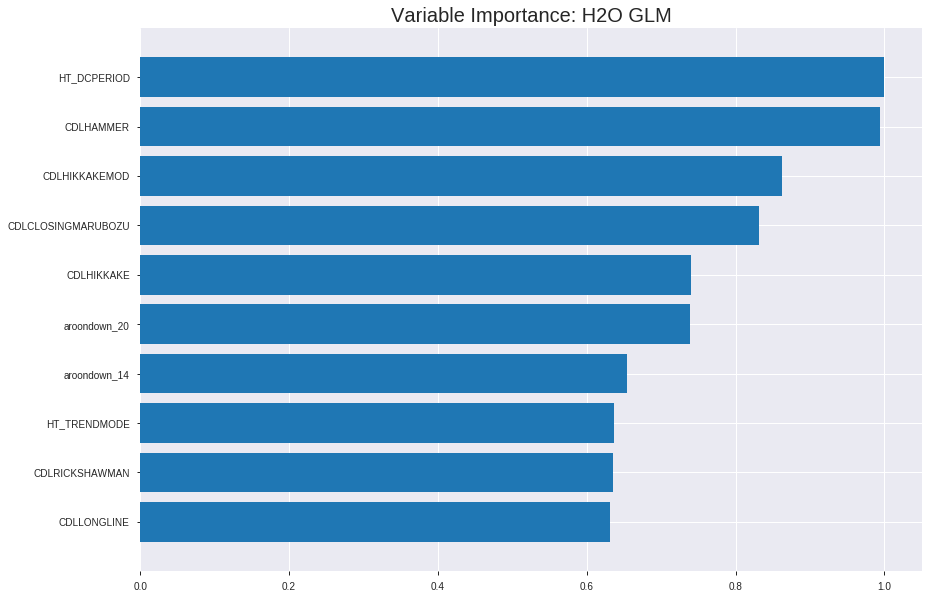

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_170228_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2467856671401529
RMSE: 0.4967752682452629
LogLoss: 0.6867022595809339
Null degrees of freedom: 1534
Residual degrees of freedom: 496
Null deviance: 2127.955981123116
Residual deviance: 2108.175936913467
AIC: 4186.175936913467
AUC: 0.6040371510931086
pr_auc: 0.590229656873709
Gini: 0.20807430218621725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47518376566402654: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      81   685   0.8943   (685.0/766.0)
1      30   739   0.039    (30.0/769.0)
Total  111  1424  0.4658   (715.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475184     0.673963  349
max f2                       0.442239     0.833876  399
max f0point5                 0.492451     0.591178  260
max accuracy                 0.492451     0.581107  260
max precision                0.598356     1         0
max recall                   0.442239     1         399
max specificity              0.598356     1         0
max absolute_mcc             0.492451     0.172084  260
max min_per_class_accuracy   0.50021      0.570871  212
max mean_per_class_accuracy  0.492451     0.580771  260

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 50.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.568187           1.62183   1.62183            0.8125           0.587299  0.8125                      0.587299            0.0169051       0.0169051                  62.183    62.183
    2        0.0201954                   0.545547           1.19766   1.41659            0.6              0.556618  0.709677                    0.572454            0.0117035       0.0286086                  19.7659   41.6586
    3        0.0306189                   0.540162           1.24756   1.35905            0.625            0.543105  0.680851                    0.562463            0.0130039       0.0416125                  24.7562   35.9046
    4        0.0403909                   0.532912           1.72995   1.44878            0.866667         0.535416  0.725806                    0.555919            0.0169051       0.0585176                  72.9952   44.8781
    5        0.0501629                   0.529952           0.931513  1.34801            0.466667         0.531427  0.675325                    0.551148            0.00910273      0.0676203                  -6.84872  34.8015
    6        0.100326                    0.522685           1.14063   1.24432            0.571429         0.525668  0.623377                    0.538408            0.0572172       0.124837                   14.0628   24.4321
    7        0.150489                    0.518315           1.16655   1.2184             0.584416         0.520557  0.61039                     0.532458            0.0585176       0.183355                   16.6551   21.8398
    8        0.2                         0.515076           1.28696   1.23537            0.644737         0.516469  0.618893                    0.5285              0.0637191       0.247074                   28.6958   23.5371
    9        0.300326                    0.509391           1.14063   1.20372            0.571429         0.511951  0.603037                    0.522971            0.114434        0.361508                   14.0628   20.3721
    10       0.4                         0.505409           1.05676   1.1671             0.529412         0.507299  0.584691                    0.519066            0.105332        0.46684                    5.67582   16.71
    11       0.500326                    0.500081           1.03693   1.141              0.519481         0.502833  0.571615                    0.515811            0.104031        0.570871                   3.69345   14.0999
    12       0.6                         0.495416           1.01762   1.1205             0.509804         0.497818  0.561346                    0.512822            0.10143         0.672302                   1.7619    12.0503
    13       0.699674                    0.490761           1.03067   1.1077             0.51634          0.493276  0.554935                    0.510037            0.102731        0.775033                   3.06654   10.7705
    14       0.8                         0.485104           0.725854  1.05982            0.363636         0.488064  0.530945                    0.507282            0.0728218       0.847854                   -27.4146  5.98179
    15       0.899674                    0.478455           0.913248  1.04358            0.457516         0.482016  0.52281                     0.504483            0.0910273       0.938882                   -8.67522  4.35795
    16       1                           0.442239           0.609199  1                  0.305195         0.469542  0.500977                    0.500977            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25236338079347675
RMSE: 0.5023578214713859
LogLoss: 0.6978961288548697
Null degrees of freedom: 437
Residual degrees of freedom: -601
Null deviance: 607.245508785986
Residual deviance: 611.3570088768658
AIC: 2689.3570088768656
AUC: 0.4547209181011998
pr_auc: 0.4500794958331976
Gini: -0.0905581637976004
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4786821426487033: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    216  0.96     (216.0/225.0)
1      1    212  0.0047   (1.0/213.0)
Total  10   428  0.4954   (217.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478682     0.661466  389
max f2                       0.473848     0.828149  395
max f0point5                 0.478682     0.550649  389
max accuracy                 0.607912     0.515982  0
max precision                0.607912     1         0
max recall                   0.473848     1         395
max specificity              0.607912     1         0
max absolute_mcc             0.478682     0.11814   389
max min_per_class_accuracy   0.509458     0.488263  201
max mean_per_class_accuracy  0.478682     0.517653  389

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 51.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.592998           0.822535  0.822535           0.4              0.599791  0.4                         0.599791            0.00938967      0.00938967                 -17.7465  -17.7465
    2        0.0205479                   0.573861           1.02817   0.913928           0.5              0.583441  0.444444                    0.592525            0.00938967      0.0187793                  2.8169    -8.6072
    3        0.0319635                   0.561792           0.822535  0.881288           0.4              0.567116  0.428571                    0.58345             0.00938967      0.028169                   -17.7465  -11.8712
    4        0.0410959                   0.55367            0         0.685446           0                0.557103  0.333333                    0.577595            0               0.028169                   -100      -31.4554
    5        0.0502283                   0.55054            0.514085  0.654289           0.25             0.551623  0.318182                    0.572873            0.00469484      0.0328638                  -48.5915  -34.5711
    6        0.100457                    0.536026           1.02817   0.841229           0.5              0.543067  0.409091                    0.55797             0.0516432       0.084507                   2.8169    -15.8771
    7        0.150685                    0.52915            0.747759  0.810073           0.363636         0.532245  0.393939                    0.549395            0.0375587       0.122066                   -25.2241  -18.9927
    8        0.200913                    0.525574           1.40205   0.958067           0.681818         0.527506  0.465909                    0.543923            0.0704225       0.192488                   40.2049   -4.19334
    9        0.30137                     0.519701           0.841229  0.919121           0.409091         0.522561  0.44697                     0.536802            0.084507        0.276995                   -15.8771  -8.08792
    10       0.399543                    0.514281           0.860793  0.904789           0.418605         0.516927  0.44                        0.531919            0.084507        0.361502                   -13.9207  -9.52113
    11       0.5                         0.509284           1.26184   0.976526           0.613636         0.511858  0.474886                    0.527888            0.126761        0.488263                   26.1844   -2.34742
    12       0.600457                    0.505207           0.701024  0.930434           0.340909         0.507214  0.452471                    0.524429            0.0704225       0.558685                   -29.8976  -6.95657
    13       0.69863                     0.500689           1.00426   0.940808           0.488372         0.503108  0.457516                    0.521433            0.0985915       0.657277                   0.425811  -5.91918
    14       0.799087                    0.49692            1.16837   0.969416           0.568182         0.498829  0.471429                    0.518592            0.117371        0.774648                   16.8374   -3.05835
    15       0.899543                    0.48931            1.0749    0.981197           0.522727         0.493837  0.477157                    0.515827            0.107981        0.882629                   7.4904    -1.88032
    16       1                           0.467572           1.16837   1                  0.568182         0.48236   0.486301                    0.5


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 17:02:32  0.000 sec   2            3.2       1039          1.3734            1.39579
    2019-08-26 17:02:33  1.973 sec   4            2.3       1039          1.37005           1.3976
    2019-08-26 17:02:35  3.977 sec   6            1.7       1039          1.36606           1.39999
    2019-08-26 17:02:37  5.967 sec   8            1.2       1039          1.36146           1.40284
    2019-08-26 17:02:39  7.940 sec   10           0.9       1039          1.35624           1.40619

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5636363636363636)

('F1', 0.6755852842809366)

('auc', 0.5317460317460317)

('logloss', 0.6923752514406492)

('mean_per_class_error', 0.435681216931217)

('rmse', 0.4996101190038648)

('mse', 0.24961027101105596)

glm prediction progress: |████████████████████████████████████████████████| 100%


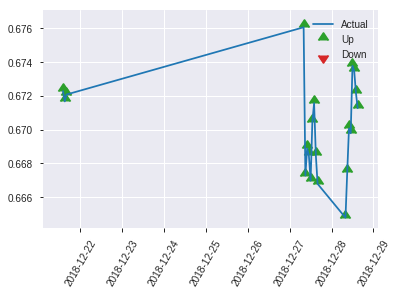


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24961027101105596
RMSE: 0.4996101190038648
LogLoss: 0.6923752514406492
Null degrees of freedom: 219
Residual degrees of freedom: -819
Null deviance: 304.9699645761388
Residual deviance: 304.6451106338856
AIC: 2382.6451106338855
AUC: 0.5317460317460317
pr_auc: 0.5114612672643086
Gini: 0.06349206349206349
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49519889174020554: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      22   86   0.7963   (86.0/108.0)
1      11   101  0.0982   (11.0/112.0)
Total  33   187  0.4409   (97.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495199     0.675585  186
max f2                       0.46814      0.838323  219
max f0point5                 0.495199     0.587209  186
max accuracy                 0.515594     0.563636  101
max precision                0.515594     0.578431  101
max recall                   0.46814      1         219
max specificity              0.569075     0.990741  0
max absolute_mcc             0.495199     0.14769   186
max min_per_class_accuracy   0.513998     0.546296  110
max mean_per_class_accuracy  0.515594     0.564319  101

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.560911           0.654762  0.654762           0.333333         0.564257  0.333333                    0.564257            0.00892857      0.00892857                 -34.5238  -34.5238
    2        0.0227273                   0.554798           0.982143  0.785714           0.5              0.55735   0.4                         0.561494            0.00892857      0.0178571                  -1.78571  -21.4286
    3        0.0318182                   0.550952           0.982143  0.841837           0.5              0.552669  0.428571                    0.558973            0.00892857      0.0267857                  -1.78571  -15.8163
    4        0.0409091                   0.546912           0.982143  0.873016           0.5              0.549017  0.444444                    0.556761            0.00892857      0.0357143                  -1.78571  -12.6984
    5        0.05                        0.546304           1.96429   1.07143            1                0.546621  0.545455                    0.554917            0.0178571       0.0535714                  96.4286   7.14286
    6        0.1                         0.538497           0.714286  0.892857           0.363636         0.543733  0.454545                    0.549325            0.0357143       0.0892857                  -28.5714  -10.7143
    7        0.15                        0.530951           0.892857  0.892857           0.454545         0.533683  0.454545                    0.544111            0.0446429       0.133929                   -10.7143  -10.7143
    8        0.2                         0.528414           0.892857  0.892857           0.454545         0.529748  0.454545                    0.540521            0.0446429       0.178571                   -10.7143  -10.7143
    9        0.3                         0.523284           1.25      1.0119             0.636364         0.525838  0.515152                    0.535626            0.125           0.303571                   25        1.19048
    10       0.4                         0.517449           1.25      1.07143            0.636364         0.520068  0.545455                    0.531737            0.125           0.428571                   25        7.14286
    11       0.5                         0.514264           1.16071   1.08929            0.590909         0.515897  0.554545                    0.528569            0.116071        0.544643                   16.0714   8.92857
    12       0.6                         0.51124            0.892857  1.05655            0.454545         0.512689  0.537879                    0.525922            0.0892857       0.633929                   -10.7143  5.65476
    13       0.7                         0.505209           0.892857  1.03316            0.454545         0.508567  0.525974                    0.523443            0.0892857       0.723214                   -10.7143  3.31633
    14       0.8                         0.500092           1.07143   1.03795            0.545455         0.503352  0.528409                    0.520932            0.107143        0.830357                   7.14286   3.79464
    15       0.9                         0.489265           0.803571  1.0119             0.409091         0.494951  0.515152                    0.518045            0.0803571       0.910714                   -19.6429  1.19048
    16       1                           0.46814            0.892857  1                  0.454545         0.479937  0.509091                    0.514234  

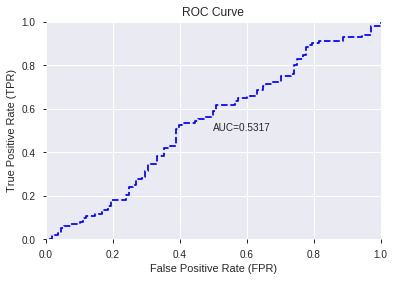

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


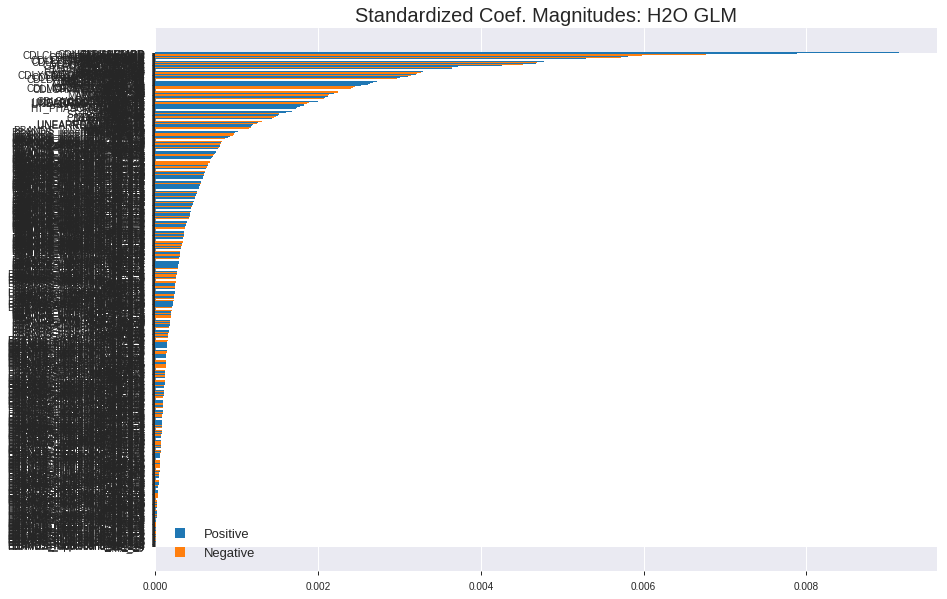

'log_likelihood'
--2019-08-26 17:03:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_170228_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_170228_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['HT_DCPERIOD',
 'CDLHAMMER',
 'CDLHIKKAKEMOD',
 'CDLCLOSINGMARUBOZU',
 'CDLHIKKAKE',
 'aroondown_20',
 'aroondown_14',
 'HT_TRENDMODE',
 'CDLRICKSHAWMAN',
 'CDLLONGLINE',
 'BETA_12',
 'BOP',
 'CDLDOJI',
 'CDLMARUBOZU',
 'CDLEVENINGDOJISTAR',
 'CDLHARAMICROSS',
 'CDLENGULFING',
 'BETA_14',
 'aroondown_12',
 'CDLLONGLEGGEDDOJI',
 'CDLPIERCING',
 'CDLINNECK',
 'CDLONNECK',
 'CDLSPINNINGTOP',
 'OBV',
 'CDLADVANCEBLOCK',
 'CDLSHORTLINE',
 'is_month_end',
 'days_in_month',
 'CDL2CROWS',
 'AD',
 'is_month_start',
 'BETA_8',
 'day',
 'MACDFIX_signal_24',
 'HT_PHASOR_inphase',
 'CORREL_24',
 'aroondown_8',
 'weekday_name',
 'MINUS_DI_30',
 'VAR_14',
 'CDL3OUTSIDE',
 'CDLBELTHOLD',
 'MACDEXT_hist',
 'MACDFIX_signal_20',
 'CDLSHOOTINGSTAR',
 'CDLXSIDEGAP3METHODS',
 'AROONOSC_14',
 'STOCHF_fastk',
 'TRANGE',
 'CDLSEPARATINGLINES',
 'MACDFIX_hist_14',
 'MACDFIX_hist_20',
 'SAREXT',
 'CDLDARKCLOUDCOVER',
 'ADX_12',
 'MACDFIX_hist_12',
 'Volume',
 'MACDFIX_hist_24',
 'CDL3LINESTRIKE',
 'ADX_14',
 'M

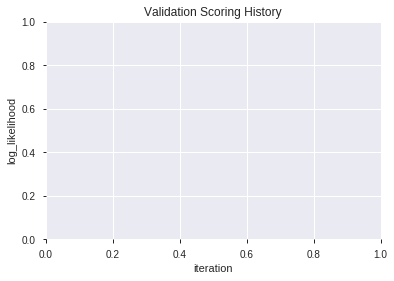

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_170315_model_6  0.567791  0.686861              0.486111  0.496798  0.246808
1  XGBoost_grid_1_AutoML_20190826_170315_model_7  0.566634  0.690354              0.457341  0.498467  0.248469
2               XGBoost_1_AutoML_20190826_170315  0.557126  0.692618              0.466931  0.499592  0.249592
3  XGBoost_grid_1_AutoML_20190826_170315_model_2  0.539269  0.691544              0.423942  0.499230  0.249230
4  XGBoost_grid_1_AutoML_20190826_170315_model_5  0.531250  0.718077              0.443287  0.510893  0.261012
5  XGBoost_grid_1_AutoML_20190826_170315_model_4  0.519428  0.696489              0.500000  0.501597  0.251600
6  XGBoost_grid_1_AutoML_20190826_170315_model_1  0.505870  0.698779              0.476852  0.502884  0.252893
7  XGBoost_grid_1_AutoML_20190826_170315_model_3  0.495536  0.708347              0.500000  0.507327  0.257381
8               XGBoost_3_AutoML_20190826_170315  0.483631  0.708459              0.480985  0.507485  0.257541
9               XGBoost_2_AutoML_20190826_170315  0.457176  0.718993              0.485780  0.512432  0.262587

variable  relative_importance  scaled_importance  percentage
0                        BOP           148.346100           1.000000    0.021915
1                HT_DCPERIOD           133.265472           0.898342    0.019687
2                      MFI_8            95.241859           0.642025    0.014070
3                     ULTOSC            94.652672           0.638053    0.013983
4                    ADXR_14            81.624214           0.550228    0.012058
..                       ...                  ...                ...         ...
304               PLUS_DI_30             3.102733           0.020915    0.000458
305            MINMAX_min_24             3.087141           0.020810    0.000456
306  BBANDS_lowerband_14_0_3             3.084600           0.020793    0.000456
307                  DEMA_20             2.350039           0.015842    0.000347
308                    RSI_8             2.325115           0.015674    0.000343

[309 rows x 4 columns]

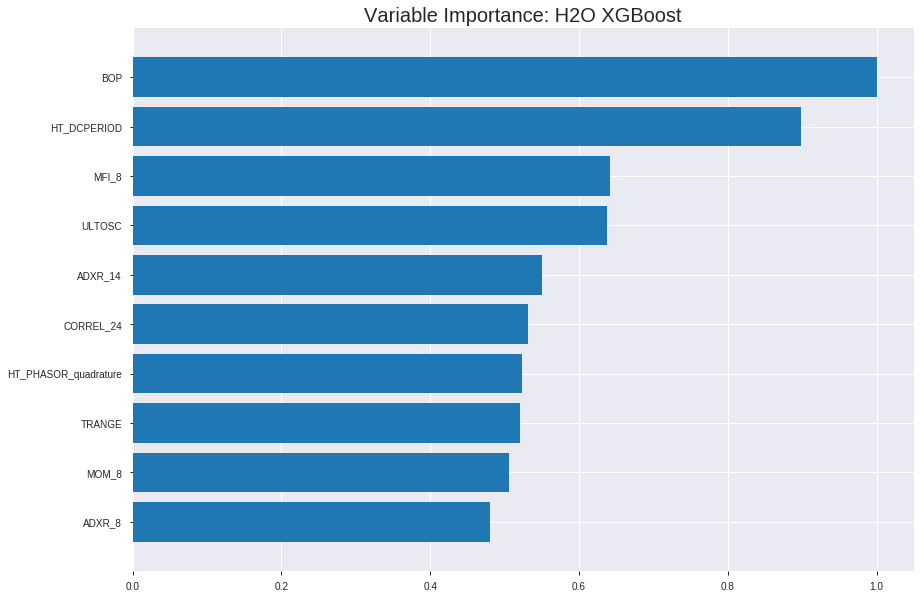

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_170315_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17402084583762942
RMSE: 0.4171580585792745
LogLoss: 0.536823950245652
Mean Per-Class Error: 0.10364584571193813
AUC: 0.9599629236029295
pr_auc: 0.9593683726957152
Gini: 0.9199258472058589
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4855235069990158: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      662  104  0.1358   (104.0/766.0)
1      55   714  0.0715   (55.0/769.0)
Total  717  818  0.1036   (159.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.485524     0.899811  214
max f2                       0.455539     0.932288  242
max f0point5                 0.517989     0.905356  183
max accuracy                 0.485524     0.896417  214
max precision                0.791156     1         0
max recall                   0.3166       1         367
max specificity              0.791156     1         0
max absolute_mcc             0.485524     0.794428  214
max min_per_class_accuracy   0.498181     0.883812  201
max mean_per_class_accuracy  0.485524     0.896354  214

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 49.89 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.736451           1.9961     1.9961             1                0.757082  1                           0.757082            0.0208062       0.0208062                  99.6099   99.6099
    2        0.0201954                   0.725206           1.9961     1.9961             1                0.730163  1                           0.744057            0.0195059       0.0403121                  99.6099   99.6099
    3        0.0306189                   0.714679           1.9961     1.9961             1                0.718282  1                           0.735282            0.0208062       0.0611183                  99.6099   99.6099
    4        0.0403909                   0.701539           1.9961     1.9961             1                0.708426  1                           0.728785            0.0195059       0.0806242                  99.6099   99.6099
    5        0.0501629                   0.691211           1.9961     1.9961             1                0.695818  1                           0.722363            0.0195059       0.10013                    99.6099   99.6099
    6        0.100326                    0.648429           1.9961     1.9961             1                0.671311  1                           0.696837            0.10013         0.20026                    99.6099   99.6099
    7        0.150489                    0.622881           1.9961     1.9961             1                0.635464  1                           0.676379            0.10013         0.30039                    99.6099   99.6099
    8        0.2                         0.603765           1.91731    1.97659            0.960526         0.612736  0.990228                    0.660624            0.0949285       0.395319                   91.7305   97.6593
    9        0.300977                    0.568406           1.89307    1.94857            0.948387         0.587033  0.97619                     0.635935            0.191157        0.586476                   89.3074   94.8573
    10       0.4                         0.534471           1.73345    1.89532            0.868421         0.551885  0.949511                    0.615127            0.171651        0.758127                   73.3454   89.5319
    11       0.500326                    0.498041           1.25728    1.76738            0.62987          0.516837  0.885417                    0.595418            0.126138        0.884265                   25.7283   76.7379
    12       0.6                         0.461031           0.834969   1.61248            0.418301         0.47845   0.807818                    0.575987            0.083225        0.96749                    -16.5031  61.2484
    13       0.699674                    0.422233           0.260928   1.41994            0.130719         0.440635  0.711359                    0.556705            0.0260078       0.993498                   -73.9072  41.9944
    14       0.8                         0.389936           0.0129617  1.2435             0.00649351       0.406956  0.622964                    0.537925            0.00130039      0.994798                   -98.7038  24.3498
    15       0.899674                    0.350516           0.0260928  1.10862            0.0130719        0.371277  0.555395                    0.519463            0.00260078      0.997399                   -97.3907  10.8623
    16       1                           0.210466           0.0259234  1                  0.012987         0.314744  0.500977                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2635367735096473
RMSE: 0.5133583285675293
LogLoss: 0.7211366376276965
Mean Per-Class Error: 0.4928638497652582
AUC: 0.4570266040688576
pr_auc: 0.4545548582183711
Gini: -0.08594679186228482
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2896782159805298: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    223  0.9911   (223.0/225.0)
1      0    213  0        (0.0/213.0)
Total  2    436  0.5091   (223.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.289678     0.656394  397
max f2                       0.289678     0.826863  397
max f0point5                 0.289678     0.5442    397
max accuracy                 0.720955     0.511416  0
max precision                0.370226     0.490148  370
max recall                   0.289678     1         397
max specificity              0.720955     0.995556  0
max absolute_mcc             0.477777     0.101768  234
max min_per_class_accuracy   0.498182     0.469484  197
max mean_per_class_accuracy  0.370226     0.507136  370

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 49.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.698649           0.822535  0.822535           0.4              0.710634  0.4                         0.710634            0.00938967      0.00938967                 -17.7465  -17.7465
    2        0.0205479                   0.678345           1.02817   0.913928           0.5              0.686644  0.444444                    0.699972            0.00938967      0.0187793                  2.8169    -8.6072
    3        0.0319635                   0.659911           0.822535  0.881288           0.4              0.669651  0.428571                    0.689143            0.00938967      0.028169                   -17.7465  -11.8712
    4        0.0410959                   0.651375           0.514085  0.799687           0.25             0.654706  0.388889                    0.68149             0.00469484      0.0328638                  -48.5915  -20.0313
    5        0.0502283                   0.644117           1.02817   0.841229           0.5              0.647152  0.409091                    0.675247            0.00938967      0.0422535                  2.8169    -15.8771
    6        0.100457                    0.612075           0.934699  0.887964           0.454545         0.627437  0.431818                    0.651342            0.0469484       0.0892019                  -6.53009  -11.2036
    7        0.150685                    0.58594            1.02817   0.934699           0.5              0.597646  0.454545                    0.633443            0.0516432       0.140845                   2.8169    -6.53009
    8        0.200913                    0.565726           0.934699  0.934699           0.454545         0.57785   0.454545                    0.619545            0.0469484       0.187793                   -6.53009  -6.53009
    9        0.30137                     0.543225           0.841229  0.903542           0.409091         0.553286  0.439394                    0.597459            0.084507        0.2723                     -15.8771  -9.64575
    10       0.399543                    0.520997           1.00426   0.92829            0.488372         0.532289  0.451429                    0.581445            0.0985915       0.370892                   0.425811  -7.17103
    11       0.5                         0.498044           0.981434  0.938967           0.477273         0.508266  0.456621                    0.566743            0.0985915       0.469484                   -1.85659  -6.10329
    12       0.600457                    0.47618            0.841229  0.922616           0.409091         0.487965  0.448669                    0.553563            0.084507        0.553991                   -15.8771  -7.73845
    13       0.69863                     0.452222           1.0999    0.947528           0.534884         0.462445  0.460784                    0.540759            0.107981        0.661972                   9.99017   -5.24717
    14       0.799087                    0.41779            1.16837   0.975292           0.568182         0.43657   0.474286                    0.527661            0.117371        0.779343                   16.8374   -2.47082
    15       0.899543                    0.382142           1.16837   0.996854           0.568182         0.403554  0.484772                    0.513801            0.117371        0.896714                   16.8374   -0.314578
    16       1                           0.259609           1.02817   1                  0.5              0.343863  0.486301                    0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:03:58  26.518 sec  0                  0.5              0.693147            0.5             0                  1                0.499023                         0.5                0.693147              0.5               0                    1                  0.513699
    2019-08-26 17:03:59  27.622 sec  5                  0.488787         0.670919            0.76061         0.757032           1.9961           0.327687                         0.500934           0.69502               0.490339          0.476471             0.822535           0.511416
    2019-08-26 17:03:59  27.845 sec  10                 0.478618         0.65109             0.836886        0.835413           1.9961           0.25798                          0.503156           0.699516              0.469682          0.459379             0.685446           0.509132
    2019-08-26 17:04:00  28.070 sec  15                 0.468929         0.63246             0.873785        0.874664           1.9961           0.207818                         0.50348            0.700231              0.485749          0.468815             0.822535           0.513699
    2019-08-26 17:04:00  28.288 sec  20                 0.460109         0.615687            0.891367        0.891891           1.9961           0.197394                         0.503931           0.701206              0.489369          0.479554             1.2338             0.513699
    2019-08-26 17:04:00  28.536 sec  25                 0.453028         0.602332            0.906267        0.905344           1.9961           0.172638                         0.505747           0.70493               0.475576          0.469159             1.64507            0.513699
    2019-08-26 17:04:00  28.798 sec  30                 0.445773         0.588836            0.919768        0.920404           1.9961           0.169381                         0.507332           0.708208              0.469254          0.461975             1.2338             0.513699
    2019-08-26 17:04:01  29.017 sec  35                 0.439251         0.576762            0.929539        0.930106           1.9961           0.151792                         0.508818           0.711347              0.464674          0.456345             0.411268           0.511416
    2019-08-26 17:04:01  29.228 sec  40                 0.433505         0.566175            0.936968        0.936457           1.9961           0.138762                         0.510378           0.714723              0.463871          0.4568               0.822535           0.509132
    2019-08-26 17:04:01  29.459 sec  45                 0.424897         0.550591            0.948686        0.948241           1.9961           0.12443                          0.511844           0.717882              0.458998          0.456281             0.411268           0.509132
    2019-08-26 17:04:01  29.714 sec  50                 0.417158         0.536824            0.959963        0.959368           1.9961           0.103583                         0.513358           0.721137              0.457027          0.454555             0.822535           0.509132

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      148.34609985351562     1.0                   0.021914936180854674
HT_DCPERIOD              133.26547241210938     0.8983415980851697    0.019687098790643492
MFI_8                    95.24185943603516      0.6420246944819024    0.014069930206103611
ULTOSC                   94.65267181396484      0.6380529849280139    0.013982890444701253
ADXR_14                  81.62421417236328      0.5502282449822619    0.01205821687368994
---                      ---                    ---                   ---
PLUS_DI_30               3.1027326583862305     0.020915498698314442  0.00045836181916431
MINMAX_min_24            3.0871410369873047     0.0208103956897802    0.00045605849343986624
BBANDS_lowerband_14_0_3  3.0846004486083984     0.020793269601656447  0.00045568317631160656
DEMA_20                  2.350038528442383      0.015841592942200226  0.00034716749833139574
RSI_8                    2.3251147270202637     0.015673581774756456  0.0003434855443191946


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5727272727272728)

('F1', 0.6808510638297872)

('auc', 0.5677910052910052)

('logloss', 0.6868614375968842)

('mean_per_class_error', 0.42427248677248675)

('rmse', 0.4967978167932295)

('mse', 0.24680807077051922)

xgboost prediction progress: |████████████████████████████████████████████| 100%


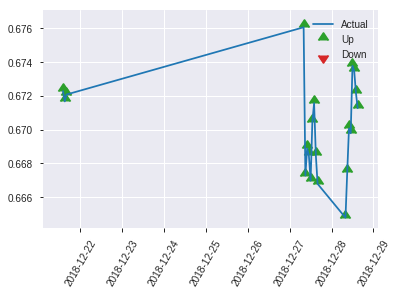


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24680807077051922
RMSE: 0.4967978167932295
LogLoss: 0.6868614375968842
Mean Per-Class Error: 0.42427248677248675
AUC: 0.5677910052910052
pr_auc: 0.5755544717745965
Gini: 0.13558201058201047
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32063475251197815: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    105  0.9722   (105.0/108.0)
1      0    112  0        (0.0/112.0)
Total  3    217  0.4773   (105.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320635     0.680851  216
max f2                       0.320635     0.842105  216
max f0point5                 0.426324     0.57971   178
max accuracy                 0.542828     0.572727  73
max precision                0.689275     0.8       4
max recall                   0.320635     1         216
max specificity              0.728162     0.990741  0
max absolute_mcc             0.573796     0.167984  54
max min_per_class_accuracy   0.496158     0.553571  108
max mean_per_class_accuracy  0.542828     0.575728  73

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 50.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.69939            1.30952   1.30952            0.666667         0.717771  0.666667                    0.717771            0.0178571       0.0178571                  30.9524   30.9524
    2        0.0227273                   0.68672            1.96429   1.57143            1                0.694182  0.8                         0.708336            0.0178571       0.0357143                  96.4286   57.1429
    3        0.0318182                   0.67967            0.982143  1.40306            0.5              0.681801  0.714286                    0.700754            0.00892857      0.0446429                  -1.78571  40.3061
    4        0.0409091                   0.677025           0         1.09127            0                0.678422  0.555556                    0.695791            0               0.0446429                  -100      9.12698
    5        0.05                        0.664247           0.982143  1.07143            0.5              0.672999  0.545455                    0.691647            0.00892857      0.0535714                  -1.78571  7.14286
    6        0.1                         0.623903           1.60714   1.33929            0.818182         0.642752  0.681818                    0.6672              0.0803571       0.133929                   60.7143   33.9286
    7        0.15                        0.606965           1.42857   1.36905            0.727273         0.615644  0.69697                     0.650015            0.0714286       0.205357                   42.8571   36.9048
    8        0.2                         0.589286           0.892857  1.25               0.454545         0.599322  0.636364                    0.637341            0.0446429       0.25                       -10.7143  25
    9        0.3                         0.557612           1.16071   1.22024            0.590909         0.573578  0.621212                    0.616087            0.116071        0.366071                   16.0714   22.0238
    10       0.4                         0.527208           0.892857  1.13839            0.454545         0.54031   0.579545                    0.597143            0.0892857       0.455357                   -10.7143  13.8393
    11       0.5                         0.494046           0.982143  1.10714            0.5              0.509036  0.563636                    0.579521            0.0982143       0.553571                   -1.78571  10.7143
    12       0.6                         0.475322           0.714286  1.04167            0.363636         0.482963  0.530303                    0.563428            0.0714286       0.625                      -28.5714  4.16667
    13       0.7                         0.458409           0.803571  1.00765            0.409091         0.465385  0.512987                    0.549422            0.0803571       0.705357                   -19.6429  0.765306
    14       0.8                         0.434429           1.25      1.03795            0.636364         0.449363  0.528409                    0.536915            0.125           0.830357                   25        3.79464
    15       0.9                         0.393797           0.714286  1.00198            0.363636         0.411699  0.510101                    0.523002            0.0714286       0.901786                   -28.5714  0.198413
    16       1                           0.261866           0.982143  1                  0.5              0.349555  0.509091                    0.505657            

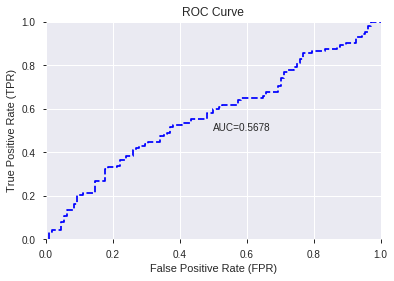

This function is available for GLM models only


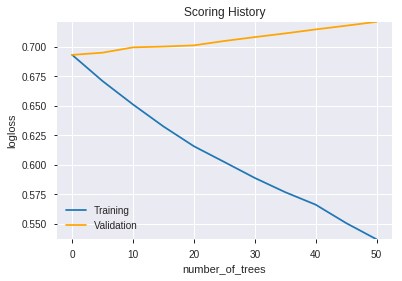

--2019-08-26 17:04:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_170315_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_170315_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'HT_DCPERIOD',
 'MFI_8',
 'ULTOSC',
 'ADXR_14',
 'CORREL_24',
 'HT_PHASOR_quadrature',
 'TRANGE',
 'MOM_8',
 'ADXR_8',
 'DIV',
 'CORREL_20',
 'STOCHF_fastk',
 'HT_PHASOR_inphase',
 'ADX_24',
 'ADOSC',
 'BETA_14',
 'BETA_20',
 'day',
 'ADX_20',
 'MACDEXT_hist',
 'WILLR_12',
 'MFI_12',
 'MFI_20',
 'STDDEV_8',
 'PLUS_DI_8',
 'CCI_14',
 'DX_12',
 'STDDEV_14',
 'ATR_20',
 'hour',
 'NATR_8',
 'STOCH_slowk',
 'CORREL_14',
 'MFI_24',
 'ADX_12',
 'BETA_30',
 'STDDEV_20',
 'MOM_14',
 'LINEARREG_ANGLE_8',
 'DX_20',
 'BETA_24',
 'MACDFIX_hist_24',
 'PLUS_DM_14',
 'MOM_24',
 'ADX_8',
 'aroondown_20',
 'BETA_12',
 'OBV',
 'CCI_8',
 'STOCH_slowd',
 'DX_30',
 'SAREXT',
 'DX_14',
 'ATR_8',
 'aroondown_30',
 'LINEARREG_ANGLE_20',
 'BETA_8',
 'CMO_20',
 'DX_8',
 'STOCHRSI_fastd',
 'MOM_30',
 'PLUS_DM_20',
 'MINUS_DM_8',
 'LINEARREG_ANGLE_12',
 'WILLR_8',
 'BBANDS_lowerband_30_7_2',
 'aroonup_14',
 'MINUS_DM_24',
 'MINUS_DI_30',
 'ATR_30',
 'Volume',
 'BBANDS_lowerband_30_7_3',
 'MINUS_DM_14',
 '

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

105

['BBANDS_lowerband_14_2_5',
 'BBANDS_lowerband_14_3_3',
 'BBANDS_middleband_14_3_4',
 'BBANDS_middleband_14_3_5',
 'MA_14_5',
 'MAVP_14_5',
 'BBANDS_lowerband_14_5_3',
 'BBANDS_upperband_14_5_4',
 'BBANDS_upperband_14_6_3',
 'BBANDS_upperband_14_6_4',
 'BBANDS_upperband_14_6_5',
 'BBANDS_upperband_14_7_3',
 'KAMA_20',
 'BBANDS_middleband_20_0_4',
 'MA_20_1',
 'BBANDS_middleband_20_2_4',
 'MAVP_20_3',
 'MAVP_20_7',
 'BBANDS_upperband_20_7_2',
 'BBANDS_lowerband_24_2_3',
 'BBANDS_middleband_24_2_4',
 'SMA_30',
 'BBANDS_middleband_30_0_3',
 'BBANDS_upperband_30_6_4',
 'BBANDS_lowerband_30_7_3',
 'ADX_8',
 'ADXR_8',
 'aroondown_8',
 'MACDFIX_8',
 'AROONOSC_12',
 'CCI_12',
 'MACDFIX_hist_12',
 'MFI_12',
 'MOM_12',
 'ROCR100_12',
 'WILLR_12',
 'ADXR_14',
 'aroondown_14',
 'aroonup_14',
 'AROONOSC_14',
 'CMO_14',
 'MACDFIX_hist_14',
 'MFI_14',
 'MINUS_DI_14',
 'MINUS_DM_14',
 'PLUS_DI_14',
 'PLUS_DM_14',
 'ROCR_14',
 'ROCR100_14',
 'TRIX_14',
 'WILLR_14',
 'aroondown_20',
 'aroonup_20',
 'CCI

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190826_170526  0.546958  0.759992              0.490741  0.517114  0.267407
1  DeepLearning_grid_1_AutoML_20190826_170526_model_7  0.545800  0.726746              0.490741  0.515283  0.265516
2  DeepLearning_grid_1_AutoML_20190826_170526_model_6  0.517940  0.709566              0.462632  0.506780  0.256826
3  DeepLearning_grid_1_AutoML_20190826_170526_model_5  0.510665  0.697630              0.486111  0.502207  0.252212
4  DeepLearning_grid_1_AutoML_20190826_170526_model_9  0.504960  0.693644              0.500000  0.500248  0.250248
5  DeepLearning_grid_1_AutoML_20190826_170526_model_3  0.503638  0.781609              0.495370  0.532450  0.283503
6  DeepLearning_grid_1_AutoML_20190826_170526_model_4  0.488426  0.848269              0.495370  0.551570  0.304230
7  DeepLearning_grid_1_AutoML_20190826_170526_model_2  0.476852  0.909246              0.500000  0.569064  0.323834
8  DeepLearning_grid_1_AutoML_20190826_170526_model_8  0.466022  0.693663              0.500000  0.500258  0.250258
9  DeepLearning_grid_1_AutoML_20190826_170526_model_1  0.463294  1.243205              0.481151  0.597527  0.357039

variable  relative_importance  scaled_importance  percentage
0            ROCR100_20             1.000000           1.000000    0.013809
1               ROCR_14             0.964773           0.964773    0.013322
2            aroonup_20             0.955598           0.955598    0.013196
3          MACDEXT_hist             0.947013           0.947013    0.013077
4     MACDFIX_signal_20             0.942318           0.942318    0.013012
..                  ...                  ...                ...         ...
100               ADX_8             0.439588           0.439588    0.006070
101          CDLHIKKAKE             0.422980           0.422980    0.005841
102  CDLCLOSINGMARUBOZU             0.412332           0.412332    0.005694
103           MAVP_14_5             0.390187           0.390187    0.005388
104             MA_14_5             0.345834           0.345834    0.004776

[105 rows x 4 columns]

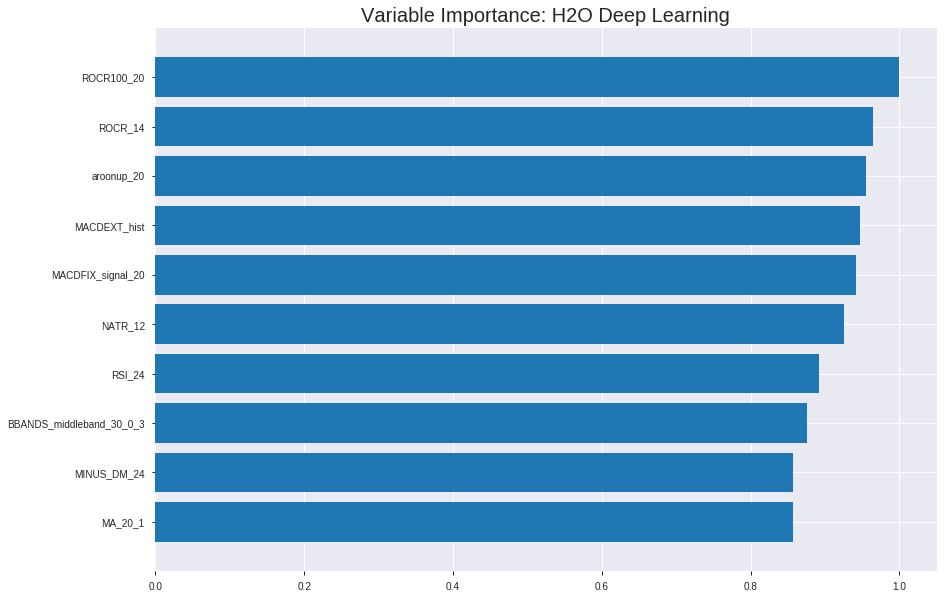

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190826_170526


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23181390085369893
RMSE: 0.48147056073419375
LogLoss: 0.6558707022692953
Mean Per-Class Error: 0.3764799152539495
AUC: 0.6526303191218462
pr_auc: 0.6625772024309979
Gini: 0.30526063824369243
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34934456754354865: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      156  610   0.7963   (610.0/766.0)
1      62   707   0.0806   (62.0/769.0)
Total  218  1317  0.4378   (672.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349345     0.677852  308
max f2                       0.0500564    0.833876  399
max f0point5                 0.486899     0.624139  190
max accuracy                 0.486899     0.623453  190
max precision                0.949904     1         0
max recall                   0.0500564    1         399
max specificity              0.949904     1         0
max absolute_mcc             0.486899     0.24762   190
max min_per_class_accuracy   0.47465      0.612484  200
max mean_per_class_accuracy  0.486899     0.62352   190

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 47.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.801766           1.9961    1.9961             1                0.858616  1                           0.858616            0.0208062       0.0208062                  99.6099   99.6099
    2        0.0201954                   0.758524           1.72995   1.86732            0.866667         0.775493  0.935484                    0.818395            0.0169051       0.0377113                  72.9952   86.7318
    3        0.0306189                   0.725951           1.49707   1.74128            0.75             0.742615  0.87234                     0.792598            0.0156047       0.053316                   49.7074   74.1278
    4        0.0403909                   0.710825           1.72995   1.73854            0.866667         0.71885   0.870968                    0.774756            0.0169051       0.0702211                  72.9952   73.8538
    5        0.0501629                   0.694422           1.86303   1.76279            0.933333         0.701875  0.883117                    0.760558            0.0182055       0.0884265                  86.3026   76.2789
    6        0.100326                    0.639571           1.39986   1.58133            0.701299         0.663073  0.792208                    0.711815            0.0702211       0.158648                   39.9862   58.1325
    7        0.150489                    0.609018           1.37394   1.5122             0.688312         0.623341  0.757576                    0.682324            0.0689207       0.227568                   37.3938   51.2196
    8        0.2                         0.582841           0.971785  1.37841            0.486842         0.595741  0.690554                    0.66089             0.0481144       0.275683                   -2.8215   37.8414
    9        0.300326                    0.54134            1.2184    1.32496            0.61039          0.561429  0.663774                    0.627664            0.122237        0.397919                   21.8398   32.4959
    10       0.4                         0.506708           1.13504   1.27763            0.568627         0.525748  0.640065                    0.602268            0.113134        0.511053                   13.5037   27.7633
    11       0.500326                    0.474233           1.02397   1.22677            0.512987         0.491079  0.614583                    0.579972            0.102731        0.613784                   2.39728   22.6769
    12       0.6                         0.44538            0.848016  1.16385            0.424837         0.459179  0.583062                    0.559906            0.0845254       0.698309                   -15.1984  16.3849
    13       0.699674                    0.413085           0.808877  1.11328            0.405229         0.428502  0.557728                    0.541186            0.0806242       0.778934                   -19.1123  11.328
    14       0.8                         0.375346           0.907318  1.08745            0.454545         0.394406  0.544788                    0.522779            0.0910273       0.869961                   -9.26824  8.74512
    15       0.899674                    0.323453           0.717552  1.04647            0.359477         0.351391  0.524258                    0.503791            0.0715215       0.941482                   -28.2448  4.64703
    16       1                           0.0500564          0.583276  1                  0.292208         0.24882   0.500977                    0.478211          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2841232583418486
RMSE: 0.5330321363124821
LogLoss: 0.7995342362296993
Mean Per-Class Error: 0.48957746478873243
AUC: 0.4769953051643192
pr_auc: 0.47454698980164856
Gini: -0.04600938967136159
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11760378856983163: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    223  0.9911   (223.0/225.0)
1      0    213  0        (0.0/213.0)
Total  2    436  0.5091   (223.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.117604     0.656394   397
max f2                       0.117604     0.826863   397
max f0point5                 0.117604     0.5442     397
max accuracy                 0.667054     0.520548   50
max precision                0.999687     1          0
max recall                   0.117604     1          397
max specificity              0.999687     1          0
max absolute_mcc             0.793057     0.0773528  20
max min_per_class_accuracy   0.500496     0.502222   197
max mean_per_class_accuracy  0.663618     0.510423   53

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 50.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.990201           1.2338    1.2338             0.6              0.994349  0.6                         0.994349            0.0140845       0.0140845                  23.3803   23.3803
    2        0.0205479                   0.974537           1.02817   1.14241            0.5              0.984668  0.555556                    0.990047            0.00938967      0.0234742                  2.8169    14.241
    3        0.0319635                   0.915607           0         0.734406           0                0.941577  0.357143                    0.972736            0               0.0234742                  -100      -26.5594
    4        0.0410959                   0.849137           0.514085  0.685446           0.25             0.880798  0.333333                    0.952305            0.00469484      0.028169                   -48.5915  -31.4554
    5        0.0502283                   0.785437           0.514085  0.654289           0.25             0.8181    0.318182                    0.927904            0.00469484      0.0328638                  -48.5915  -34.5711
    6        0.100457                    0.681619           1.21511   0.934699           0.590909         0.72596   0.454545                    0.826932            0.0610329       0.0938967                  21.5109   -6.53009
    7        0.150685                    0.653752           1.12164   0.997012           0.545455         0.664128  0.484848                    0.772664            0.056338        0.150235                   12.1639   -0.298762
    8        0.200913                    0.623695           0.747759  0.934699           0.363636         0.639592  0.454545                    0.739396            0.0375587       0.187793                   -25.2241  -6.53009
    9        0.30137                     0.582783           1.0749    0.981434           0.522727         0.604832  0.477273                    0.694541            0.107981        0.295775                   7.4904    -1.85659
    10       0.399543                    0.542288           0.860793  0.951791           0.418605         0.562686  0.462857                    0.662142            0.084507        0.380282                   -13.9207  -4.82093
    11       0.5                         0.500402           1.21511   1.00469            0.590909         0.520977  0.488584                    0.63378             0.122066        0.502347                   21.5109   0.469484
    12       0.600457                    0.464896           0.701024  0.953891           0.340909         0.481266  0.463878                    0.608265            0.0704225       0.57277                    -29.8976  -4.61094
    13       0.69863                     0.424165           1.0999    0.974409           0.534884         0.44217   0.473856                    0.584925            0.107981        0.680751                   9.99017   -2.55915
    14       0.799087                    0.378506           0.934699  0.969416           0.454545         0.402451  0.471429                    0.561985            0.0938967       0.774648                   -6.53009  -3.05835
    15       0.899543                    0.317581           1.0749    0.981197           0.522727         0.345393  0.477157                    0.537797            0.107981        0.882629                   7.4904    -1.88032
    16       1                           0.10021            1.16837   1                  0.568182         0.246724  0.486301                    0.50


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:05:26  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 17:05:26  0.081 sec   56851 obs/sec     1         1             1535       0.54668          0.893734            -0.195442      0.535967        0.533324           1.12281          0.499023                         0.609427           1.1394                -0.48672         0.419238          0.422128             0.411268           0.509132
    2019-08-26 17:05:26  0.357 sec   55615 obs/sec     10        10            15350      0.481471         0.655871            0.0727409      0.65263         0.662577           1.9961           0.437785                         0.533032           0.799534              -0.137347        0.476995          0.474547             1.2338             0.509132

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ---------------------
ROCR100_20          1.0                    1.0                  0.013808838361561014
ROCR_14             0.9647732377052307     0.9647732377052307   0.013322397695031412
aroonup_20          0.9555976986885071     0.9555976986885071   0.01319569415986928
MACDEXT_hist        0.9470127820968628     0.9470127820968628   0.01307714643430778
MACDFIX_signal_20   0.9423176050186157     0.9423176050186157   0.01301231149295536
---                 ---                    ---                  ---
ADX_8               0.4395883083343506     0.4395883083343506   0.006070203895421091
CDLHIKKAKE          0.4229802191257477     0.4229802191257477   0.0058408654760451085
CDLCLOSINGMARUBOZU  0.41233187913894653    0.41233187913894653  0.005693824270348424
MAVP_14_5           0.3901870548725128     0.3901870548725128   0.0053880299715080675
MA_14_5             0.3458344042301178     0.3458344042301178   0.004775571387880449


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5727272727272728)

('F1', 0.6787878787878788)

('auc', 0.546957671957672)

('logloss', 0.7599922710170168)

('mean_per_class_error', 0.4295634920634921)

('rmse', 0.5171137027839741)

('mse', 0.26740658160695224)

deeplearning prediction progress: |███████████████████████████████████████| 100%


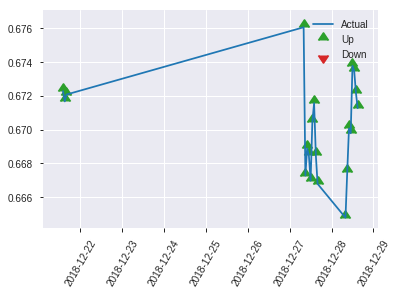


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26740658160695224
RMSE: 0.5171137027839741
LogLoss: 0.7599922710170168
Mean Per-Class Error: 0.4295634920634921
AUC: 0.546957671957672
pr_auc: 0.5196883888660534
Gini: 0.09391534391534395
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24627796711492403: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    106  0.9815   (106.0/108.0)
1      0    112  0        (0.0/112.0)
Total  2    218  0.4818   (106.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.246278     0.678788  217
max f2                       0.246278     0.840841  217
max f0point5                 0.513171     0.587798  139
max accuracy                 0.51688      0.572727  137
max precision                0.575409     0.565657  98
max recall                   0.246278     1         217
max specificity              0.988428     0.990741  0
max absolute_mcc             0.513171     0.146056  139
max min_per_class_accuracy   0.559432     0.526786  107
max mean_per_class_accuracy  0.51688      0.570437  137

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 56.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.946513           0         0                  0                0.977394  0                           0.977394            0               0                          -100      -100
    2        0.0227273                   0.896156           0.982143  0.392857           0.5              0.900522  0.2                         0.946645            0.00892857      0.00892857                 -1.78571  -60.7143
    3        0.0318182                   0.872583           0.982143  0.561224           0.5              0.890377  0.285714                    0.930568            0.00892857      0.0178571                  -1.78571  -43.8776
    4        0.0409091                   0.813584           0.982143  0.654762           0.5              0.840703  0.333333                    0.910598            0.00892857      0.0267857                  -1.78571  -34.5238
    5        0.05                        0.797289           0.982143  0.714286           0.5              0.805536  0.363636                    0.891496            0.00892857      0.0357143                  -1.78571  -28.5714
    6        0.1                         0.76426            1.25      0.982143           0.636364         0.782867  0.5                         0.837181            0.0625          0.0982143                  25        -1.78571
    7        0.15                        0.728292           0.892857  0.952381           0.454545         0.747658  0.484848                    0.80734             0.0446429       0.142857                   -10.7143  -4.7619
    8        0.2                         0.698529           1.25      1.02679            0.636364         0.717604  0.522727                    0.784906            0.0625          0.205357                   25        2.67857
    9        0.3                         0.637352           0.982143  1.0119             0.5              0.667628  0.515152                    0.745814            0.0982143       0.303571                   -1.78571  1.19048
    10       0.4                         0.593865           1.07143   1.02679            0.545455         0.611686  0.522727                    0.712282            0.107143        0.410714                   7.14286   2.67857
    11       0.5                         0.552205           1.16071   1.05357            0.590909         0.573424  0.536364                    0.68451             0.116071        0.526786                   16.0714   5.35714
    12       0.6                         0.525087           1.25      1.08631            0.636364         0.537781  0.55303                     0.660055            0.125           0.651786                   25        8.63095
    13       0.7                         0.495152           0.982143  1.07143            0.5              0.509582  0.545455                    0.638559            0.0982143       0.75                       -1.78571  7.14286
    14       0.8                         0.427339           0.982143  1.06027            0.5              0.457513  0.539773                    0.615928            0.0982143       0.848214                   -1.78571  6.02679
    15       0.9                         0.362147           0.714286  1.02183            0.363636         0.392861  0.520202                    0.591143            0.0714286       0.919643                   -28.5714  2.18254
    16       1                           0.151589           0.803571  1                  0.409091         0.298543  0.509091                    0.561883       

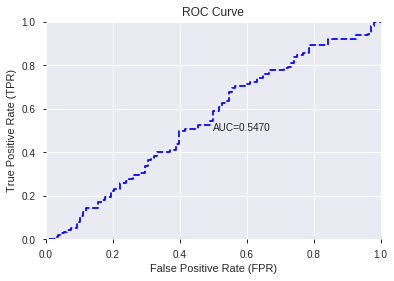

This function is available for GLM models only


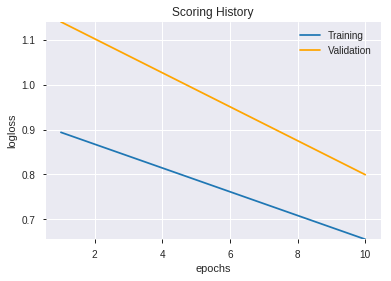

--2019-08-26 17:12:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190826_170526',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190826_170526',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_98_sid_b105'

['ROCR100_20',
 'ROCR_14',
 'aroonup_20',
 'MACDEXT_hist',
 'MACDFIX_signal_20',
 'NATR_12',
 'RSI_24',
 'BBANDS_middleband_30_0_3',
 'MINUS_DM_24',
 'MA_20_1',
 'TRIX_14',
 'MINUS_DI_20',
 'BBANDS_lowerband_14_3_3',
 'MINUS_DM_20',
 'PLUS_DI_14',
 'WILLR_14',
 'BBANDS_middleband_20_0_4',
 'STOCHRSI_fastk',
 'ADXR_8',
 'MACDFIX_hist_14',
 'KAMA_20',
 'MINUS_DI_14',
 'AROONOSC_14',
 'CDLBELTHOLD',
 'MFI_12',
 'CDLHIGHWAVE',
 'aroonup_14',
 'ADOSC',
 'SMA_30',
 'STOCH_slowd',
 'ATR_8',
 'ROC_20',
 'WILLR_30',
 'BBANDS_upperband_14_7_3',
 'AROONOSC_12',
 'WILLR_12',
 'MAVP_20_3',
 'BBANDS_lowerband_14_5_3',
 'ROCR_30',
 'BBANDS_middleband_24_2_4',
 'BBANDS_upperband_14_5_4',
 'PLUS_DI_24',
 'aroondown_8',
 'MOM_12',
 'STOCH_slowk',
 'HT_PHASOR_inphase',
 'PLUS_DM_14',
 'BBANDS_middleband_14_3_4',
 'BETA_8',
 'MOM_30',
 'MACDFIX_hist_12',
 'PLUS_DI_20',
 'CCI_20',
 'MACDFIX_8',
 'BBANDS_lowerband_30_7_3',
 'LINEARREG_SLOPE_8',
 'MACDFIX_24',
 'BBANDS_upperband_20_7_2',
 'ROCR100_12',
 'CCI

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190826_171307_model_1  0.52786  0.692206                   0.5  0.49953  0.24953

variable  relative_importance  scaled_importance  percentage
0                HT_DCPERIOD             0.009333           1.000000    0.049945
1         CDLCLOSINGMARUBOZU             0.008338           0.893479    0.044625
2               aroondown_20             0.006801           0.728767    0.036398
3                 CDLHIKKAKE             0.006789           0.727494    0.036335
4               aroondown_14             0.006368           0.682296    0.034077
..                       ...                  ...                ...         ...
100  BBANDS_lowerband_24_2_3             0.000189           0.020242    0.001011
101                    DX_20             0.000122           0.013093    0.000654
102                   MFI_20             0.000057           0.006153    0.000307
103  BBANDS_lowerband_30_7_3             0.000027           0.002865    0.000143
104  BBANDS_lowerband_14_2_5             0.000014           0.001516    0.000076

[105 rows x 4 columns]

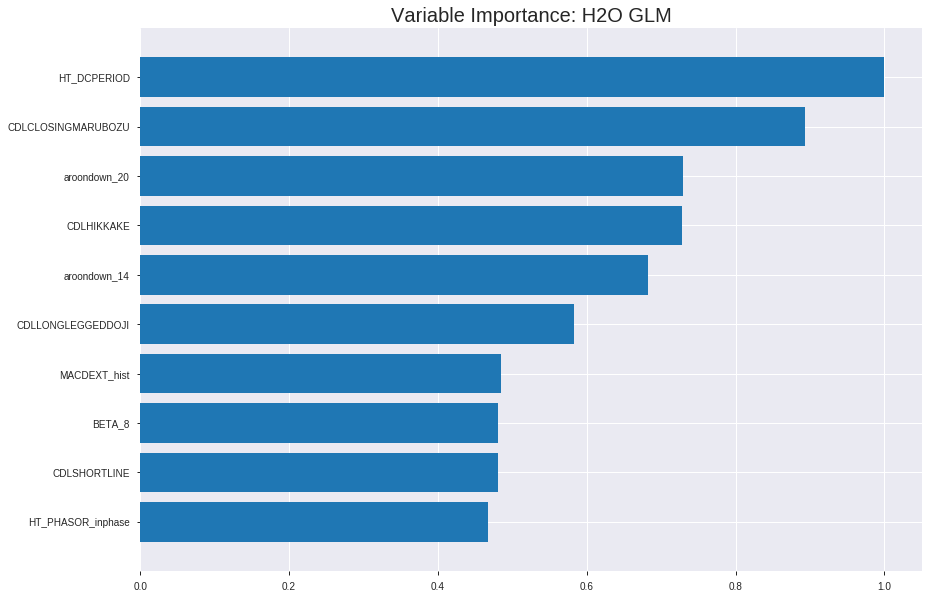

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_171307_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24881365280556778
RMSE: 0.49881224203658814
LogLoss: 0.6907728288412771
Null degrees of freedom: 1534
Residual degrees of freedom: 1429
Null deviance: 2127.955981123116
Residual deviance: 2120.672584542721
AIC: 2332.672584542721
AUC: 0.5651544680114217
pr_auc: 0.5565045394706805
Gini: 0.13030893602284332
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48303619897487027: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      39   727   0.9491   (727.0/766.0)
1      13   756   0.0169   (13.0/769.0)
Total  52   1483  0.4821   (740.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483036     0.671403  366
max f2                       0.470614     0.833876  399
max f0point5                 0.495056     0.569519  263
max accuracy                 0.495512     0.551792  257
max precision                0.552457     1         0
max recall                   0.470614     1         399
max specificity              0.552457     1         0
max absolute_mcc             0.495056     0.111295  263
max min_per_class_accuracy   0.501012     0.535248  203
max mean_per_class_accuracy  0.495512     0.551456  257

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 50.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.532439           1.37232   1.37232            0.6875           0.540072  0.6875                      0.540072            0.0143043       0.0143043                  37.2318   37.2318
    2        0.0201954                   0.526452           1.19766   1.28781            0.6              0.529045  0.645161                    0.534736            0.0117035       0.0260078                  19.7659   28.7806
    3        0.0306189                   0.522047           1.24756   1.27411            0.625            0.523372  0.638298                    0.530868            0.0130039       0.0390117                  24.7562   27.4106
    4        0.0403909                   0.520032           1.06459   1.22342            0.533333         0.520841  0.612903                    0.528442            0.0104031       0.0494148                  6.4586    22.3415
    5        0.0501629                   0.518815           0.931513  1.16655            0.466667         0.519216  0.584416                    0.526645            0.00910273      0.0585176                  -6.84872  16.6551
    6        0.100326                    0.514223           1.2184    1.19247            0.61039          0.516204  0.597403                    0.521424            0.0611183       0.119636                   21.8398   19.2475
    7        0.150489                    0.511544           1.14063   1.17519            0.571429         0.512846  0.588745                    0.518565            0.0572172       0.176853                   14.0628   17.5192
    8        0.2                         0.509745           1.05058   1.14434            0.526316         0.510633  0.57329                     0.516601            0.0520156       0.228869                   5.05783   14.4343
    9        0.300326                    0.506512           1.08878   1.12578            0.545455         0.508149  0.563991                    0.513778            0.109233        0.338101                   8.87812   12.5782
    10       0.4                         0.503492           1.0698    1.11183            0.535948         0.504922  0.557003                    0.511571            0.106632        0.444733                   6.98046   11.1834
    11       0.500326                    0.501013           0.933241  1.07602            0.467532         0.50214   0.539062                    0.50968             0.0936281       0.538362                   -6.6759   7.6022
    12       0.6                         0.497961           1.0959    1.07932            0.54902          0.499432  0.540717                    0.507978            0.109233        0.647594                   9.58974   7.93238
    13       0.699674                    0.494658           1.00457   1.06867            0.503268         0.496264  0.535382                    0.506309            0.10013         0.747724                   0.457261  6.86749
    14       0.8                         0.491415           0.881394  1.04519            0.441558         0.493118  0.523616                    0.504655            0.0884265       0.836151                   -11.8606  4.51886
    15       0.899674                    0.487328           0.887155  1.02768            0.444444         0.489329  0.514844                    0.502957            0.0884265       0.924577                   -11.2845  2.76801
    16       1                           0.470614           0.751777  1                  0.376623         0.483226  0.500977                    0.500977          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25119465599917673
RMSE: 0.5011932321961029
LogLoss: 0.6955391016985737
Null degrees of freedom: 437
Residual degrees of freedom: 332
Null deviance: 607.245508785986
Residual deviance: 609.2922530879506
AIC: 821.2922530879506
AUC: 0.4552217005738133
pr_auc: 0.45242382197080944
Gini: -0.08955659885237344
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48352168087943975: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    224  0.9956   (224.0/225.0)
1      0    213  0        (0.0/213.0)
Total  1    437  0.5114   (224.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483522     0.655385  398
max f2                       0.483522     0.826222  398
max f0point5                 0.483522     0.54309   398
max accuracy                 0.541996     0.515982  4
max precision                0.541996     0.6       4
max recall                   0.483522     1         398
max specificity              0.551017     0.995556  0
max absolute_mcc             0.508967     0.10144   135
max min_per_class_accuracy   0.50391      0.474178  197
max mean_per_class_accuracy  0.518707     0.502754  41

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 50.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.541882           1.2338    1.2338             0.6              0.546075  0.6                         0.546075            0.0140845       0.0140845                  23.3803   23.3803
    2        0.0205479                   0.535309           0         0.685446           0                0.539659  0.333333                    0.543223            0               0.0140845                  -100      -31.4554
    3        0.0319635                   0.531038           1.2338    0.881288           0.6              0.533817  0.428571                    0.539864            0.0140845       0.028169                   23.3803   -11.8712
    4        0.0410959                   0.525543           1.02817   0.913928           0.5              0.527262  0.444444                    0.537063            0.00938967      0.0375587                  2.8169    -8.6072
    5        0.0502283                   0.523992           0         0.747759           0                0.524553  0.363636                    0.534789            0               0.0375587                  -100      -25.2241
    6        0.100457                    0.51848            1.30858   1.02817            0.636364         0.520919  0.5                         0.527854            0.0657277       0.103286                   30.8579   2.8169
    7        0.150685                    0.515614           0.654289  0.903542           0.318182         0.516981  0.439394                    0.524229            0.0328638       0.13615                    -34.5711  -9.64575
    8        0.200913                    0.513929           0.841229  0.887964           0.409091         0.514589  0.431818                    0.521819            0.0422535       0.178404                   -15.8771  -11.2036
    9        0.30137                     0.509994           0.841229  0.872386           0.409091         0.511808  0.424242                    0.518482            0.084507        0.262911                   -15.8771  -12.7614
    10       0.399543                    0.506931           0.956436  0.893038           0.465116         0.508361  0.434286                    0.515995            0.0938967       0.356808                   -4.35637  -10.6962
    11       0.5                         0.503877           1.16837   0.948357           0.568182         0.505485  0.461187                    0.513884            0.117371        0.474178                   16.8374   -5.16432
    12       0.600457                    0.501224           0.981434  0.953891           0.477273         0.5025    0.463878                    0.511979            0.0985915       0.57277                    -1.85659  -4.61094
    13       0.69863                     0.498391           0.908614  0.947528           0.44186          0.499806  0.460784                    0.510268            0.0892019       0.661972                   -9.13855  -5.24717
    14       0.799087                    0.495644           1.16837   0.975292           0.568182         0.497046  0.474286                    0.508606            0.117371        0.779343                   16.8374   -2.47082
    15       0.899543                    0.492802           1.12164   0.991635           0.545455         0.494305  0.482234                    0.507009            0.112676        0.892019                   12.1639   -0.836491
    16       1                           0.480309           1.0749    1                  0.522727         0.489162  0.486301                    0.505


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 17:13:08  0.000 sec   2            3.2       106           1.38155           1.39108
    2019-08-26 17:13:08  0.034 sec   4            2.3       106           1.38024           1.39215
    2019-08-26 17:13:08  0.062 sec   6            1.7       106           1.37865           1.39345
    2019-08-26 17:13:08  0.091 sec   8            1.2       106           1.37679           1.39503
    2019-08-26 17:13:08  0.120 sec   10           0.9       106           1.37463           1.39695

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5454545454545454)

('F1', 0.6746987951807228)

('auc', 0.5278604497354498)

('logloss', 0.6922060948226609)

('mean_per_class_error', 0.4601521164021164)

('rmse', 0.4995295070678027)

('mse', 0.24952972843140195)

glm prediction progress: |████████████████████████████████████████████████| 100%


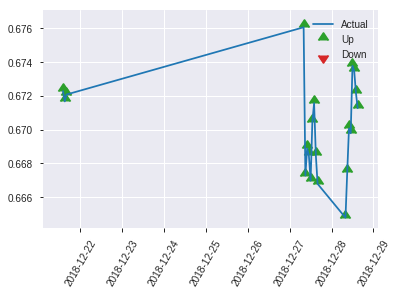


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24952972843140195
RMSE: 0.4995295070678027
LogLoss: 0.6922060948226609
Null degrees of freedom: 219
Residual degrees of freedom: 114
Null deviance: 304.9699645761388
Residual deviance: 304.5706817219708
AIC: 516.5706817219708
AUC: 0.5278604497354498
pr_auc: 0.531839130781031
Gini: 0.05572089947089953
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4842042113395294: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    108  1        (108.0/108.0)
1      0    112  0        (0.0/112.0)
Total  0    220  0.4909   (108.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484204     0.674699  219
max f2                       0.484204     0.838323  219
max f0point5                 0.495055     0.576456  177
max accuracy                 0.495055     0.545455  177
max precision                0.534699     1         0
max recall                   0.484204     1         219
max specificity              0.534699     1         0
max absolute_mcc             0.495055     0.101373  177
max min_per_class_accuracy   0.505962     0.526786  108
max mean_per_class_accuracy  0.495055     0.539848  177

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.533307           1.30952   1.30952            0.666667         0.534191  0.666667                    0.534191            0.0178571       0.0178571                  30.9524   30.9524
    2        0.0227273                   0.530052           0.982143  1.17857            0.5              0.53058   0.6                         0.532747            0.00892857      0.0267857                  -1.78571  17.8571
    3        0.0318182                   0.527812           0.982143  1.12245            0.5              0.529378  0.571429                    0.531784            0.00892857      0.0357143                  -1.78571  12.2449
    4        0.0409091                   0.525118           0.982143  1.09127            0.5              0.52617   0.555556                    0.530537            0.00892857      0.0446429                  -1.78571  9.12698
    5        0.05                        0.524182           1.96429   1.25               1                0.524976  0.636364                    0.529526            0.0178571       0.0625                     96.4286   25
    6        0.1                         0.520602           0.892857  1.07143            0.454545         0.522349  0.545455                    0.525938            0.0446429       0.107143                   -10.7143  7.14286
    7        0.15                        0.51785            0.892857  1.0119             0.454545         0.519562  0.515152                    0.523812            0.0446429       0.151786                   -10.7143  1.19048
    8        0.2                         0.515197           1.42857   1.11607            0.727273         0.516522  0.568182                    0.52199             0.0714286       0.223214                   42.8571   11.6071
    9        0.3                         0.512412           1.07143   1.10119            0.545455         0.514     0.560606                    0.519326            0.107143        0.330357                   7.14286   10.119
    10       0.4                         0.509292           0.892857  1.04911            0.454545         0.511046  0.534091                    0.517256            0.0892857       0.419643                   -10.7143  4.91071
    11       0.5                         0.505809           1.07143   1.05357            0.545455         0.507733  0.536364                    0.515352            0.107143        0.526786                   7.14286   5.35714
    12       0.6                         0.50262            0.892857  1.02679            0.454545         0.504087  0.522727                    0.513474            0.0892857       0.616071                   -10.7143  2.67857
    13       0.7                         0.498614           0.892857  1.00765            0.454545         0.500713  0.512987                    0.511651            0.0892857       0.705357                   -10.7143  0.765306
    14       0.8                         0.495254           1.25      1.03795            0.636364         0.496944  0.528409                    0.509813            0.125           0.830357                   25        3.79464
    15       0.9                         0.49121            0.803571  1.0119             0.409091         0.493175  0.515152                    0.507964            0.0803571       0.910714                   -19.6429  1.19048
    16       1                           0.484204           0.892857  1                  0.454545         0.488053  0.509091                    0.505973            0.

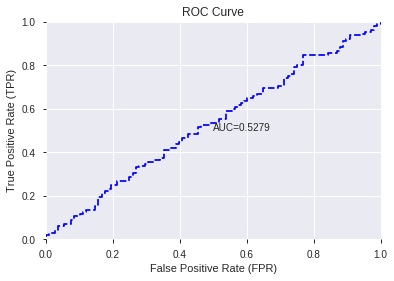

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


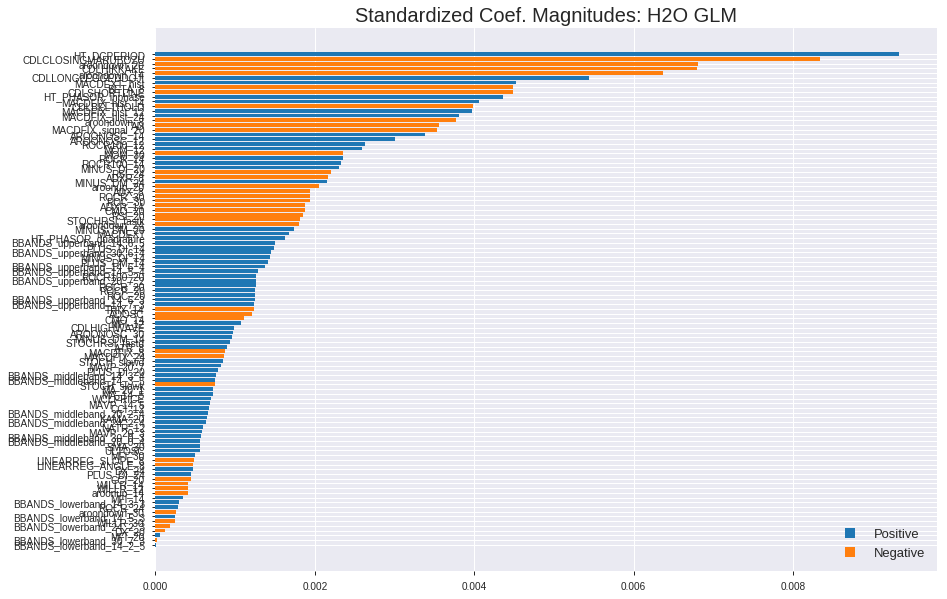

'log_likelihood'
--2019-08-26 17:13:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_171307_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_171307_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['HT_DCPERIOD',
 'CDLCLOSINGMARUBOZU',
 'aroondown_20',
 'CDLHIKKAKE',
 'aroondown_14',
 'CDLLONGLEGGEDDOJI',
 'MACDEXT_hist',
 'BETA_8',
 'CDLSHORTLINE',
 'HT_PHASOR_inphase',
 'MACDFIX_hist_14',
 'CDLBELTHOLD',
 'MACDFIX_hist_12',
 'MACDFIX_hist_24',
 'aroondown_8',
 'AD',
 'MACDFIX_signal_20',
 'AROONOSC_14',
 'AROONOSC_12',
 'ROCR100_12',
 'MOM_12',
 'MOM_30',
 'ROCR_14',
 'ROCR100_14',
 'MINUS_DI_20',
 'RSI_24',
 'ADXR_8',
 'MINUS_DM_24',
 'aroonup_20',
 'ADX_8',
 'ROCR_30',
 'ROC_30',
 'ADXR_14',
 'CMO_20',
 'RSI_20',
 'STOCHRSI_fastk',
 'aroondown_24',
 'MINUS_DM_20',
 'MACDEXT',
 'HT_PHASOR_quadrature',
 'BBANDS_upperband_14_6_5',
 'PLUS_DI_14',
 'BBANDS_upperband_30_6_4',
 'MINUS_DI_14',
 'PLUS_DM_14',
 'BBANDS_upperband_14_6_4',
 'BBANDS_upperband_14_5_4',
 'ROCR100_20',
 'BBANDS_upperband_20_7_2',
 'ROCR_20',
 'ROCP_20',
 'ROC_20',
 'BBANDS_upperband_14_6_3',
 'BBANDS_upperband_14_7_3',
 'TRIX_14',
 'ADOSC',
 'CMO_14',
 'MFI_12',
 'CDLHIGHWAVE',
 'AROONOSC_30',
 'MINUS_DM_14

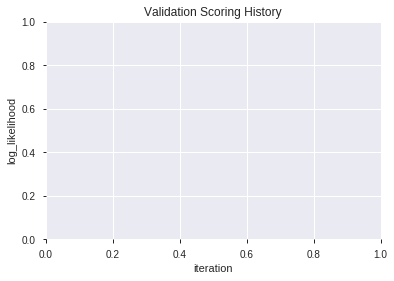

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190826_171325  0.545966  0.692007              0.495370  0.499437  0.249438
1  XGBoost_grid_1_AutoML_20190826_171325_model_7  0.537616  0.711405              0.486111  0.508206  0.258274
2  XGBoost_grid_1_AutoML_20190826_171325_model_3  0.537450  0.694979              0.476521  0.500766  0.250766
3  XGBoost_grid_1_AutoML_20190826_171325_model_4  0.534433  0.693080              0.490741  0.499978  0.249978
4               XGBoost_1_AutoML_20190826_171325  0.528522  0.699876              0.466931  0.503197  0.253207
5  XGBoost_grid_1_AutoML_20190826_171325_model_2  0.522652  0.696331              0.495370  0.501570  0.251573
6               XGBoost_2_AutoML_20190826_171325  0.521164  0.699378              0.452546  0.502838  0.252847
7  XGBoost_grid_1_AutoML_20190826_171325_model_6  0.521081  0.694503              0.457507  0.500678  0.250678
8  XGBoost_grid_1_AutoML_20190826_171325_model_1  0.507440  0.702432              0.485946  0.504513  0.254534
9  XGBoost_grid_1_AutoML_20190826_171325_model_5  0.497520  0.748806              0.495205  0.523957  0.274531

variable  relative_importance  scaled_importance  percentage
0               STOCH_slowk           140.908676           1.000000    0.031647
1                    ADXR_8           139.682251           0.991296    0.031372
2           MACDFIX_hist_24           118.312813           0.839642    0.026572
3               HT_DCPERIOD           117.698639           0.835283    0.026434
4                    ULTOSC           112.288780           0.796890    0.025219
..                      ...                  ...                ...         ...
95                  MA_20_1             5.690994           0.040388    0.001278
96        CDLLONGLEGGEDDOJI             4.816888           0.034184    0.001082
97  BBANDS_lowerband_14_5_3             4.536328           0.032193    0.001019
98                 WCLPRICE             2.698629           0.019152    0.000606
99               ROCR100_14             2.157642           0.015312    0.000485

[100 rows x 4 columns]

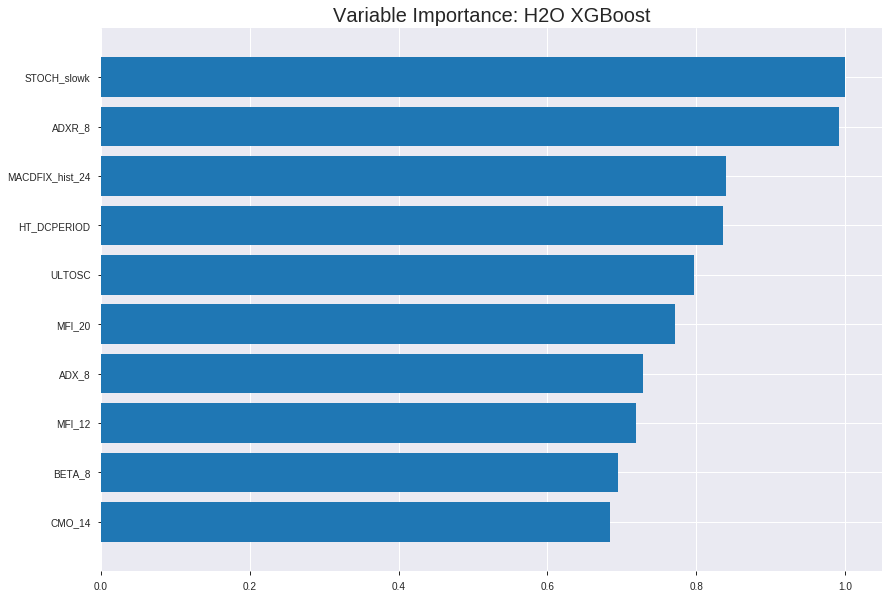

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190826_171325


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18398986263305778
RMSE: 0.42894039519851446
LogLoss: 0.5578543084316399
Mean Per-Class Error: 0.12774125971472905
AUC: 0.9454252071966237
pr_auc: 0.9438751017965487
Gini: 0.8908504143932474
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49058986206849414: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      647  119  0.1554   (119.0/766.0)
1      77   692  0.1001   (77.0/769.0)
Total  724  811  0.1277   (196.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49059      0.875949  214
max f2                       0.447021     0.91954   259
max f0point5                 0.524455     0.886152  178
max accuracy                 0.49059      0.872313  214
max precision                0.800854     1         0
max recall                   0.348713     1         357
max specificity              0.800854     1         0
max absolute_mcc             0.49059      0.745715  214
max min_per_class_accuracy   0.498942     0.864759  205
max mean_per_class_accuracy  0.49059      0.872259  214

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 49.95 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.74071            1.9961     1.9961             1                0.767838  1                           0.767838            0.0208062       0.0208062                  99.6099   99.6099
    2        0.0201954                   0.709568           1.9961     1.9961             1                0.723265  1                           0.746271            0.0195059       0.0403121                  99.6099   99.6099
    3        0.0306189                   0.6936             1.9961     1.9961             1                0.701309  1                           0.730964            0.0208062       0.0611183                  99.6099   99.6099
    4        0.0403909                   0.67775            1.9961     1.9961             1                0.6829    1                           0.719336            0.0195059       0.0806242                  99.6099   99.6099
    5        0.0501629                   0.666896           1.9961     1.9961             1                0.671909  1                           0.710097            0.0195059       0.10013                    99.6099   99.6099
    6        0.100326                    0.632483           1.9961     1.9961             1                0.649582  1                           0.67984             0.10013         0.20026                    99.6099   99.6099
    7        0.150489                    0.609823           1.91833    1.97018            0.961039         0.621044  0.987013                    0.660241            0.0962289       0.296489                   91.8329   97.0175
    8        0.2                         0.59172            1.91731    1.95709            0.960526         0.599474  0.980456                    0.645198            0.0949285       0.391417                   91.7305   95.7087
    9        0.300326                    0.558758           1.84056    1.91816            0.922078         0.574619  0.960954                    0.62162             0.184655        0.576073                   84.0559   91.816
    10       0.4                         0.529293           1.65689    1.85306            0.830065         0.544022  0.928339                    0.602284            0.16515         0.741222                   65.6892   85.3056
    11       0.500326                    0.498562           1.23136    1.72839            0.616883         0.513838  0.865885                    0.584549            0.123537        0.864759                   23.136    72.8393
    12       0.6                         0.466053           0.861062   1.58431            0.431373         0.48263   0.793702                    0.567618            0.0858257       0.950585                   -13.8938  58.4309
    13       0.699674                    0.43494            0.391392   1.41437            0.196078         0.450683  0.708566                    0.550959            0.0390117       0.989597                   -60.8608  41.4368
    14       0.8                         0.404593           0.038885   1.24187            0.0194805        0.419358  0.62215                     0.534455            0.00390117      0.993498                   -96.1115  24.1873
    15       0.899674                    0.36319            0.0391392  1.10862            0.0196078        0.386371  0.555395                    0.518049            0.00390117      0.997399                   -96.0861  10.8623
    16       1                           0.236525           0.0259234  1                  0.012987         0.333486  0.500977                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.258184534540609
RMSE: 0.5081186225091627
LogLoss: 0.7101012840108806
Mean Per-Class Error: 0.48140845070422533
AUC: 0.4888993218570683
pr_auc: 0.48465149684818004
Gini: -0.022201356285863394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2994833290576935: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    225  1        (225.0/225.0)
1      0    213  0        (0.0/213.0)
Total  0    438  0.5137   (225.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.299483     0.654378   399
max f2                       0.299483     0.825581   399
max f0point5                 0.299483     0.541985   399
max accuracy                 0.582613     0.527397   76
max precision                0.738875     1          0
max recall                   0.299483     1          399
max specificity              0.738875     1          0
max absolute_mcc             0.30741      0.0853527  396
max min_per_class_accuracy   0.516289     0.488889   199
max mean_per_class_accuracy  0.582613     0.518592   76

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 51.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.683997           1.2338    1.2338             0.6              0.715946  0.6                         0.715946            0.0140845       0.0140845                  23.3803   23.3803
    2        0.0205479                   0.666431           1.54225   1.37089            0.75             0.672284  0.666667                    0.696541            0.0140845       0.028169                   54.2254   37.0892
    3        0.0319635                   0.657529           0.411268  1.02817            0.2              0.662123  0.5                         0.684249            0.00469484      0.0328638                  -58.8732  2.8169
    4        0.0410959                   0.651917           1.02817   1.02817            0.5              0.654067  0.5                         0.677542            0.00938967      0.0422535                  2.8169    2.8169
    5        0.0502283                   0.64461            1.02817   1.02817            0.5              0.647866  0.5                         0.672146            0.00938967      0.0516432                  2.8169    2.8169
    6        0.100457                    0.613939           0.841229  0.934699           0.409091         0.628892  0.454545                    0.650519            0.0422535       0.0938967                  -15.8771  -6.53009
    7        0.150685                    0.589521           1.40205   1.09048            0.681818         0.60244   0.530303                    0.634493            0.0704225       0.164319                   40.2049   9.04823
    8        0.200913                    0.57761            1.02817   1.0749             0.5              0.582773  0.522727                    0.621563            0.0516432       0.215962                   2.8169    7.4904
    9        0.30137                     0.557448           0.887964  1.01259            0.431818         0.566614  0.492424                    0.603246            0.0892019       0.305164                   -11.2036  1.25907
    10       0.399543                    0.534773           0.812971  0.963541           0.395349         0.545634  0.468571                    0.58909             0.0798122       0.384977                   -18.7029  -3.64588
    11       0.5                         0.516362           1.02817   0.976526           0.5              0.524945  0.474886                    0.576203            0.103286        0.488263                   2.8169    -2.34742
    12       0.600457                    0.495316           1.16837   1.00862            0.568182         0.505722  0.490494                    0.564411            0.117371        0.605634                   16.8374   0.862207
    13       0.69863                     0.4708             0.765149  0.974409           0.372093         0.483241  0.473856                    0.553005            0.0751174       0.680751                   -23.4851  -2.55915
    14       0.799087                    0.45579            1.0749    0.987042           0.522727         0.463698  0.48                        0.541778            0.107981        0.788732                   7.4904    -1.29577
    15       0.899543                    0.419267           0.934699  0.981197           0.454545         0.436583  0.477157                    0.53003             0.0938967       0.882629                   -6.53009  -1.88032
    16       1                           0.299483           1.16837   1                  0.568182         0.380487  0.486301                    0.515008      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:13:28  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.499023                         0.5                0.693147              0.5               0                    1                  0.513699
    2019-08-26 17:13:29  0.172 sec   5                  0.491306         0.675885            0.759983        0.768029           1.87134          0.386971                         0.500463           0.694076              0.495889          0.48995              0.822535           0.511416
    2019-08-26 17:13:29  0.233 sec   10                 0.48426          0.662059            0.811432        0.814312           1.9961           0.278827                         0.501203           0.695563              0.488169          0.479528             0.822535           0.513699
    2019-08-26 17:13:29  0.299 sec   15                 0.474589         0.643316            0.866716        0.8661             1.9961           0.218893                         0.501575           0.696314              0.493354          0.488502             1.64507            0.509132
    2019-08-26 17:13:29  0.366 sec   20                 0.466841         0.628475            0.890583        0.890827           1.9961           0.197394                         0.501897           0.69697               0.494564          0.488145             0.411268           0.502283
    2019-08-26 17:13:29  0.430 sec   25                 0.461352         0.618012            0.896066        0.896328           1.9961           0.190228                         0.502402           0.698018              0.499249          0.489262             0.822535           0.502283
    2019-08-26 17:13:29  0.492 sec   30                 0.456048         0.607983            0.90519         0.90564            1.9961           0.184365                         0.502404           0.698036              0.503735          0.494487             0.822535           0.513699
    2019-08-26 17:13:29  0.570 sec   35                 0.448548         0.593908            0.913702        0.913767           1.9961           0.166775                         0.503825           0.701025              0.505446          0.492942             0.822535           0.513699
    2019-08-26 17:13:29  0.640 sec   40                 0.442486         0.582672            0.926734        0.926472           1.9961           0.165472                         0.50526            0.704074              0.502128          0.492625             0.822535           0.513699
    2019-08-26 17:13:29  0.712 sec   45                 0.435709         0.57017             0.936193        0.935511           1.9961           0.144625                         0.506578           0.706872              0.497194          0.491912             1.2338             0.513699
    2019-08-26 17:13:29  0.784 sec   50                 0.42894          0.557854            0.945425        0.943875           1.9961           0.127687                         0.508119           0.710101              0.488899          0.484651             1.2338             0.513699

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
STOCH_slowk              140.90867614746094     1.0                   0.03164732420029813
ADXR_8                   139.6822509765625      0.9912963118778081    0.03137187576055684
MACDFIX_hist_24          118.31281280517578     0.8396417881419979    0.02657241588144784
HT_DCPERIOD              117.69863891601562     0.8352831219054531    0.026434475757979015
ULTOSC                   112.28878021240234     0.7968904632592824    0.025219450842892274
---                      ---                    ---                   ---
MA_20_1                  5.690993785858154      0.04038781671543439   0.0012781663293355721
CDLLONGLEGGEDDOJI        4.816888332366943      0.03418446943129371   0.001081846986707333
BBANDS_lowerband_14_5_3  4.536328315734863      0.03219339248484313   0.0010188347290752719
WCLPRICE                 2.6986289024353027     0.019151616324967723  0.0006060974107959757
ROCR100_14               2.157642364501953      0.015312345722728814  0.0004845947693542471


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5636363636363636)

('F1', 0.676737160120846)

('auc', 0.5459656084656085)

('logloss', 0.6920067578293904)

('mean_per_class_error', 0.4323743386243386)

('rmse', 0.4994372589885163)

('mse', 0.2494375756659623)

xgboost prediction progress: |████████████████████████████████████████████| 100%


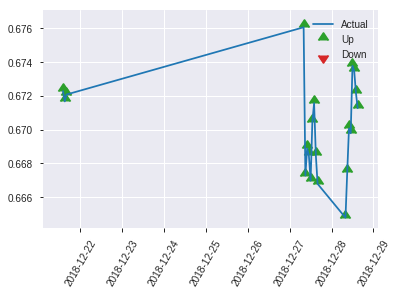


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2494375756659623
RMSE: 0.4994372589885163
LogLoss: 0.6920067578293904
Mean Per-Class Error: 0.4323743386243386
AUC: 0.5459656084656085
pr_auc: 0.5633700883176622
Gini: 0.09193121693121697
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3654596209526062: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    107  0.9907   (107.0/108.0)
1      0    112  0        (0.0/112.0)
Total  1    219  0.4864   (107.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36546      0.676737  218
max f2                       0.36546      0.83958   218
max f0point5                 0.447196     0.570276  188
max accuracy                 0.569412     0.563636  61
max precision                0.702226     1         0
max recall                   0.36546      1         218
max specificity              0.702226     1         0
max absolute_mcc             0.569412     0.150293  61
max min_per_class_accuracy   0.524535     0.518519  110
max mean_per_class_accuracy  0.569412     0.567626  61

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 52.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.693819           1.96429   1.96429            1                0.698027  1                           0.698027            0.0267857       0.0267857                  96.4286   96.4286
    2        0.0227273                   0.682546           0.982143  1.57143            0.5              0.688632  0.8                         0.694269            0.00892857      0.0357143                  -1.78571  57.1429
    3        0.0318182                   0.671941           0.982143  1.40306            0.5              0.679436  0.714286                    0.690031            0.00892857      0.0446429                  -1.78571  40.3061
    4        0.0409091                   0.65923            0.982143  1.30952            0.5              0.664568  0.666667                    0.684372            0.00892857      0.0535714                  -1.78571  30.9524
    5        0.05                        0.637882           0.982143  1.25               0.5              0.650849  0.636364                    0.678277            0.00892857      0.0625                     -1.78571  25
    6        0.1                         0.600931           1.25      1.25               0.636364         0.620864  0.636364                    0.649571            0.0625          0.125                      25        25
    7        0.15                        0.593359           0.892857  1.13095            0.454545         0.596082  0.575758                    0.631741            0.0446429       0.169643                   -10.7143  13.0952
    8        0.2                         0.582471           1.07143   1.11607            0.545455         0.586578  0.568182                    0.62045             0.0535714       0.223214                   7.14286   11.6071
    9        0.3                         0.5668             1.42857   1.22024            0.727273         0.574258  0.621212                    0.605053            0.142857        0.366071                   42.8571   22.0238
    10       0.4                         0.53901            0.892857  1.13839            0.454545         0.552248  0.579545                    0.591852            0.0892857       0.455357                   -10.7143  13.8393
    11       0.5                         0.525049           0.625     1.03571            0.318182         0.532707  0.527273                    0.580023            0.0625          0.517857                   -37.5     3.57143
    12       0.6                         0.512062           1.16071   1.05655            0.590909         0.518772  0.537879                    0.569814            0.116071        0.633929                   16.0714   5.65476
    13       0.7                         0.490771           0.625     0.994898           0.318182         0.499915  0.506494                    0.559829            0.0625          0.696429                   -37.5     -0.510204
    14       0.8                         0.46731            1.07143   1.00446            0.545455         0.477246  0.511364                    0.549506            0.107143        0.803571                   7.14286   0.446429
    15       0.9                         0.433113           0.982143  1.00198            0.5              0.450232  0.510101                    0.538475            0.0982143       0.901786                   -1.78571  0.198413
    16       1                           0.362594           0.982143  1                  0.5              0.400061  0.509091                    0.524634            0.0

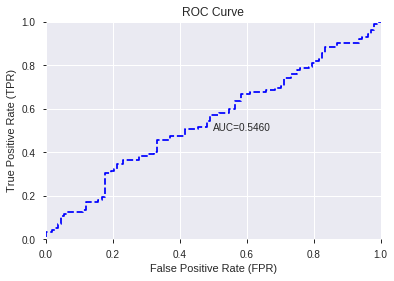

This function is available for GLM models only


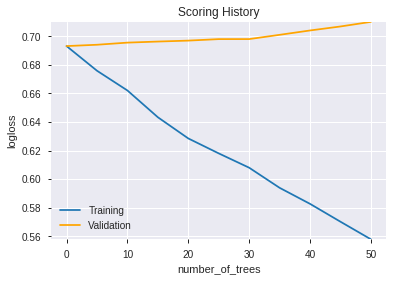

--2019-08-26 17:13:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.156
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.156|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190826_171325',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190826_171325',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b105',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_b105',
   'ty

['STOCH_slowk',
 'ADXR_8',
 'MACDFIX_hist_24',
 'HT_DCPERIOD',
 'ULTOSC',
 'MFI_20',
 'ADX_8',
 'MFI_12',
 'BETA_8',
 'CMO_14',
 'ADXR_14',
 'STOCH_slowd',
 'MINUS_DI_20',
 'PLUS_DI_14',
 'CCI_20',
 'NATR_12',
 'MACDEXT_hist',
 'ROCR_14',
 'MOM_12',
 'WILLR_12',
 'HT_PHASOR_inphase',
 'BBANDS_lowerband_30_7_3',
 'MACDFIX_signal_20',
 'HT_PHASOR_quadrature',
 'ROC_30',
 'ROCR_24',
 'aroondown_14',
 'ROC_20',
 'WILLR_14',
 'PLUS_DM_14',
 'ADOSC',
 'BBANDS_upperband_30_6_4',
 'CDLSHORTLINE',
 'MINUS_DI_14',
 'AROONOSC_14',
 'MOM_30',
 'WILLR_30',
 'BBANDS_upperband_14_6_4',
 'CCI_12',
 'DX_24',
 'MACDFIX_hist_14',
 'MINUS_DM_14',
 'BBANDS_upperband_14_5_4',
 'BBANDS_upperband_20_7_2',
 'MFI_14',
 'BBANDS_upperband_14_6_3',
 'STOCHRSI_fastd',
 'DX_20',
 'CMO_20',
 'RSI_24',
 'MAVP_20_3',
 'MFI_30',
 'LINEARREG_ANGLE_8',
 'PLUS_DI_24',
 'BBANDS_lowerband_14_3_3',
 'BBANDS_lowerband_14_2_5',
 'TRIX_14',
 'BBANDS_middleband_20_0_4',
 'RSI_20',
 'MACDEXT',
 'CDLHIGHWAVE',
 'MACDFIX_hist_12',
 

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.573
GLM             0.564
XGBoost         0.573
dtype: float64

DeepLearning    GLM  XGBoost
All          0.564  0.564    0.573
DLF          0.550  0.518    0.545
Fwe          0.568  0.564    0.573
RFE          0.573  0.545    0.564
XGBF         0.559  0.518    0.545





F1


DeepLearning    0.683
GLM             0.679
XGBoost         0.681
dtype: float64

DeepLearning    GLM  XGBoost
All          0.683  0.676    0.681
DLF          0.675  0.679    0.681
Fwe          0.677  0.676    0.681
RFE          0.679  0.675    0.677
XGBF         0.678  0.679    0.681





auc


DeepLearning    0.558
GLM             0.532
XGBoost         0.568
dtype: float64

DeepLearning    GLM  XGBoost
All          0.558  0.532    0.568
DLF          0.521  0.466    0.515
Fwe          0.546  0.532    0.568
RFE          0.547  0.528    0.546
XGBF         0.536  0.466    0.515





logloss


DeepLearning    0.889
GLM             0.694
XGBoost         0.735
dtype: float64

DeepLearning    GLM  XGBoost
All          0.694  0.692    0.687
DLF          0.823  0.694    0.735
Fwe          0.713  0.692    0.687
RFE          0.760  0.692    0.692
XGBF         0.889  0.694    0.735





mean_per_class_error


DeepLearning    0.455
GLM             0.480
XGBoost         0.452
dtype: float64

DeepLearning    GLM  XGBoost
All          0.437  0.436    0.424
DLF          0.455  0.480    0.452
Fwe          0.435  0.436    0.424
RFE          0.430  0.460    0.432
XGBF         0.446  0.480    0.452





rmse


DeepLearning    0.543
GLM             0.500
XGBoost         0.518
dtype: float64

DeepLearning  GLM  XGBoost
All          0.500  0.5    0.497
DLF          0.534  0.5    0.518
Fwe          0.507  0.5    0.497
RFE          0.517  0.5    0.499
XGBF         0.543  0.5    0.518





mse


DeepLearning    0.295
GLM             0.250
XGBoost         0.269
dtype: float64

DeepLearning   GLM  XGBoost
All          0.250  0.25    0.247
DLF          0.285  0.25    0.269
Fwe          0.257  0.25    0.247
RFE          0.267  0.25    0.249
XGBF         0.295  0.25    0.269

{'F1':       DeepLearning    GLM  XGBoost
 All          0.683    NaN      NaN
 DLF          0.675    NaN      NaN
 DLF            NaN  0.679      NaN
 DLF            NaN    NaN    0.681
 All            NaN  0.676      NaN
 All            NaN    NaN    0.681
 XGBF         0.678    NaN      NaN
 XGBF           NaN  0.679      NaN
 XGBF           NaN    NaN    0.681
 Fwe          0.677    NaN      NaN
 Fwe            NaN  0.676      NaN
 Fwe            NaN    NaN    0.681
 RFE          0.679    NaN      NaN
 RFE            NaN  0.675      NaN
 RFE            NaN    NaN    0.677,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.564    NaN      NaN
 DLF          0.550    NaN      NaN
 DLF            NaN  0.518      NaN
 DLF            NaN    NaN    0.545
 All            NaN  0.564      NaN
 All            NaN    NaN    0.573
 XGBF         0.559    NaN      NaN
 XGBF           NaN  0.518      NaN
 XGBF           NaN    NaN    0.545
 Fwe          0.568    NaN      NaN
 Fwe     